In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def extract_vehicle_platoons(data, platoon_size=4, window_length=200, max_position_jump=10):
    """
    Extract vehicle platoons of a specified size from the NGSIM dataset.

    Parameters:
        data (pd.DataFrame): NGSIM dataset containing vehicle trajectory information.
        platoon_size (int): Number of vehicles in a platoon (e.g., 2, 3, 4, etc.).
        window_length (int): Minimum number of frames required for a valid platoon.
        max_position_jump (float): Maximum allowable increase in position for consecutive frames.

    Returns:
        list: A list of dictionaries with platoon data, including vehicle IDs and longitudinal positions.
    """
    # Ensure the data is sorted by Frame_ID and Vehicle_ID
    data = data.sort_values(by=["Frame_ID", "Vehicle_ID"]).reset_index(drop=True)
    
    # List to store platoon information
    platoons = []

    # Group data by Frame_ID to analyze the scene at each frame
    grouped = data.groupby("Frame_ID")
    
    for frame_id, frame_data in grouped:
        for _, vehicle in frame_data.iterrows():
            # Start forming the platoon from the current vehicle
            platoon_ids = [vehicle["Vehicle_ID"]]
            current_row = vehicle
            
            # Iteratively find followers to complete the platoon
            for _ in range(platoon_size - 1):
                next_vehicle_id = current_row["Following"]
                if next_vehicle_id == 0:
                    break
                next_vehicle_row = frame_data[frame_data["Vehicle_ID"] == next_vehicle_id]
                if next_vehicle_row.empty or next_vehicle_row.iloc[0]["Lane_ID"] != vehicle["Lane_ID"]:
                    break
                platoon_ids.append(next_vehicle_id)
                current_row = next_vehicle_row.iloc[0]
            
            # Only consider valid platoons of the specified size
            if len(platoon_ids) == platoon_size:
                platoons.append({
                    "Frame_ID": frame_id,
                    "Vehicle_IDs": tuple(platoon_ids),  # Use tuple for hashability
                    "Positions": [
                        frame_data[frame_data["Vehicle_ID"] == vid].iloc[0]["Local_Y"] 
                        for vid in platoon_ids
                    ]
                })
    
    # Convert platoon list into a DataFrame
    platoons_df = pd.DataFrame(platoons)

    # Group by unique platoons to form consistent trajectories over time
    platoons_grouped = platoons_df.groupby("Vehicle_IDs")  # Vehicle_IDs is now a tuple
    platoon_trajectories = []
    
    for platoon_ids, group in platoons_grouped:
        frames = group["Frame_ID"].values
        # 'Positions' is a list of lists; convert to a numpy array and transpose so that
        # rows correspond to vehicles and columns to time steps.
        positions = np.array(list(group["Positions"].values)).T
        
        # Check for large jumps in positions between consecutive frames.
        valid_indices = [0]  # Start with the first index
        for i in range(1, len(frames)):
            if all(
                abs(positions[j][i] - positions[j][i - 1]) <= max_position_jump
                for j in range(platoon_size)
            ):
                valid_indices.append(i)
            else:
                # If a jump is detected, save the valid segment if long enough
                if len(valid_indices) > window_length:
                    platoon_trajectories.append({
                        "Vehicle_IDs": platoon_ids,
                        "Longitudinal_Positions": positions[:, valid_indices],
                        "Frames": frames[valid_indices]
                    })
                valid_indices = []  # Reset the valid indices
        
        # Save any remaining valid segment if long enough
        if len(valid_indices) > window_length:
            platoon_trajectories.append({
                "Vehicle_IDs": platoon_ids,
                "Longitudinal_Positions": positions[:, valid_indices],
                "Frames": frames[valid_indices]
            })

    return platoon_trajectories


def plot_platoon(platoon):
    """
    Plot the longitudinal positions for one platoon.
    
    Parameters:
        platoon (dict): A dictionary containing keys 'Vehicle_IDs' and 'Longitudinal_Positions'.
    """
    vehicle_ids = platoon["Vehicle_IDs"]
    positions = platoon["Longitudinal_Positions"]
    
    plt.figure(figsize=(5, 3))
    for i, vid in enumerate(vehicle_ids):
        plt.plot(positions[i], label=f"Vehicle {vid}")
    plt.xlabel("Frame")
    plt.ylabel("Longitudinal Position (m)")
    plt.title(f"Platoon: {' - '.join(map(str, vehicle_ids))}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Processing file: data/I-80/trajectories-0400-0415.csv
  Found 629 platoon trajectories.
  Saved platoon to platoon_size=5/I-80/i-80_0000.csv
  Saved platoon to platoon_size=5/I-80/i-80_0001.csv
  Saved platoon to platoon_size=5/I-80/i-80_0002.csv
  Saved platoon to platoon_size=5/I-80/i-80_0003.csv
  Saved platoon to platoon_size=5/I-80/i-80_0004.csv
  Saved platoon to platoon_size=5/I-80/i-80_0005.csv
  Saved platoon to platoon_size=5/I-80/i-80_0006.csv
  Saved platoon to platoon_size=5/I-80/i-80_0007.csv
  Saved platoon to platoon_size=5/I-80/i-80_0008.csv
  Saved platoon to platoon_size=5/I-80/i-80_0009.csv
  Saved platoon to platoon_size=5/I-80/i-80_0010.csv
  Saved platoon to platoon_size=5/I-80/i-80_0011.csv
  Saved platoon to platoon_size=5/I-80/i-80_0012.csv
  Saved platoon to platoon_size=5/I-80/i-80_0013.csv
  Saved platoon to platoon_size=5/I-80/i-80_0014.csv
  Saved platoon to platoon_size=5/I-80/i-80_0015.csv
  Saved platoon to platoon_size=5/I-80/i-80_0016.csv
  Saved pla

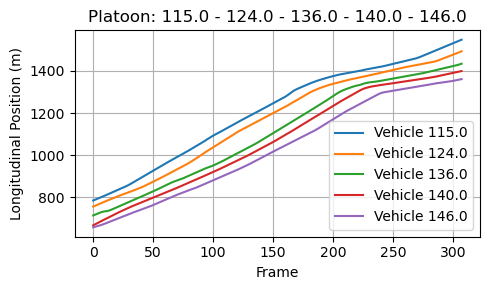

  Saved platoon to platoon_size=5/I-80/i-80_0020.csv
  Saved platoon to platoon_size=5/I-80/i-80_0021.csv
  Saved platoon to platoon_size=5/I-80/i-80_0022.csv
  Saved platoon to platoon_size=5/I-80/i-80_0023.csv
  Saved platoon to platoon_size=5/I-80/i-80_0024.csv
  Saved platoon to platoon_size=5/I-80/i-80_0025.csv
  Saved platoon to platoon_size=5/I-80/i-80_0026.csv
  Saved platoon to platoon_size=5/I-80/i-80_0027.csv
  Saved platoon to platoon_size=5/I-80/i-80_0028.csv
  Saved platoon to platoon_size=5/I-80/i-80_0029.csv
  Saved platoon to platoon_size=5/I-80/i-80_0030.csv
  Saved platoon to platoon_size=5/I-80/i-80_0031.csv
  Saved platoon to platoon_size=5/I-80/i-80_0032.csv
  Saved platoon to platoon_size=5/I-80/i-80_0033.csv
  Saved platoon to platoon_size=5/I-80/i-80_0034.csv
  Saved platoon to platoon_size=5/I-80/i-80_0035.csv
  Saved platoon to platoon_size=5/I-80/i-80_0036.csv
  Saved platoon to platoon_size=5/I-80/i-80_0037.csv
  Saved platoon to platoon_size=5/I-80/i-80_00

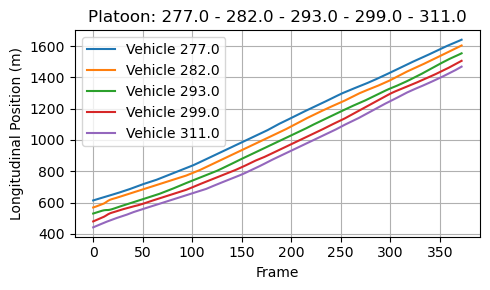

  Saved platoon to platoon_size=5/I-80/i-80_0040.csv
  Saved platoon to platoon_size=5/I-80/i-80_0041.csv
  Saved platoon to platoon_size=5/I-80/i-80_0042.csv
  Saved platoon to platoon_size=5/I-80/i-80_0043.csv
  Saved platoon to platoon_size=5/I-80/i-80_0044.csv
  Saved platoon to platoon_size=5/I-80/i-80_0045.csv
  Saved platoon to platoon_size=5/I-80/i-80_0046.csv
  Saved platoon to platoon_size=5/I-80/i-80_0047.csv
  Saved platoon to platoon_size=5/I-80/i-80_0048.csv
  Saved platoon to platoon_size=5/I-80/i-80_0049.csv
  Saved platoon to platoon_size=5/I-80/i-80_0050.csv
  Saved platoon to platoon_size=5/I-80/i-80_0051.csv
  Saved platoon to platoon_size=5/I-80/i-80_0052.csv
  Saved platoon to platoon_size=5/I-80/i-80_0053.csv
  Saved platoon to platoon_size=5/I-80/i-80_0054.csv
  Saved platoon to platoon_size=5/I-80/i-80_0055.csv
  Saved platoon to platoon_size=5/I-80/i-80_0056.csv
  Saved platoon to platoon_size=5/I-80/i-80_0057.csv
  Saved platoon to platoon_size=5/I-80/i-80_00

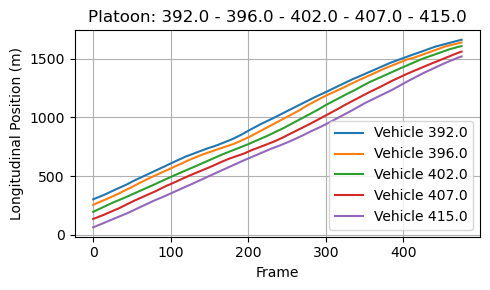

  Saved platoon to platoon_size=5/I-80/i-80_0060.csv
  Saved platoon to platoon_size=5/I-80/i-80_0061.csv
  Saved platoon to platoon_size=5/I-80/i-80_0062.csv
  Saved platoon to platoon_size=5/I-80/i-80_0063.csv
  Saved platoon to platoon_size=5/I-80/i-80_0064.csv
  Saved platoon to platoon_size=5/I-80/i-80_0065.csv
  Saved platoon to platoon_size=5/I-80/i-80_0066.csv
  Saved platoon to platoon_size=5/I-80/i-80_0067.csv
  Saved platoon to platoon_size=5/I-80/i-80_0068.csv
  Saved platoon to platoon_size=5/I-80/i-80_0069.csv
  Saved platoon to platoon_size=5/I-80/i-80_0070.csv
  Saved platoon to platoon_size=5/I-80/i-80_0071.csv
  Saved platoon to platoon_size=5/I-80/i-80_0072.csv
  Saved platoon to platoon_size=5/I-80/i-80_0073.csv
  Saved platoon to platoon_size=5/I-80/i-80_0074.csv
  Saved platoon to platoon_size=5/I-80/i-80_0075.csv
  Saved platoon to platoon_size=5/I-80/i-80_0076.csv
  Saved platoon to platoon_size=5/I-80/i-80_0077.csv
  Saved platoon to platoon_size=5/I-80/i-80_00

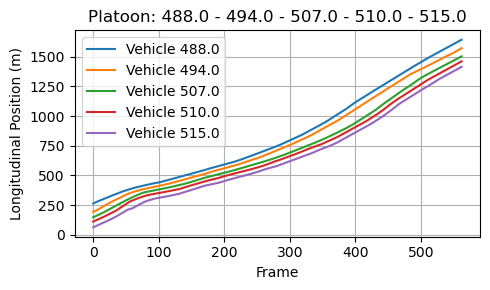

  Saved platoon to platoon_size=5/I-80/i-80_0080.csv
  Saved platoon to platoon_size=5/I-80/i-80_0081.csv
  Saved platoon to platoon_size=5/I-80/i-80_0082.csv
  Saved platoon to platoon_size=5/I-80/i-80_0083.csv
  Saved platoon to platoon_size=5/I-80/i-80_0084.csv
  Saved platoon to platoon_size=5/I-80/i-80_0085.csv
  Saved platoon to platoon_size=5/I-80/i-80_0086.csv
  Saved platoon to platoon_size=5/I-80/i-80_0087.csv
  Saved platoon to platoon_size=5/I-80/i-80_0088.csv
  Saved platoon to platoon_size=5/I-80/i-80_0089.csv
  Saved platoon to platoon_size=5/I-80/i-80_0090.csv
  Saved platoon to platoon_size=5/I-80/i-80_0091.csv
  Saved platoon to platoon_size=5/I-80/i-80_0092.csv
  Saved platoon to platoon_size=5/I-80/i-80_0093.csv
  Saved platoon to platoon_size=5/I-80/i-80_0094.csv
  Saved platoon to platoon_size=5/I-80/i-80_0095.csv
  Saved platoon to platoon_size=5/I-80/i-80_0096.csv
  Saved platoon to platoon_size=5/I-80/i-80_0097.csv
  Saved platoon to platoon_size=5/I-80/i-80_00

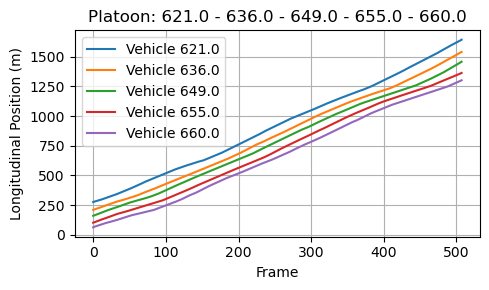

  Saved platoon to platoon_size=5/I-80/i-80_0100.csv
  Saved platoon to platoon_size=5/I-80/i-80_0101.csv
  Saved platoon to platoon_size=5/I-80/i-80_0102.csv
  Saved platoon to platoon_size=5/I-80/i-80_0103.csv
  Saved platoon to platoon_size=5/I-80/i-80_0104.csv
  Saved platoon to platoon_size=5/I-80/i-80_0105.csv
  Saved platoon to platoon_size=5/I-80/i-80_0106.csv
  Saved platoon to platoon_size=5/I-80/i-80_0107.csv
  Saved platoon to platoon_size=5/I-80/i-80_0108.csv
  Saved platoon to platoon_size=5/I-80/i-80_0109.csv
  Saved platoon to platoon_size=5/I-80/i-80_0110.csv
  Saved platoon to platoon_size=5/I-80/i-80_0111.csv
  Saved platoon to platoon_size=5/I-80/i-80_0112.csv
  Saved platoon to platoon_size=5/I-80/i-80_0113.csv
  Saved platoon to platoon_size=5/I-80/i-80_0114.csv
  Saved platoon to platoon_size=5/I-80/i-80_0115.csv
  Saved platoon to platoon_size=5/I-80/i-80_0116.csv
  Saved platoon to platoon_size=5/I-80/i-80_0117.csv
  Saved platoon to platoon_size=5/I-80/i-80_01

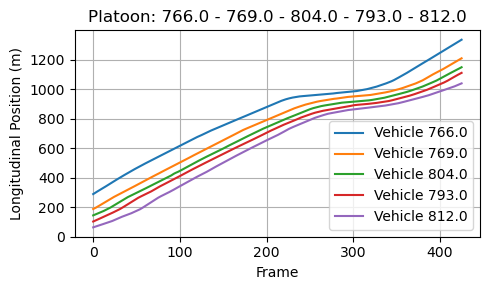

  Saved platoon to platoon_size=5/I-80/i-80_0120.csv
  Saved platoon to platoon_size=5/I-80/i-80_0121.csv
  Saved platoon to platoon_size=5/I-80/i-80_0122.csv
  Saved platoon to platoon_size=5/I-80/i-80_0123.csv
  Saved platoon to platoon_size=5/I-80/i-80_0124.csv
  Saved platoon to platoon_size=5/I-80/i-80_0125.csv
  Saved platoon to platoon_size=5/I-80/i-80_0126.csv
  Saved platoon to platoon_size=5/I-80/i-80_0127.csv
  Saved platoon to platoon_size=5/I-80/i-80_0128.csv
  Saved platoon to platoon_size=5/I-80/i-80_0129.csv
  Saved platoon to platoon_size=5/I-80/i-80_0130.csv
  Saved platoon to platoon_size=5/I-80/i-80_0131.csv
  Saved platoon to platoon_size=5/I-80/i-80_0132.csv
  Saved platoon to platoon_size=5/I-80/i-80_0133.csv
  Saved platoon to platoon_size=5/I-80/i-80_0134.csv
  Saved platoon to platoon_size=5/I-80/i-80_0135.csv
  Saved platoon to platoon_size=5/I-80/i-80_0136.csv
  Saved platoon to platoon_size=5/I-80/i-80_0137.csv
  Saved platoon to platoon_size=5/I-80/i-80_01

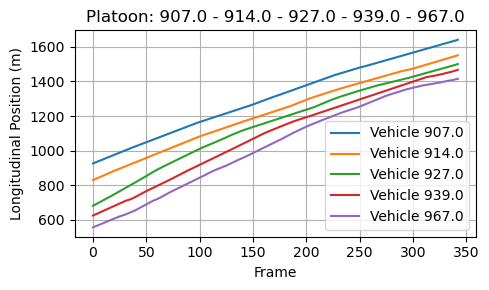

  Saved platoon to platoon_size=5/I-80/i-80_0140.csv
  Saved platoon to platoon_size=5/I-80/i-80_0141.csv
  Saved platoon to platoon_size=5/I-80/i-80_0142.csv
  Saved platoon to platoon_size=5/I-80/i-80_0143.csv
  Saved platoon to platoon_size=5/I-80/i-80_0144.csv
  Saved platoon to platoon_size=5/I-80/i-80_0145.csv
  Saved platoon to platoon_size=5/I-80/i-80_0146.csv
  Saved platoon to platoon_size=5/I-80/i-80_0147.csv
  Saved platoon to platoon_size=5/I-80/i-80_0148.csv
  Saved platoon to platoon_size=5/I-80/i-80_0149.csv
  Saved platoon to platoon_size=5/I-80/i-80_0150.csv
  Saved platoon to platoon_size=5/I-80/i-80_0151.csv
  Saved platoon to platoon_size=5/I-80/i-80_0152.csv
  Saved platoon to platoon_size=5/I-80/i-80_0153.csv
  Saved platoon to platoon_size=5/I-80/i-80_0154.csv
  Saved platoon to platoon_size=5/I-80/i-80_0155.csv
  Saved platoon to platoon_size=5/I-80/i-80_0156.csv
  Saved platoon to platoon_size=5/I-80/i-80_0157.csv
  Saved platoon to platoon_size=5/I-80/i-80_01

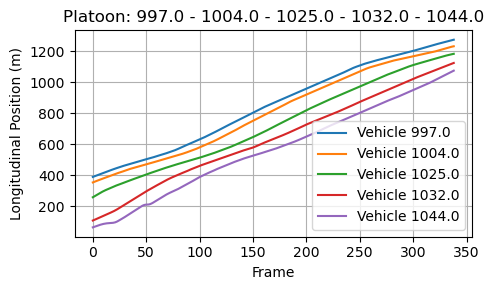

  Saved platoon to platoon_size=5/I-80/i-80_0160.csv
  Saved platoon to platoon_size=5/I-80/i-80_0161.csv
  Saved platoon to platoon_size=5/I-80/i-80_0162.csv
  Saved platoon to platoon_size=5/I-80/i-80_0163.csv
  Saved platoon to platoon_size=5/I-80/i-80_0164.csv
  Saved platoon to platoon_size=5/I-80/i-80_0165.csv
  Saved platoon to platoon_size=5/I-80/i-80_0166.csv
  Saved platoon to platoon_size=5/I-80/i-80_0167.csv
  Saved platoon to platoon_size=5/I-80/i-80_0168.csv
  Saved platoon to platoon_size=5/I-80/i-80_0169.csv
  Saved platoon to platoon_size=5/I-80/i-80_0170.csv
  Saved platoon to platoon_size=5/I-80/i-80_0171.csv
  Saved platoon to platoon_size=5/I-80/i-80_0172.csv
  Saved platoon to platoon_size=5/I-80/i-80_0173.csv
  Saved platoon to platoon_size=5/I-80/i-80_0174.csv
  Saved platoon to platoon_size=5/I-80/i-80_0175.csv
  Saved platoon to platoon_size=5/I-80/i-80_0176.csv
  Saved platoon to platoon_size=5/I-80/i-80_0177.csv
  Saved platoon to platoon_size=5/I-80/i-80_01

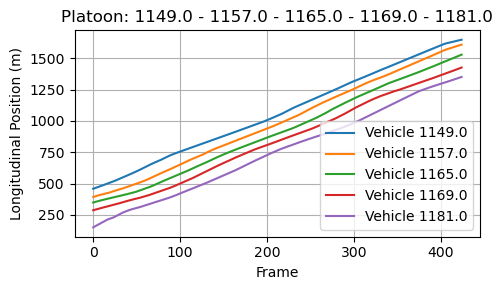

  Saved platoon to platoon_size=5/I-80/i-80_0180.csv
  Saved platoon to platoon_size=5/I-80/i-80_0181.csv
  Saved platoon to platoon_size=5/I-80/i-80_0182.csv
  Saved platoon to platoon_size=5/I-80/i-80_0183.csv
  Saved platoon to platoon_size=5/I-80/i-80_0184.csv
  Saved platoon to platoon_size=5/I-80/i-80_0185.csv
  Saved platoon to platoon_size=5/I-80/i-80_0186.csv
  Saved platoon to platoon_size=5/I-80/i-80_0187.csv
  Saved platoon to platoon_size=5/I-80/i-80_0188.csv
  Saved platoon to platoon_size=5/I-80/i-80_0189.csv
  Saved platoon to platoon_size=5/I-80/i-80_0190.csv
  Saved platoon to platoon_size=5/I-80/i-80_0191.csv
  Saved platoon to platoon_size=5/I-80/i-80_0192.csv
  Saved platoon to platoon_size=5/I-80/i-80_0193.csv
  Saved platoon to platoon_size=5/I-80/i-80_0194.csv
  Saved platoon to platoon_size=5/I-80/i-80_0195.csv
  Saved platoon to platoon_size=5/I-80/i-80_0196.csv
  Saved platoon to platoon_size=5/I-80/i-80_0197.csv
  Saved platoon to platoon_size=5/I-80/i-80_01

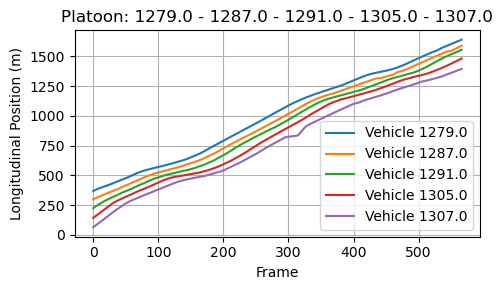

  Saved platoon to platoon_size=5/I-80/i-80_0200.csv
  Saved platoon to platoon_size=5/I-80/i-80_0201.csv
  Saved platoon to platoon_size=5/I-80/i-80_0202.csv
  Saved platoon to platoon_size=5/I-80/i-80_0203.csv
  Saved platoon to platoon_size=5/I-80/i-80_0204.csv
  Saved platoon to platoon_size=5/I-80/i-80_0205.csv
  Saved platoon to platoon_size=5/I-80/i-80_0206.csv
  Saved platoon to platoon_size=5/I-80/i-80_0207.csv
  Saved platoon to platoon_size=5/I-80/i-80_0208.csv
  Saved platoon to platoon_size=5/I-80/i-80_0209.csv
  Saved platoon to platoon_size=5/I-80/i-80_0210.csv
  Saved platoon to platoon_size=5/I-80/i-80_0211.csv
  Saved platoon to platoon_size=5/I-80/i-80_0212.csv
  Saved platoon to platoon_size=5/I-80/i-80_0213.csv
  Saved platoon to platoon_size=5/I-80/i-80_0214.csv
  Saved platoon to platoon_size=5/I-80/i-80_0215.csv
  Saved platoon to platoon_size=5/I-80/i-80_0216.csv
  Saved platoon to platoon_size=5/I-80/i-80_0217.csv
  Saved platoon to platoon_size=5/I-80/i-80_02

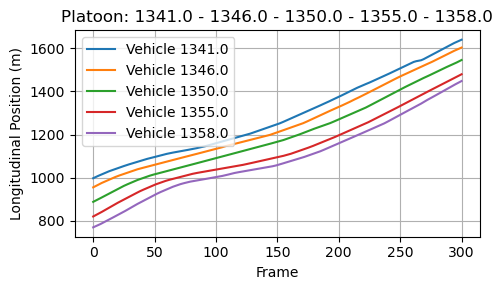

  Saved platoon to platoon_size=5/I-80/i-80_0220.csv
  Saved platoon to platoon_size=5/I-80/i-80_0221.csv
  Saved platoon to platoon_size=5/I-80/i-80_0222.csv
  Saved platoon to platoon_size=5/I-80/i-80_0223.csv
  Saved platoon to platoon_size=5/I-80/i-80_0224.csv
  Saved platoon to platoon_size=5/I-80/i-80_0225.csv
  Saved platoon to platoon_size=5/I-80/i-80_0226.csv
  Saved platoon to platoon_size=5/I-80/i-80_0227.csv
  Saved platoon to platoon_size=5/I-80/i-80_0228.csv
  Saved platoon to platoon_size=5/I-80/i-80_0229.csv
  Saved platoon to platoon_size=5/I-80/i-80_0230.csv
  Saved platoon to platoon_size=5/I-80/i-80_0231.csv
  Saved platoon to platoon_size=5/I-80/i-80_0232.csv
  Saved platoon to platoon_size=5/I-80/i-80_0233.csv
  Saved platoon to platoon_size=5/I-80/i-80_0234.csv
  Saved platoon to platoon_size=5/I-80/i-80_0235.csv
  Saved platoon to platoon_size=5/I-80/i-80_0236.csv
  Saved platoon to platoon_size=5/I-80/i-80_0237.csv
  Saved platoon to platoon_size=5/I-80/i-80_02

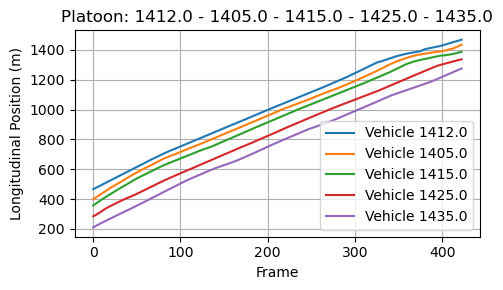

  Saved platoon to platoon_size=5/I-80/i-80_0240.csv
  Saved platoon to platoon_size=5/I-80/i-80_0241.csv
  Saved platoon to platoon_size=5/I-80/i-80_0242.csv
  Saved platoon to platoon_size=5/I-80/i-80_0243.csv
  Saved platoon to platoon_size=5/I-80/i-80_0244.csv
  Saved platoon to platoon_size=5/I-80/i-80_0245.csv
  Saved platoon to platoon_size=5/I-80/i-80_0246.csv
  Saved platoon to platoon_size=5/I-80/i-80_0247.csv
  Saved platoon to platoon_size=5/I-80/i-80_0248.csv
  Saved platoon to platoon_size=5/I-80/i-80_0249.csv
  Saved platoon to platoon_size=5/I-80/i-80_0250.csv
  Saved platoon to platoon_size=5/I-80/i-80_0251.csv
  Saved platoon to platoon_size=5/I-80/i-80_0252.csv
  Saved platoon to platoon_size=5/I-80/i-80_0253.csv
  Saved platoon to platoon_size=5/I-80/i-80_0254.csv
  Saved platoon to platoon_size=5/I-80/i-80_0255.csv
  Saved platoon to platoon_size=5/I-80/i-80_0256.csv
  Saved platoon to platoon_size=5/I-80/i-80_0257.csv
  Saved platoon to platoon_size=5/I-80/i-80_02

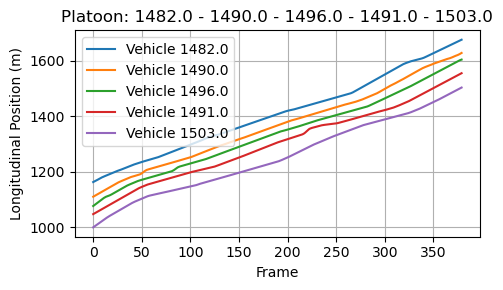

  Saved platoon to platoon_size=5/I-80/i-80_0260.csv
  Saved platoon to platoon_size=5/I-80/i-80_0261.csv
  Saved platoon to platoon_size=5/I-80/i-80_0262.csv
  Saved platoon to platoon_size=5/I-80/i-80_0263.csv
  Saved platoon to platoon_size=5/I-80/i-80_0264.csv
  Saved platoon to platoon_size=5/I-80/i-80_0265.csv
  Saved platoon to platoon_size=5/I-80/i-80_0266.csv
  Saved platoon to platoon_size=5/I-80/i-80_0267.csv
  Saved platoon to platoon_size=5/I-80/i-80_0268.csv
  Saved platoon to platoon_size=5/I-80/i-80_0269.csv
  Saved platoon to platoon_size=5/I-80/i-80_0270.csv
  Saved platoon to platoon_size=5/I-80/i-80_0271.csv
  Saved platoon to platoon_size=5/I-80/i-80_0272.csv
  Saved platoon to platoon_size=5/I-80/i-80_0273.csv
  Saved platoon to platoon_size=5/I-80/i-80_0274.csv
  Saved platoon to platoon_size=5/I-80/i-80_0275.csv
  Saved platoon to platoon_size=5/I-80/i-80_0276.csv
  Saved platoon to platoon_size=5/I-80/i-80_0277.csv
  Saved platoon to platoon_size=5/I-80/i-80_02

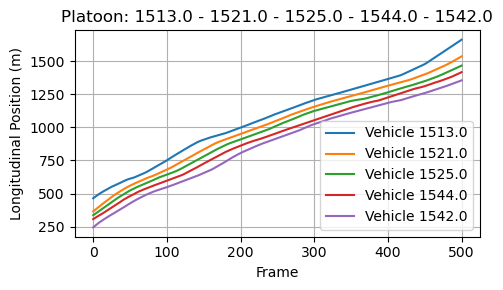

  Saved platoon to platoon_size=5/I-80/i-80_0280.csv
  Saved platoon to platoon_size=5/I-80/i-80_0281.csv
  Saved platoon to platoon_size=5/I-80/i-80_0282.csv
  Saved platoon to platoon_size=5/I-80/i-80_0283.csv
  Saved platoon to platoon_size=5/I-80/i-80_0284.csv
  Saved platoon to platoon_size=5/I-80/i-80_0285.csv
  Saved platoon to platoon_size=5/I-80/i-80_0286.csv
  Saved platoon to platoon_size=5/I-80/i-80_0287.csv
  Saved platoon to platoon_size=5/I-80/i-80_0288.csv
  Saved platoon to platoon_size=5/I-80/i-80_0289.csv
  Saved platoon to platoon_size=5/I-80/i-80_0290.csv
  Saved platoon to platoon_size=5/I-80/i-80_0291.csv
  Saved platoon to platoon_size=5/I-80/i-80_0292.csv
  Saved platoon to platoon_size=5/I-80/i-80_0293.csv
  Saved platoon to platoon_size=5/I-80/i-80_0294.csv
  Saved platoon to platoon_size=5/I-80/i-80_0295.csv
  Saved platoon to platoon_size=5/I-80/i-80_0296.csv
  Saved platoon to platoon_size=5/I-80/i-80_0297.csv
  Saved platoon to platoon_size=5/I-80/i-80_02

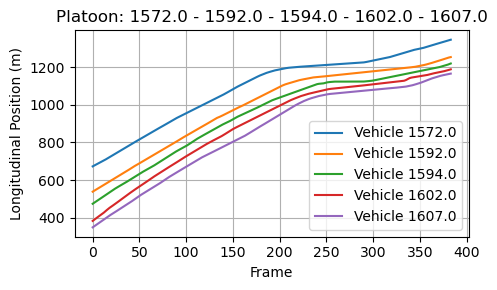

  Saved platoon to platoon_size=5/I-80/i-80_0300.csv
  Saved platoon to platoon_size=5/I-80/i-80_0301.csv
  Saved platoon to platoon_size=5/I-80/i-80_0302.csv
  Saved platoon to platoon_size=5/I-80/i-80_0303.csv
  Saved platoon to platoon_size=5/I-80/i-80_0304.csv
  Saved platoon to platoon_size=5/I-80/i-80_0305.csv
  Saved platoon to platoon_size=5/I-80/i-80_0306.csv
  Saved platoon to platoon_size=5/I-80/i-80_0307.csv
  Saved platoon to platoon_size=5/I-80/i-80_0308.csv
  Saved platoon to platoon_size=5/I-80/i-80_0309.csv
  Saved platoon to platoon_size=5/I-80/i-80_0310.csv
  Saved platoon to platoon_size=5/I-80/i-80_0311.csv
  Saved platoon to platoon_size=5/I-80/i-80_0312.csv
  Saved platoon to platoon_size=5/I-80/i-80_0313.csv
  Saved platoon to platoon_size=5/I-80/i-80_0314.csv
  Saved platoon to platoon_size=5/I-80/i-80_0315.csv
  Saved platoon to platoon_size=5/I-80/i-80_0316.csv
  Saved platoon to platoon_size=5/I-80/i-80_0317.csv
  Saved platoon to platoon_size=5/I-80/i-80_03

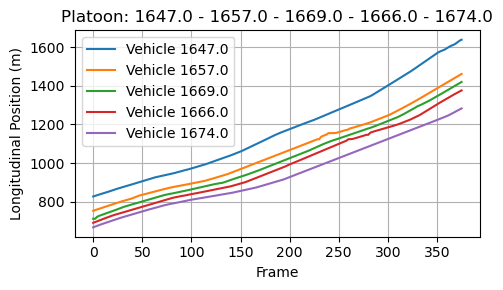

  Saved platoon to platoon_size=5/I-80/i-80_0320.csv
  Saved platoon to platoon_size=5/I-80/i-80_0321.csv
  Saved platoon to platoon_size=5/I-80/i-80_0322.csv
  Saved platoon to platoon_size=5/I-80/i-80_0323.csv
  Saved platoon to platoon_size=5/I-80/i-80_0324.csv
  Saved platoon to platoon_size=5/I-80/i-80_0325.csv
  Saved platoon to platoon_size=5/I-80/i-80_0326.csv
  Saved platoon to platoon_size=5/I-80/i-80_0327.csv
  Saved platoon to platoon_size=5/I-80/i-80_0328.csv
  Saved platoon to platoon_size=5/I-80/i-80_0329.csv
  Saved platoon to platoon_size=5/I-80/i-80_0330.csv
  Saved platoon to platoon_size=5/I-80/i-80_0331.csv
  Saved platoon to platoon_size=5/I-80/i-80_0332.csv
  Saved platoon to platoon_size=5/I-80/i-80_0333.csv
  Saved platoon to platoon_size=5/I-80/i-80_0334.csv
  Saved platoon to platoon_size=5/I-80/i-80_0335.csv
  Saved platoon to platoon_size=5/I-80/i-80_0336.csv
  Saved platoon to platoon_size=5/I-80/i-80_0337.csv
  Saved platoon to platoon_size=5/I-80/i-80_03

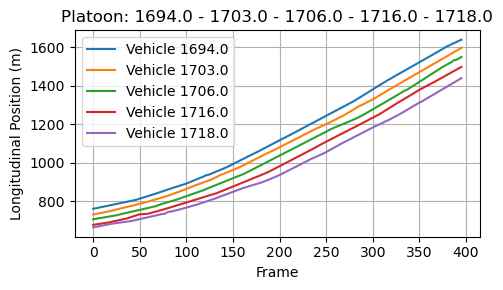

  Saved platoon to platoon_size=5/I-80/i-80_0340.csv
  Saved platoon to platoon_size=5/I-80/i-80_0341.csv
  Saved platoon to platoon_size=5/I-80/i-80_0342.csv
  Saved platoon to platoon_size=5/I-80/i-80_0343.csv
  Saved platoon to platoon_size=5/I-80/i-80_0344.csv
  Saved platoon to platoon_size=5/I-80/i-80_0345.csv
  Saved platoon to platoon_size=5/I-80/i-80_0346.csv
  Saved platoon to platoon_size=5/I-80/i-80_0347.csv
  Saved platoon to platoon_size=5/I-80/i-80_0348.csv
  Saved platoon to platoon_size=5/I-80/i-80_0349.csv
  Saved platoon to platoon_size=5/I-80/i-80_0350.csv
  Saved platoon to platoon_size=5/I-80/i-80_0351.csv
  Saved platoon to platoon_size=5/I-80/i-80_0352.csv
  Saved platoon to platoon_size=5/I-80/i-80_0353.csv
  Saved platoon to platoon_size=5/I-80/i-80_0354.csv
  Saved platoon to platoon_size=5/I-80/i-80_0355.csv
  Saved platoon to platoon_size=5/I-80/i-80_0356.csv
  Saved platoon to platoon_size=5/I-80/i-80_0357.csv
  Saved platoon to platoon_size=5/I-80/i-80_03

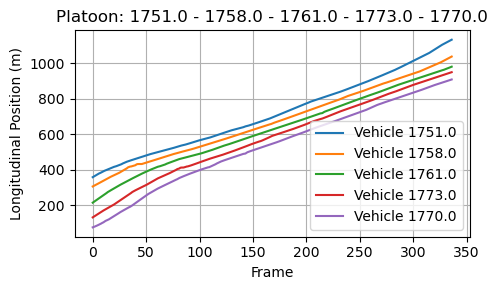

  Saved platoon to platoon_size=5/I-80/i-80_0360.csv
  Saved platoon to platoon_size=5/I-80/i-80_0361.csv
  Saved platoon to platoon_size=5/I-80/i-80_0362.csv
  Saved platoon to platoon_size=5/I-80/i-80_0363.csv
  Saved platoon to platoon_size=5/I-80/i-80_0364.csv
  Saved platoon to platoon_size=5/I-80/i-80_0365.csv
  Saved platoon to platoon_size=5/I-80/i-80_0366.csv
  Saved platoon to platoon_size=5/I-80/i-80_0367.csv
  Saved platoon to platoon_size=5/I-80/i-80_0368.csv
  Saved platoon to platoon_size=5/I-80/i-80_0369.csv
  Saved platoon to platoon_size=5/I-80/i-80_0370.csv
  Saved platoon to platoon_size=5/I-80/i-80_0371.csv
  Saved platoon to platoon_size=5/I-80/i-80_0372.csv
  Saved platoon to platoon_size=5/I-80/i-80_0373.csv
  Saved platoon to platoon_size=5/I-80/i-80_0374.csv
  Saved platoon to platoon_size=5/I-80/i-80_0375.csv
  Saved platoon to platoon_size=5/I-80/i-80_0376.csv
  Saved platoon to platoon_size=5/I-80/i-80_0377.csv
  Saved platoon to platoon_size=5/I-80/i-80_03

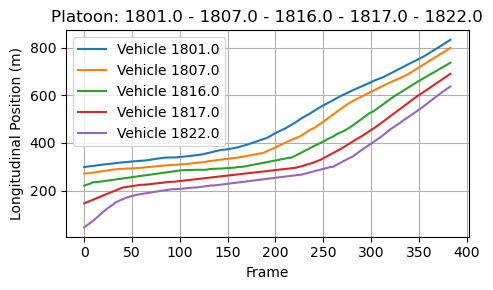

  Saved platoon to platoon_size=5/I-80/i-80_0380.csv
  Saved platoon to platoon_size=5/I-80/i-80_0381.csv
  Saved platoon to platoon_size=5/I-80/i-80_0382.csv
  Saved platoon to platoon_size=5/I-80/i-80_0383.csv
  Saved platoon to platoon_size=5/I-80/i-80_0384.csv
  Saved platoon to platoon_size=5/I-80/i-80_0385.csv
  Saved platoon to platoon_size=5/I-80/i-80_0386.csv
  Saved platoon to platoon_size=5/I-80/i-80_0387.csv
  Saved platoon to platoon_size=5/I-80/i-80_0388.csv
  Saved platoon to platoon_size=5/I-80/i-80_0389.csv
  Saved platoon to platoon_size=5/I-80/i-80_0390.csv
  Saved platoon to platoon_size=5/I-80/i-80_0391.csv
  Saved platoon to platoon_size=5/I-80/i-80_0392.csv
  Saved platoon to platoon_size=5/I-80/i-80_0393.csv
  Saved platoon to platoon_size=5/I-80/i-80_0394.csv
  Saved platoon to platoon_size=5/I-80/i-80_0395.csv
  Saved platoon to platoon_size=5/I-80/i-80_0396.csv
  Saved platoon to platoon_size=5/I-80/i-80_0397.csv
  Saved platoon to platoon_size=5/I-80/i-80_03

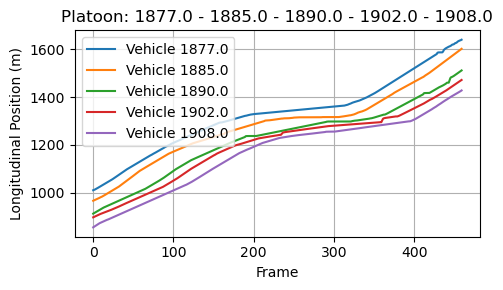

  Saved platoon to platoon_size=5/I-80/i-80_0400.csv
  Saved platoon to platoon_size=5/I-80/i-80_0401.csv
  Saved platoon to platoon_size=5/I-80/i-80_0402.csv
  Saved platoon to platoon_size=5/I-80/i-80_0403.csv
  Saved platoon to platoon_size=5/I-80/i-80_0404.csv
  Saved platoon to platoon_size=5/I-80/i-80_0405.csv
  Saved platoon to platoon_size=5/I-80/i-80_0406.csv
  Saved platoon to platoon_size=5/I-80/i-80_0407.csv
  Saved platoon to platoon_size=5/I-80/i-80_0408.csv
  Saved platoon to platoon_size=5/I-80/i-80_0409.csv
  Saved platoon to platoon_size=5/I-80/i-80_0410.csv
  Saved platoon to platoon_size=5/I-80/i-80_0411.csv
  Saved platoon to platoon_size=5/I-80/i-80_0412.csv
  Saved platoon to platoon_size=5/I-80/i-80_0413.csv
  Saved platoon to platoon_size=5/I-80/i-80_0414.csv
  Saved platoon to platoon_size=5/I-80/i-80_0415.csv
  Saved platoon to platoon_size=5/I-80/i-80_0416.csv
  Saved platoon to platoon_size=5/I-80/i-80_0417.csv
  Saved platoon to platoon_size=5/I-80/i-80_04

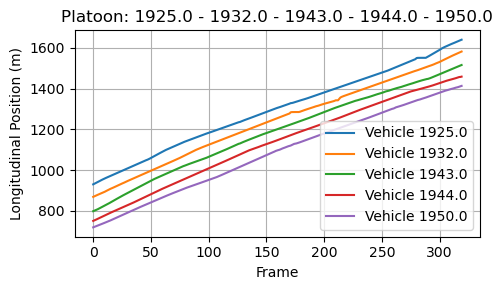

  Saved platoon to platoon_size=5/I-80/i-80_0420.csv
  Saved platoon to platoon_size=5/I-80/i-80_0421.csv
  Saved platoon to platoon_size=5/I-80/i-80_0422.csv
  Saved platoon to platoon_size=5/I-80/i-80_0423.csv
  Saved platoon to platoon_size=5/I-80/i-80_0424.csv
  Saved platoon to platoon_size=5/I-80/i-80_0425.csv
  Saved platoon to platoon_size=5/I-80/i-80_0426.csv
  Saved platoon to platoon_size=5/I-80/i-80_0427.csv
  Saved platoon to platoon_size=5/I-80/i-80_0428.csv
  Saved platoon to platoon_size=5/I-80/i-80_0429.csv
  Saved platoon to platoon_size=5/I-80/i-80_0430.csv
  Saved platoon to platoon_size=5/I-80/i-80_0431.csv
  Saved platoon to platoon_size=5/I-80/i-80_0432.csv
  Saved platoon to platoon_size=5/I-80/i-80_0433.csv
  Saved platoon to platoon_size=5/I-80/i-80_0434.csv
  Saved platoon to platoon_size=5/I-80/i-80_0435.csv
  Saved platoon to platoon_size=5/I-80/i-80_0436.csv
  Saved platoon to platoon_size=5/I-80/i-80_0437.csv
  Saved platoon to platoon_size=5/I-80/i-80_04

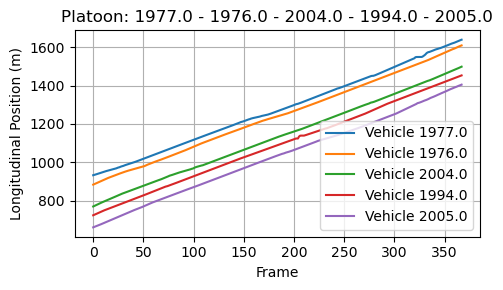

  Saved platoon to platoon_size=5/I-80/i-80_0440.csv
  Saved platoon to platoon_size=5/I-80/i-80_0441.csv
  Saved platoon to platoon_size=5/I-80/i-80_0442.csv
  Saved platoon to platoon_size=5/I-80/i-80_0443.csv
  Saved platoon to platoon_size=5/I-80/i-80_0444.csv
  Saved platoon to platoon_size=5/I-80/i-80_0445.csv
  Saved platoon to platoon_size=5/I-80/i-80_0446.csv
  Saved platoon to platoon_size=5/I-80/i-80_0447.csv
  Saved platoon to platoon_size=5/I-80/i-80_0448.csv
  Saved platoon to platoon_size=5/I-80/i-80_0449.csv
  Saved platoon to platoon_size=5/I-80/i-80_0450.csv
  Saved platoon to platoon_size=5/I-80/i-80_0451.csv
  Saved platoon to platoon_size=5/I-80/i-80_0452.csv
  Saved platoon to platoon_size=5/I-80/i-80_0453.csv
  Saved platoon to platoon_size=5/I-80/i-80_0454.csv
  Saved platoon to platoon_size=5/I-80/i-80_0455.csv
  Saved platoon to platoon_size=5/I-80/i-80_0456.csv
  Saved platoon to platoon_size=5/I-80/i-80_0457.csv
  Saved platoon to platoon_size=5/I-80/i-80_04

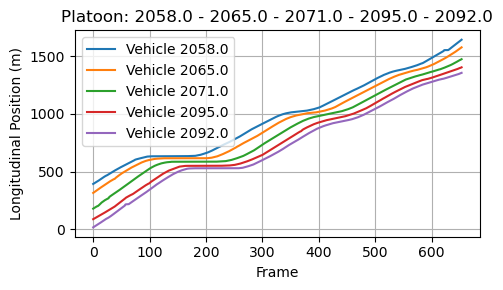

  Saved platoon to platoon_size=5/I-80/i-80_0460.csv
  Saved platoon to platoon_size=5/I-80/i-80_0461.csv
  Saved platoon to platoon_size=5/I-80/i-80_0462.csv
  Saved platoon to platoon_size=5/I-80/i-80_0463.csv
  Saved platoon to platoon_size=5/I-80/i-80_0464.csv
  Saved platoon to platoon_size=5/I-80/i-80_0465.csv
  Saved platoon to platoon_size=5/I-80/i-80_0466.csv
  Saved platoon to platoon_size=5/I-80/i-80_0467.csv
  Saved platoon to platoon_size=5/I-80/i-80_0468.csv
  Saved platoon to platoon_size=5/I-80/i-80_0469.csv
  Saved platoon to platoon_size=5/I-80/i-80_0470.csv
  Saved platoon to platoon_size=5/I-80/i-80_0471.csv
  Saved platoon to platoon_size=5/I-80/i-80_0472.csv
  Saved platoon to platoon_size=5/I-80/i-80_0473.csv
  Saved platoon to platoon_size=5/I-80/i-80_0474.csv
  Saved platoon to platoon_size=5/I-80/i-80_0475.csv
  Saved platoon to platoon_size=5/I-80/i-80_0476.csv
  Saved platoon to platoon_size=5/I-80/i-80_0477.csv
  Saved platoon to platoon_size=5/I-80/i-80_04

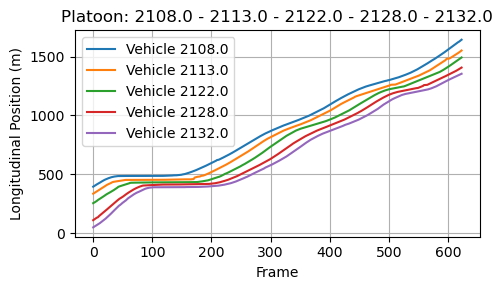

  Saved platoon to platoon_size=5/I-80/i-80_0480.csv
  Saved platoon to platoon_size=5/I-80/i-80_0481.csv
  Saved platoon to platoon_size=5/I-80/i-80_0482.csv
  Saved platoon to platoon_size=5/I-80/i-80_0483.csv
  Saved platoon to platoon_size=5/I-80/i-80_0484.csv
  Saved platoon to platoon_size=5/I-80/i-80_0485.csv
  Saved platoon to platoon_size=5/I-80/i-80_0486.csv
  Saved platoon to platoon_size=5/I-80/i-80_0487.csv
  Saved platoon to platoon_size=5/I-80/i-80_0488.csv
  Saved platoon to platoon_size=5/I-80/i-80_0489.csv
  Saved platoon to platoon_size=5/I-80/i-80_0490.csv
  Saved platoon to platoon_size=5/I-80/i-80_0491.csv
  Saved platoon to platoon_size=5/I-80/i-80_0492.csv
  Saved platoon to platoon_size=5/I-80/i-80_0493.csv
  Saved platoon to platoon_size=5/I-80/i-80_0494.csv
  Saved platoon to platoon_size=5/I-80/i-80_0495.csv
  Saved platoon to platoon_size=5/I-80/i-80_0496.csv
  Saved platoon to platoon_size=5/I-80/i-80_0497.csv
  Saved platoon to platoon_size=5/I-80/i-80_04

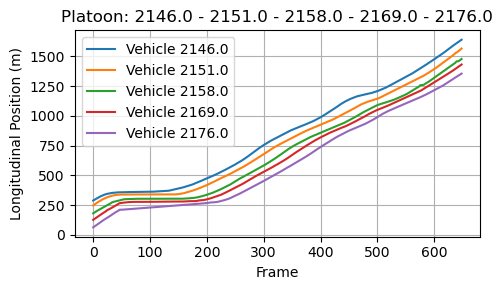

  Saved platoon to platoon_size=5/I-80/i-80_0500.csv
  Saved platoon to platoon_size=5/I-80/i-80_0501.csv
  Saved platoon to platoon_size=5/I-80/i-80_0502.csv
  Saved platoon to platoon_size=5/I-80/i-80_0503.csv
  Saved platoon to platoon_size=5/I-80/i-80_0504.csv
  Saved platoon to platoon_size=5/I-80/i-80_0505.csv
  Saved platoon to platoon_size=5/I-80/i-80_0506.csv
  Saved platoon to platoon_size=5/I-80/i-80_0507.csv
  Saved platoon to platoon_size=5/I-80/i-80_0508.csv
  Saved platoon to platoon_size=5/I-80/i-80_0509.csv
  Saved platoon to platoon_size=5/I-80/i-80_0510.csv
  Saved platoon to platoon_size=5/I-80/i-80_0511.csv
  Saved platoon to platoon_size=5/I-80/i-80_0512.csv
  Saved platoon to platoon_size=5/I-80/i-80_0513.csv
  Saved platoon to platoon_size=5/I-80/i-80_0514.csv
  Saved platoon to platoon_size=5/I-80/i-80_0515.csv
  Saved platoon to platoon_size=5/I-80/i-80_0516.csv
  Saved platoon to platoon_size=5/I-80/i-80_0517.csv
  Saved platoon to platoon_size=5/I-80/i-80_05

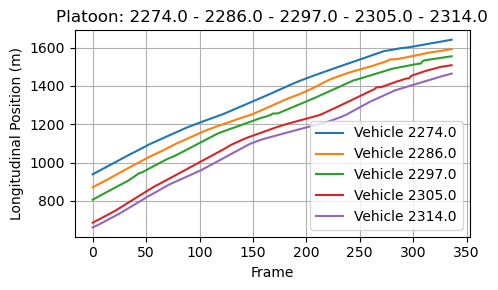

  Saved platoon to platoon_size=5/I-80/i-80_0520.csv
  Saved platoon to platoon_size=5/I-80/i-80_0521.csv
  Saved platoon to platoon_size=5/I-80/i-80_0522.csv
  Saved platoon to platoon_size=5/I-80/i-80_0523.csv
  Saved platoon to platoon_size=5/I-80/i-80_0524.csv
  Saved platoon to platoon_size=5/I-80/i-80_0525.csv
  Saved platoon to platoon_size=5/I-80/i-80_0526.csv
  Saved platoon to platoon_size=5/I-80/i-80_0527.csv
  Saved platoon to platoon_size=5/I-80/i-80_0528.csv
  Saved platoon to platoon_size=5/I-80/i-80_0529.csv
  Saved platoon to platoon_size=5/I-80/i-80_0530.csv
  Saved platoon to platoon_size=5/I-80/i-80_0531.csv
  Saved platoon to platoon_size=5/I-80/i-80_0532.csv
  Saved platoon to platoon_size=5/I-80/i-80_0533.csv
  Saved platoon to platoon_size=5/I-80/i-80_0534.csv
  Saved platoon to platoon_size=5/I-80/i-80_0535.csv
  Saved platoon to platoon_size=5/I-80/i-80_0536.csv
  Saved platoon to platoon_size=5/I-80/i-80_0537.csv
  Saved platoon to platoon_size=5/I-80/i-80_05

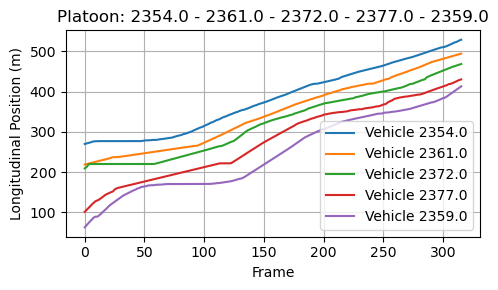

  Saved platoon to platoon_size=5/I-80/i-80_0540.csv
  Saved platoon to platoon_size=5/I-80/i-80_0541.csv
  Saved platoon to platoon_size=5/I-80/i-80_0542.csv
  Saved platoon to platoon_size=5/I-80/i-80_0543.csv
  Saved platoon to platoon_size=5/I-80/i-80_0544.csv
  Saved platoon to platoon_size=5/I-80/i-80_0545.csv
  Saved platoon to platoon_size=5/I-80/i-80_0546.csv
  Saved platoon to platoon_size=5/I-80/i-80_0547.csv
  Saved platoon to platoon_size=5/I-80/i-80_0548.csv
  Saved platoon to platoon_size=5/I-80/i-80_0549.csv
  Saved platoon to platoon_size=5/I-80/i-80_0550.csv
  Saved platoon to platoon_size=5/I-80/i-80_0551.csv
  Saved platoon to platoon_size=5/I-80/i-80_0552.csv
  Saved platoon to platoon_size=5/I-80/i-80_0553.csv
  Saved platoon to platoon_size=5/I-80/i-80_0554.csv
  Saved platoon to platoon_size=5/I-80/i-80_0555.csv
  Saved platoon to platoon_size=5/I-80/i-80_0556.csv
  Saved platoon to platoon_size=5/I-80/i-80_0557.csv
  Saved platoon to platoon_size=5/I-80/i-80_05

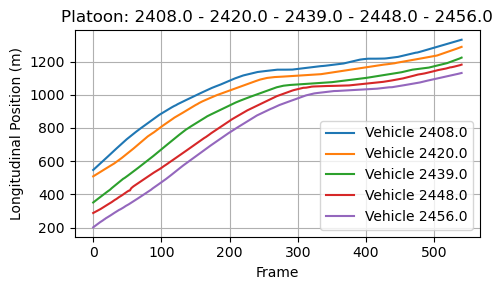

  Saved platoon to platoon_size=5/I-80/i-80_0560.csv
  Saved platoon to platoon_size=5/I-80/i-80_0561.csv
  Saved platoon to platoon_size=5/I-80/i-80_0562.csv
  Saved platoon to platoon_size=5/I-80/i-80_0563.csv
  Saved platoon to platoon_size=5/I-80/i-80_0564.csv
  Saved platoon to platoon_size=5/I-80/i-80_0565.csv
  Saved platoon to platoon_size=5/I-80/i-80_0566.csv
  Saved platoon to platoon_size=5/I-80/i-80_0567.csv
  Saved platoon to platoon_size=5/I-80/i-80_0568.csv
  Saved platoon to platoon_size=5/I-80/i-80_0569.csv
  Saved platoon to platoon_size=5/I-80/i-80_0570.csv
  Saved platoon to platoon_size=5/I-80/i-80_0571.csv
  Saved platoon to platoon_size=5/I-80/i-80_0572.csv
  Saved platoon to platoon_size=5/I-80/i-80_0573.csv
  Saved platoon to platoon_size=5/I-80/i-80_0574.csv
  Saved platoon to platoon_size=5/I-80/i-80_0575.csv
  Saved platoon to platoon_size=5/I-80/i-80_0576.csv
  Saved platoon to platoon_size=5/I-80/i-80_0577.csv
  Saved platoon to platoon_size=5/I-80/i-80_05

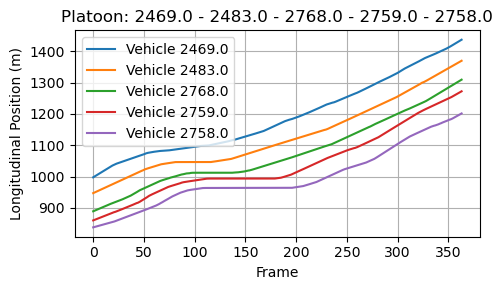

  Saved platoon to platoon_size=5/I-80/i-80_0580.csv
  Saved platoon to platoon_size=5/I-80/i-80_0581.csv
  Saved platoon to platoon_size=5/I-80/i-80_0582.csv
  Saved platoon to platoon_size=5/I-80/i-80_0583.csv
  Saved platoon to platoon_size=5/I-80/i-80_0584.csv
  Saved platoon to platoon_size=5/I-80/i-80_0585.csv
  Saved platoon to platoon_size=5/I-80/i-80_0586.csv
  Saved platoon to platoon_size=5/I-80/i-80_0587.csv
  Saved platoon to platoon_size=5/I-80/i-80_0588.csv
  Saved platoon to platoon_size=5/I-80/i-80_0589.csv
  Saved platoon to platoon_size=5/I-80/i-80_0590.csv
  Saved platoon to platoon_size=5/I-80/i-80_0591.csv
  Saved platoon to platoon_size=5/I-80/i-80_0592.csv
  Saved platoon to platoon_size=5/I-80/i-80_0593.csv
  Saved platoon to platoon_size=5/I-80/i-80_0594.csv
  Saved platoon to platoon_size=5/I-80/i-80_0595.csv
  Saved platoon to platoon_size=5/I-80/i-80_0596.csv
  Saved platoon to platoon_size=5/I-80/i-80_0597.csv
  Saved platoon to platoon_size=5/I-80/i-80_05

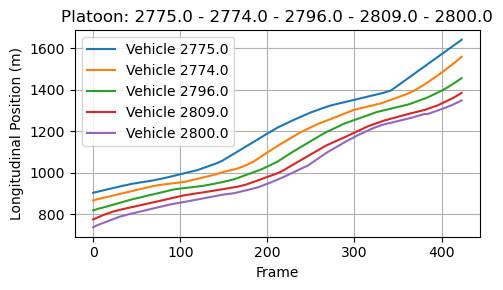

  Saved platoon to platoon_size=5/I-80/i-80_0600.csv
  Saved platoon to platoon_size=5/I-80/i-80_0601.csv
  Saved platoon to platoon_size=5/I-80/i-80_0602.csv
  Saved platoon to platoon_size=5/I-80/i-80_0603.csv
  Saved platoon to platoon_size=5/I-80/i-80_0604.csv
  Saved platoon to platoon_size=5/I-80/i-80_0605.csv
  Saved platoon to platoon_size=5/I-80/i-80_0606.csv
  Saved platoon to platoon_size=5/I-80/i-80_0607.csv
  Saved platoon to platoon_size=5/I-80/i-80_0608.csv
  Saved platoon to platoon_size=5/I-80/i-80_0609.csv
  Saved platoon to platoon_size=5/I-80/i-80_0610.csv
  Saved platoon to platoon_size=5/I-80/i-80_0611.csv
  Saved platoon to platoon_size=5/I-80/i-80_0612.csv
  Saved platoon to platoon_size=5/I-80/i-80_0613.csv
  Saved platoon to platoon_size=5/I-80/i-80_0614.csv
  Saved platoon to platoon_size=5/I-80/i-80_0615.csv
  Saved platoon to platoon_size=5/I-80/i-80_0616.csv
  Saved platoon to platoon_size=5/I-80/i-80_0617.csv
  Saved platoon to platoon_size=5/I-80/i-80_06

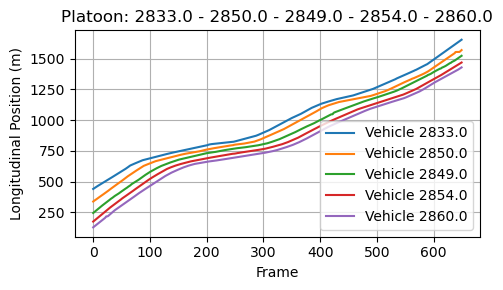

  Saved platoon to platoon_size=5/I-80/i-80_0620.csv
  Saved platoon to platoon_size=5/I-80/i-80_0621.csv
  Saved platoon to platoon_size=5/I-80/i-80_0622.csv
  Saved platoon to platoon_size=5/I-80/i-80_0623.csv
  Saved platoon to platoon_size=5/I-80/i-80_0624.csv
  Saved platoon to platoon_size=5/I-80/i-80_0625.csv
  Saved platoon to platoon_size=5/I-80/i-80_0626.csv
  Saved platoon to platoon_size=5/I-80/i-80_0627.csv
  Saved platoon to platoon_size=5/I-80/i-80_0628.csv
Processing file: data/I-80/trajectories-0500-0515.csv
  Found 782 platoon trajectories.
  Saved platoon to platoon_size=5/I-80/i-80_0629.csv
  Saved platoon to platoon_size=5/I-80/i-80_0630.csv
  Saved platoon to platoon_size=5/I-80/i-80_0631.csv
  Saved platoon to platoon_size=5/I-80/i-80_0632.csv
  Saved platoon to platoon_size=5/I-80/i-80_0633.csv
  Saved platoon to platoon_size=5/I-80/i-80_0634.csv
  Saved platoon to platoon_size=5/I-80/i-80_0635.csv
  Saved platoon to platoon_size=5/I-80/i-80_0636.csv
  Saved pla

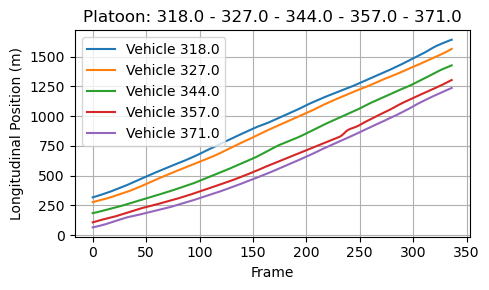

  Saved platoon to platoon_size=5/I-80/i-80_0640.csv
  Saved platoon to platoon_size=5/I-80/i-80_0641.csv
  Saved platoon to platoon_size=5/I-80/i-80_0642.csv
  Saved platoon to platoon_size=5/I-80/i-80_0643.csv
  Saved platoon to platoon_size=5/I-80/i-80_0644.csv
  Saved platoon to platoon_size=5/I-80/i-80_0645.csv
  Saved platoon to platoon_size=5/I-80/i-80_0646.csv
  Saved platoon to platoon_size=5/I-80/i-80_0647.csv
  Saved platoon to platoon_size=5/I-80/i-80_0648.csv
  Saved platoon to platoon_size=5/I-80/i-80_0649.csv
  Saved platoon to platoon_size=5/I-80/i-80_0650.csv
  Saved platoon to platoon_size=5/I-80/i-80_0651.csv
  Saved platoon to platoon_size=5/I-80/i-80_0652.csv
  Saved platoon to platoon_size=5/I-80/i-80_0653.csv
  Saved platoon to platoon_size=5/I-80/i-80_0654.csv
  Saved platoon to platoon_size=5/I-80/i-80_0655.csv
  Saved platoon to platoon_size=5/I-80/i-80_0656.csv
  Saved platoon to platoon_size=5/I-80/i-80_0657.csv
  Saved platoon to platoon_size=5/I-80/i-80_06

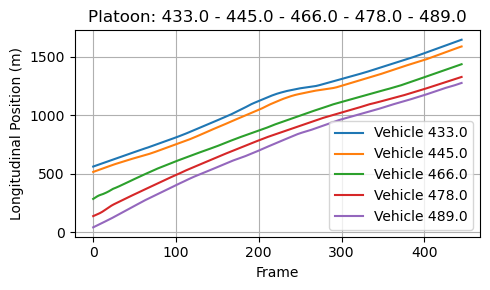

  Saved platoon to platoon_size=5/I-80/i-80_0660.csv
  Saved platoon to platoon_size=5/I-80/i-80_0661.csv
  Saved platoon to platoon_size=5/I-80/i-80_0662.csv
  Saved platoon to platoon_size=5/I-80/i-80_0663.csv
  Saved platoon to platoon_size=5/I-80/i-80_0664.csv
  Saved platoon to platoon_size=5/I-80/i-80_0665.csv
  Saved platoon to platoon_size=5/I-80/i-80_0666.csv
  Saved platoon to platoon_size=5/I-80/i-80_0667.csv
  Saved platoon to platoon_size=5/I-80/i-80_0668.csv
  Saved platoon to platoon_size=5/I-80/i-80_0669.csv
  Saved platoon to platoon_size=5/I-80/i-80_0670.csv
  Saved platoon to platoon_size=5/I-80/i-80_0671.csv
  Saved platoon to platoon_size=5/I-80/i-80_0672.csv
  Saved platoon to platoon_size=5/I-80/i-80_0673.csv
  Saved platoon to platoon_size=5/I-80/i-80_0674.csv
  Saved platoon to platoon_size=5/I-80/i-80_0675.csv
  Saved platoon to platoon_size=5/I-80/i-80_0676.csv
  Saved platoon to platoon_size=5/I-80/i-80_0677.csv
  Saved platoon to platoon_size=5/I-80/i-80_06

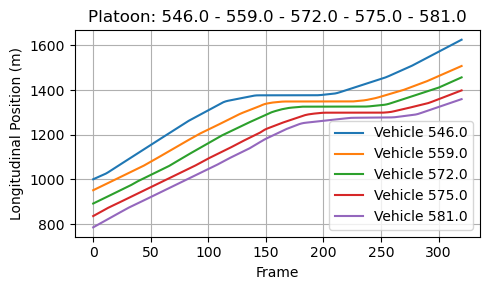

  Saved platoon to platoon_size=5/I-80/i-80_0680.csv
  Saved platoon to platoon_size=5/I-80/i-80_0681.csv
  Saved platoon to platoon_size=5/I-80/i-80_0682.csv
  Saved platoon to platoon_size=5/I-80/i-80_0683.csv
  Saved platoon to platoon_size=5/I-80/i-80_0684.csv
  Saved platoon to platoon_size=5/I-80/i-80_0685.csv
  Saved platoon to platoon_size=5/I-80/i-80_0686.csv
  Saved platoon to platoon_size=5/I-80/i-80_0687.csv
  Saved platoon to platoon_size=5/I-80/i-80_0688.csv
  Saved platoon to platoon_size=5/I-80/i-80_0689.csv
  Saved platoon to platoon_size=5/I-80/i-80_0690.csv
  Saved platoon to platoon_size=5/I-80/i-80_0691.csv
  Saved platoon to platoon_size=5/I-80/i-80_0692.csv
  Saved platoon to platoon_size=5/I-80/i-80_0693.csv
  Saved platoon to platoon_size=5/I-80/i-80_0694.csv
  Saved platoon to platoon_size=5/I-80/i-80_0695.csv
  Saved platoon to platoon_size=5/I-80/i-80_0696.csv
  Saved platoon to platoon_size=5/I-80/i-80_0697.csv
  Saved platoon to platoon_size=5/I-80/i-80_06

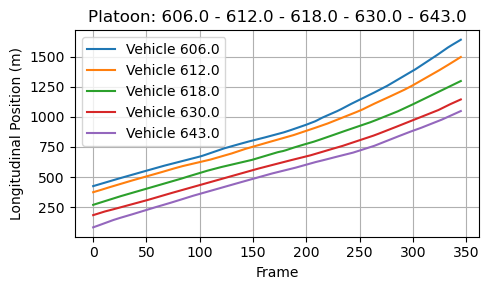

  Saved platoon to platoon_size=5/I-80/i-80_0700.csv
  Saved platoon to platoon_size=5/I-80/i-80_0701.csv
  Saved platoon to platoon_size=5/I-80/i-80_0702.csv
  Saved platoon to platoon_size=5/I-80/i-80_0703.csv
  Saved platoon to platoon_size=5/I-80/i-80_0704.csv
  Saved platoon to platoon_size=5/I-80/i-80_0705.csv
  Saved platoon to platoon_size=5/I-80/i-80_0706.csv
  Saved platoon to platoon_size=5/I-80/i-80_0707.csv
  Saved platoon to platoon_size=5/I-80/i-80_0708.csv
  Saved platoon to platoon_size=5/I-80/i-80_0709.csv
  Saved platoon to platoon_size=5/I-80/i-80_0710.csv
  Saved platoon to platoon_size=5/I-80/i-80_0711.csv
  Saved platoon to platoon_size=5/I-80/i-80_0712.csv
  Saved platoon to platoon_size=5/I-80/i-80_0713.csv
  Saved platoon to platoon_size=5/I-80/i-80_0714.csv
  Saved platoon to platoon_size=5/I-80/i-80_0715.csv
  Saved platoon to platoon_size=5/I-80/i-80_0716.csv
  Saved platoon to platoon_size=5/I-80/i-80_0717.csv
  Saved platoon to platoon_size=5/I-80/i-80_07

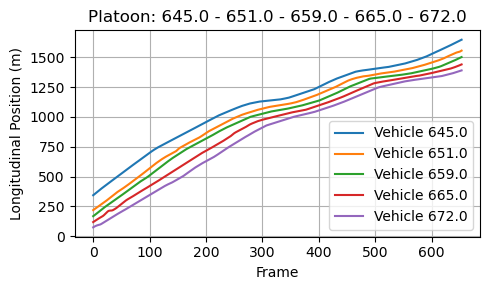

  Saved platoon to platoon_size=5/I-80/i-80_0720.csv
  Saved platoon to platoon_size=5/I-80/i-80_0721.csv
  Saved platoon to platoon_size=5/I-80/i-80_0722.csv
  Saved platoon to platoon_size=5/I-80/i-80_0723.csv
  Saved platoon to platoon_size=5/I-80/i-80_0724.csv
  Saved platoon to platoon_size=5/I-80/i-80_0725.csv
  Saved platoon to platoon_size=5/I-80/i-80_0726.csv
  Saved platoon to platoon_size=5/I-80/i-80_0727.csv
  Saved platoon to platoon_size=5/I-80/i-80_0728.csv
  Saved platoon to platoon_size=5/I-80/i-80_0729.csv
  Saved platoon to platoon_size=5/I-80/i-80_0730.csv
  Saved platoon to platoon_size=5/I-80/i-80_0731.csv
  Saved platoon to platoon_size=5/I-80/i-80_0732.csv
  Saved platoon to platoon_size=5/I-80/i-80_0733.csv
  Saved platoon to platoon_size=5/I-80/i-80_0734.csv
  Saved platoon to platoon_size=5/I-80/i-80_0735.csv
  Saved platoon to platoon_size=5/I-80/i-80_0736.csv
  Saved platoon to platoon_size=5/I-80/i-80_0737.csv
  Saved platoon to platoon_size=5/I-80/i-80_07

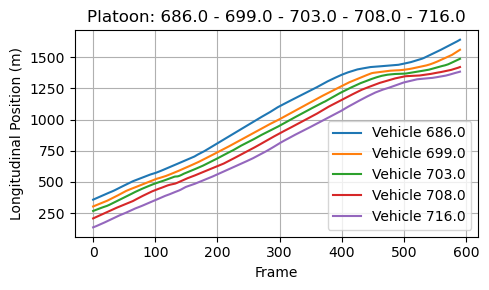

  Saved platoon to platoon_size=5/I-80/i-80_0740.csv
  Saved platoon to platoon_size=5/I-80/i-80_0741.csv
  Saved platoon to platoon_size=5/I-80/i-80_0742.csv
  Saved platoon to platoon_size=5/I-80/i-80_0743.csv
  Saved platoon to platoon_size=5/I-80/i-80_0744.csv
  Saved platoon to platoon_size=5/I-80/i-80_0745.csv
  Saved platoon to platoon_size=5/I-80/i-80_0746.csv
  Saved platoon to platoon_size=5/I-80/i-80_0747.csv
  Saved platoon to platoon_size=5/I-80/i-80_0748.csv
  Saved platoon to platoon_size=5/I-80/i-80_0749.csv
  Saved platoon to platoon_size=5/I-80/i-80_0750.csv
  Saved platoon to platoon_size=5/I-80/i-80_0751.csv
  Saved platoon to platoon_size=5/I-80/i-80_0752.csv
  Saved platoon to platoon_size=5/I-80/i-80_0753.csv
  Saved platoon to platoon_size=5/I-80/i-80_0754.csv
  Saved platoon to platoon_size=5/I-80/i-80_0755.csv
  Saved platoon to platoon_size=5/I-80/i-80_0756.csv
  Saved platoon to platoon_size=5/I-80/i-80_0757.csv
  Saved platoon to platoon_size=5/I-80/i-80_07

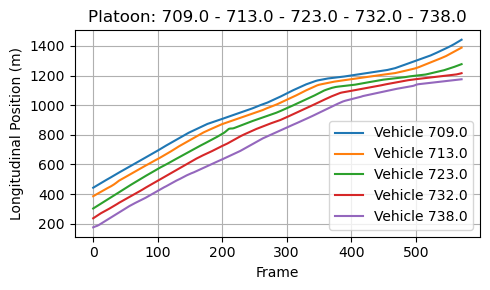

  Saved platoon to platoon_size=5/I-80/i-80_0760.csv
  Saved platoon to platoon_size=5/I-80/i-80_0761.csv
  Saved platoon to platoon_size=5/I-80/i-80_0762.csv
  Saved platoon to platoon_size=5/I-80/i-80_0763.csv
  Saved platoon to platoon_size=5/I-80/i-80_0764.csv
  Saved platoon to platoon_size=5/I-80/i-80_0765.csv
  Saved platoon to platoon_size=5/I-80/i-80_0766.csv
  Saved platoon to platoon_size=5/I-80/i-80_0767.csv
  Saved platoon to platoon_size=5/I-80/i-80_0768.csv
  Saved platoon to platoon_size=5/I-80/i-80_0769.csv
  Saved platoon to platoon_size=5/I-80/i-80_0770.csv
  Saved platoon to platoon_size=5/I-80/i-80_0771.csv
  Saved platoon to platoon_size=5/I-80/i-80_0772.csv
  Saved platoon to platoon_size=5/I-80/i-80_0773.csv
  Saved platoon to platoon_size=5/I-80/i-80_0774.csv
  Saved platoon to platoon_size=5/I-80/i-80_0775.csv
  Saved platoon to platoon_size=5/I-80/i-80_0776.csv
  Saved platoon to platoon_size=5/I-80/i-80_0777.csv
  Saved platoon to platoon_size=5/I-80/i-80_07

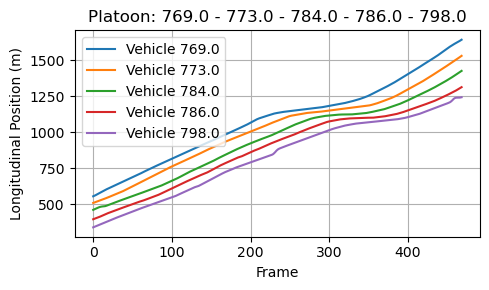

  Saved platoon to platoon_size=5/I-80/i-80_0780.csv
  Saved platoon to platoon_size=5/I-80/i-80_0781.csv
  Saved platoon to platoon_size=5/I-80/i-80_0782.csv
  Saved platoon to platoon_size=5/I-80/i-80_0783.csv
  Saved platoon to platoon_size=5/I-80/i-80_0784.csv
  Saved platoon to platoon_size=5/I-80/i-80_0785.csv
  Saved platoon to platoon_size=5/I-80/i-80_0786.csv
  Saved platoon to platoon_size=5/I-80/i-80_0787.csv
  Saved platoon to platoon_size=5/I-80/i-80_0788.csv
  Saved platoon to platoon_size=5/I-80/i-80_0789.csv
  Saved platoon to platoon_size=5/I-80/i-80_0790.csv
  Saved platoon to platoon_size=5/I-80/i-80_0791.csv
  Saved platoon to platoon_size=5/I-80/i-80_0792.csv
  Saved platoon to platoon_size=5/I-80/i-80_0793.csv
  Saved platoon to platoon_size=5/I-80/i-80_0794.csv
  Saved platoon to platoon_size=5/I-80/i-80_0795.csv
  Saved platoon to platoon_size=5/I-80/i-80_0796.csv
  Saved platoon to platoon_size=5/I-80/i-80_0797.csv
  Saved platoon to platoon_size=5/I-80/i-80_07

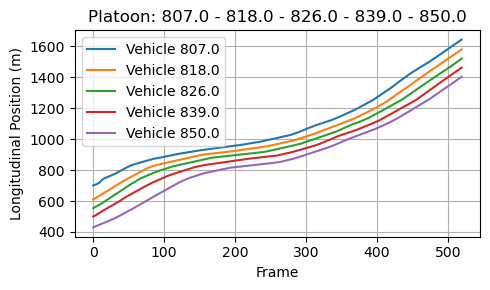

  Saved platoon to platoon_size=5/I-80/i-80_0800.csv
  Saved platoon to platoon_size=5/I-80/i-80_0801.csv
  Saved platoon to platoon_size=5/I-80/i-80_0802.csv
  Saved platoon to platoon_size=5/I-80/i-80_0803.csv
  Saved platoon to platoon_size=5/I-80/i-80_0804.csv
  Saved platoon to platoon_size=5/I-80/i-80_0805.csv
  Saved platoon to platoon_size=5/I-80/i-80_0806.csv
  Saved platoon to platoon_size=5/I-80/i-80_0807.csv
  Saved platoon to platoon_size=5/I-80/i-80_0808.csv
  Saved platoon to platoon_size=5/I-80/i-80_0809.csv
  Saved platoon to platoon_size=5/I-80/i-80_0810.csv
  Saved platoon to platoon_size=5/I-80/i-80_0811.csv
  Saved platoon to platoon_size=5/I-80/i-80_0812.csv
  Saved platoon to platoon_size=5/I-80/i-80_0813.csv
  Saved platoon to platoon_size=5/I-80/i-80_0814.csv
  Saved platoon to platoon_size=5/I-80/i-80_0815.csv
  Saved platoon to platoon_size=5/I-80/i-80_0816.csv
  Saved platoon to platoon_size=5/I-80/i-80_0817.csv
  Saved platoon to platoon_size=5/I-80/i-80_08

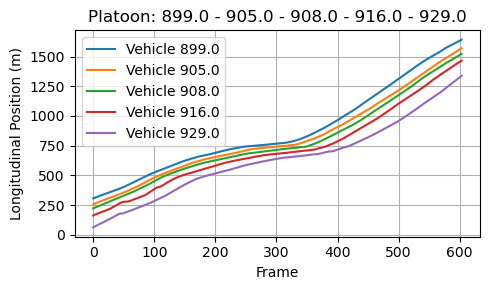

  Saved platoon to platoon_size=5/I-80/i-80_0820.csv
  Saved platoon to platoon_size=5/I-80/i-80_0821.csv
  Saved platoon to platoon_size=5/I-80/i-80_0822.csv
  Saved platoon to platoon_size=5/I-80/i-80_0823.csv
  Saved platoon to platoon_size=5/I-80/i-80_0824.csv
  Saved platoon to platoon_size=5/I-80/i-80_0825.csv
  Saved platoon to platoon_size=5/I-80/i-80_0826.csv
  Saved platoon to platoon_size=5/I-80/i-80_0827.csv
  Saved platoon to platoon_size=5/I-80/i-80_0828.csv
  Saved platoon to platoon_size=5/I-80/i-80_0829.csv
  Saved platoon to platoon_size=5/I-80/i-80_0830.csv
  Saved platoon to platoon_size=5/I-80/i-80_0831.csv
  Saved platoon to platoon_size=5/I-80/i-80_0832.csv
  Saved platoon to platoon_size=5/I-80/i-80_0833.csv
  Saved platoon to platoon_size=5/I-80/i-80_0834.csv
  Saved platoon to platoon_size=5/I-80/i-80_0835.csv
  Saved platoon to platoon_size=5/I-80/i-80_0836.csv
  Saved platoon to platoon_size=5/I-80/i-80_0837.csv
  Saved platoon to platoon_size=5/I-80/i-80_08

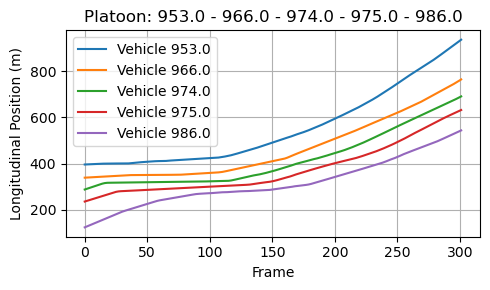

  Saved platoon to platoon_size=5/I-80/i-80_0840.csv
  Saved platoon to platoon_size=5/I-80/i-80_0841.csv
  Saved platoon to platoon_size=5/I-80/i-80_0842.csv
  Saved platoon to platoon_size=5/I-80/i-80_0843.csv
  Saved platoon to platoon_size=5/I-80/i-80_0844.csv
  Saved platoon to platoon_size=5/I-80/i-80_0845.csv
  Saved platoon to platoon_size=5/I-80/i-80_0846.csv
  Saved platoon to platoon_size=5/I-80/i-80_0847.csv
  Saved platoon to platoon_size=5/I-80/i-80_0848.csv
  Saved platoon to platoon_size=5/I-80/i-80_0849.csv
  Saved platoon to platoon_size=5/I-80/i-80_0850.csv
  Saved platoon to platoon_size=5/I-80/i-80_0851.csv
  Saved platoon to platoon_size=5/I-80/i-80_0852.csv
  Saved platoon to platoon_size=5/I-80/i-80_0853.csv
  Saved platoon to platoon_size=5/I-80/i-80_0854.csv
  Saved platoon to platoon_size=5/I-80/i-80_0855.csv
  Saved platoon to platoon_size=5/I-80/i-80_0856.csv
  Saved platoon to platoon_size=5/I-80/i-80_0857.csv
  Saved platoon to platoon_size=5/I-80/i-80_08

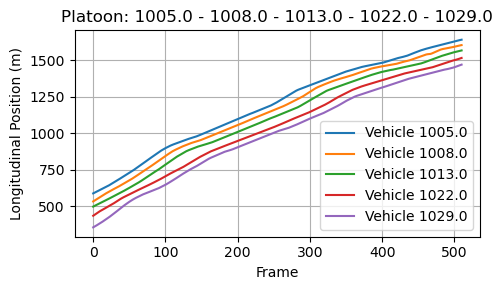

  Saved platoon to platoon_size=5/I-80/i-80_0860.csv
  Saved platoon to platoon_size=5/I-80/i-80_0861.csv
  Saved platoon to platoon_size=5/I-80/i-80_0862.csv
  Saved platoon to platoon_size=5/I-80/i-80_0863.csv
  Saved platoon to platoon_size=5/I-80/i-80_0864.csv
  Saved platoon to platoon_size=5/I-80/i-80_0865.csv
  Saved platoon to platoon_size=5/I-80/i-80_0866.csv
  Saved platoon to platoon_size=5/I-80/i-80_0867.csv
  Saved platoon to platoon_size=5/I-80/i-80_0868.csv
  Saved platoon to platoon_size=5/I-80/i-80_0869.csv
  Saved platoon to platoon_size=5/I-80/i-80_0870.csv
  Saved platoon to platoon_size=5/I-80/i-80_0871.csv
  Saved platoon to platoon_size=5/I-80/i-80_0872.csv
  Saved platoon to platoon_size=5/I-80/i-80_0873.csv
  Saved platoon to platoon_size=5/I-80/i-80_0874.csv
  Saved platoon to platoon_size=5/I-80/i-80_0875.csv
  Saved platoon to platoon_size=5/I-80/i-80_0876.csv
  Saved platoon to platoon_size=5/I-80/i-80_0877.csv
  Saved platoon to platoon_size=5/I-80/i-80_08

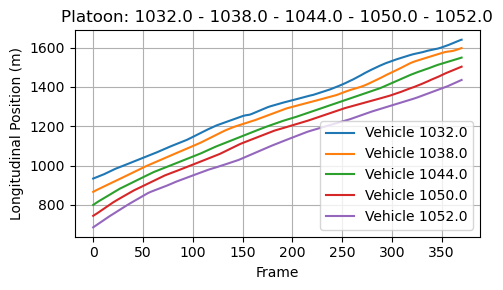

  Saved platoon to platoon_size=5/I-80/i-80_0880.csv
  Saved platoon to platoon_size=5/I-80/i-80_0881.csv
  Saved platoon to platoon_size=5/I-80/i-80_0882.csv
  Saved platoon to platoon_size=5/I-80/i-80_0883.csv
  Saved platoon to platoon_size=5/I-80/i-80_0884.csv
  Saved platoon to platoon_size=5/I-80/i-80_0885.csv
  Saved platoon to platoon_size=5/I-80/i-80_0886.csv
  Saved platoon to platoon_size=5/I-80/i-80_0887.csv
  Saved platoon to platoon_size=5/I-80/i-80_0888.csv
  Saved platoon to platoon_size=5/I-80/i-80_0889.csv
  Saved platoon to platoon_size=5/I-80/i-80_0890.csv
  Saved platoon to platoon_size=5/I-80/i-80_0891.csv
  Saved platoon to platoon_size=5/I-80/i-80_0892.csv
  Saved platoon to platoon_size=5/I-80/i-80_0893.csv
  Saved platoon to platoon_size=5/I-80/i-80_0894.csv
  Saved platoon to platoon_size=5/I-80/i-80_0895.csv
  Saved platoon to platoon_size=5/I-80/i-80_0896.csv
  Saved platoon to platoon_size=5/I-80/i-80_0897.csv
  Saved platoon to platoon_size=5/I-80/i-80_08

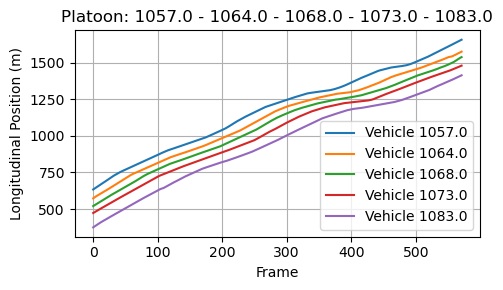

  Saved platoon to platoon_size=5/I-80/i-80_0900.csv
  Saved platoon to platoon_size=5/I-80/i-80_0901.csv
  Saved platoon to platoon_size=5/I-80/i-80_0902.csv
  Saved platoon to platoon_size=5/I-80/i-80_0903.csv
  Saved platoon to platoon_size=5/I-80/i-80_0904.csv
  Saved platoon to platoon_size=5/I-80/i-80_0905.csv
  Saved platoon to platoon_size=5/I-80/i-80_0906.csv
  Saved platoon to platoon_size=5/I-80/i-80_0907.csv
  Saved platoon to platoon_size=5/I-80/i-80_0908.csv
  Saved platoon to platoon_size=5/I-80/i-80_0909.csv
  Saved platoon to platoon_size=5/I-80/i-80_0910.csv
  Saved platoon to platoon_size=5/I-80/i-80_0911.csv
  Saved platoon to platoon_size=5/I-80/i-80_0912.csv
  Saved platoon to platoon_size=5/I-80/i-80_0913.csv
  Saved platoon to platoon_size=5/I-80/i-80_0914.csv
  Saved platoon to platoon_size=5/I-80/i-80_0915.csv
  Saved platoon to platoon_size=5/I-80/i-80_0916.csv
  Saved platoon to platoon_size=5/I-80/i-80_0917.csv
  Saved platoon to platoon_size=5/I-80/i-80_09

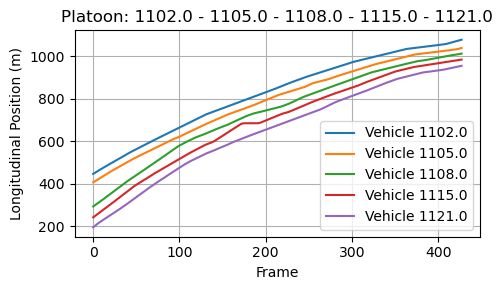

  Saved platoon to platoon_size=5/I-80/i-80_0920.csv
  Saved platoon to platoon_size=5/I-80/i-80_0921.csv
  Saved platoon to platoon_size=5/I-80/i-80_0922.csv
  Saved platoon to platoon_size=5/I-80/i-80_0923.csv
  Saved platoon to platoon_size=5/I-80/i-80_0924.csv
  Saved platoon to platoon_size=5/I-80/i-80_0925.csv
  Saved platoon to platoon_size=5/I-80/i-80_0926.csv
  Saved platoon to platoon_size=5/I-80/i-80_0927.csv
  Saved platoon to platoon_size=5/I-80/i-80_0928.csv
  Saved platoon to platoon_size=5/I-80/i-80_0929.csv
  Saved platoon to platoon_size=5/I-80/i-80_0930.csv
  Saved platoon to platoon_size=5/I-80/i-80_0931.csv
  Saved platoon to platoon_size=5/I-80/i-80_0932.csv
  Saved platoon to platoon_size=5/I-80/i-80_0933.csv
  Saved platoon to platoon_size=5/I-80/i-80_0934.csv
  Saved platoon to platoon_size=5/I-80/i-80_0935.csv
  Saved platoon to platoon_size=5/I-80/i-80_0936.csv
  Saved platoon to platoon_size=5/I-80/i-80_0937.csv
  Saved platoon to platoon_size=5/I-80/i-80_09

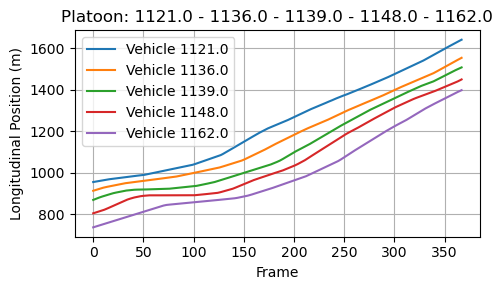

  Saved platoon to platoon_size=5/I-80/i-80_0940.csv
  Saved platoon to platoon_size=5/I-80/i-80_0941.csv
  Saved platoon to platoon_size=5/I-80/i-80_0942.csv
  Saved platoon to platoon_size=5/I-80/i-80_0943.csv
  Saved platoon to platoon_size=5/I-80/i-80_0944.csv
  Saved platoon to platoon_size=5/I-80/i-80_0945.csv
  Saved platoon to platoon_size=5/I-80/i-80_0946.csv
  Saved platoon to platoon_size=5/I-80/i-80_0947.csv
  Saved platoon to platoon_size=5/I-80/i-80_0948.csv
  Saved platoon to platoon_size=5/I-80/i-80_0949.csv
  Saved platoon to platoon_size=5/I-80/i-80_0950.csv
  Saved platoon to platoon_size=5/I-80/i-80_0951.csv
  Saved platoon to platoon_size=5/I-80/i-80_0952.csv
  Saved platoon to platoon_size=5/I-80/i-80_0953.csv
  Saved platoon to platoon_size=5/I-80/i-80_0954.csv
  Saved platoon to platoon_size=5/I-80/i-80_0955.csv
  Saved platoon to platoon_size=5/I-80/i-80_0956.csv
  Saved platoon to platoon_size=5/I-80/i-80_0957.csv
  Saved platoon to platoon_size=5/I-80/i-80_09

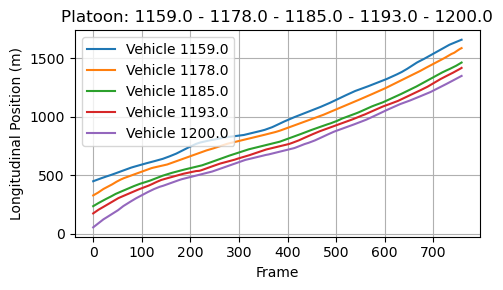

  Saved platoon to platoon_size=5/I-80/i-80_0960.csv
  Saved platoon to platoon_size=5/I-80/i-80_0961.csv
  Saved platoon to platoon_size=5/I-80/i-80_0962.csv
  Saved platoon to platoon_size=5/I-80/i-80_0963.csv
  Saved platoon to platoon_size=5/I-80/i-80_0964.csv
  Saved platoon to platoon_size=5/I-80/i-80_0965.csv
  Saved platoon to platoon_size=5/I-80/i-80_0966.csv
  Saved platoon to platoon_size=5/I-80/i-80_0967.csv
  Saved platoon to platoon_size=5/I-80/i-80_0968.csv
  Saved platoon to platoon_size=5/I-80/i-80_0969.csv
  Saved platoon to platoon_size=5/I-80/i-80_0970.csv
  Saved platoon to platoon_size=5/I-80/i-80_0971.csv
  Saved platoon to platoon_size=5/I-80/i-80_0972.csv
  Saved platoon to platoon_size=5/I-80/i-80_0973.csv
  Saved platoon to platoon_size=5/I-80/i-80_0974.csv
  Saved platoon to platoon_size=5/I-80/i-80_0975.csv
  Saved platoon to platoon_size=5/I-80/i-80_0976.csv
  Saved platoon to platoon_size=5/I-80/i-80_0977.csv
  Saved platoon to platoon_size=5/I-80/i-80_09

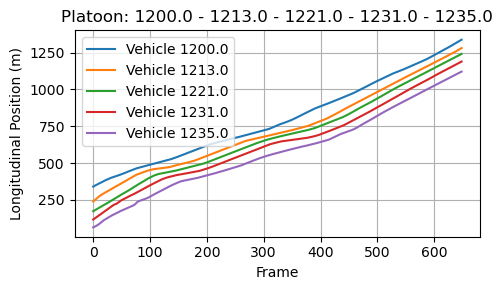

  Saved platoon to platoon_size=5/I-80/i-80_0980.csv
  Saved platoon to platoon_size=5/I-80/i-80_0981.csv
  Saved platoon to platoon_size=5/I-80/i-80_0982.csv
  Saved platoon to platoon_size=5/I-80/i-80_0983.csv
  Saved platoon to platoon_size=5/I-80/i-80_0984.csv
  Saved platoon to platoon_size=5/I-80/i-80_0985.csv
  Saved platoon to platoon_size=5/I-80/i-80_0986.csv
  Saved platoon to platoon_size=5/I-80/i-80_0987.csv
  Saved platoon to platoon_size=5/I-80/i-80_0988.csv
  Saved platoon to platoon_size=5/I-80/i-80_0989.csv
  Saved platoon to platoon_size=5/I-80/i-80_0990.csv
  Saved platoon to platoon_size=5/I-80/i-80_0991.csv
  Saved platoon to platoon_size=5/I-80/i-80_0992.csv
  Saved platoon to platoon_size=5/I-80/i-80_0993.csv
  Saved platoon to platoon_size=5/I-80/i-80_0994.csv
  Saved platoon to platoon_size=5/I-80/i-80_0995.csv
  Saved platoon to platoon_size=5/I-80/i-80_0996.csv
  Saved platoon to platoon_size=5/I-80/i-80_0997.csv
  Saved platoon to platoon_size=5/I-80/i-80_09

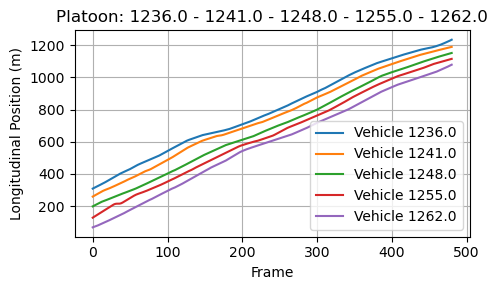

  Saved platoon to platoon_size=5/I-80/i-80_1000.csv
  Saved platoon to platoon_size=5/I-80/i-80_1001.csv
  Saved platoon to platoon_size=5/I-80/i-80_1002.csv
  Saved platoon to platoon_size=5/I-80/i-80_1003.csv
  Saved platoon to platoon_size=5/I-80/i-80_1004.csv
  Saved platoon to platoon_size=5/I-80/i-80_1005.csv
  Saved platoon to platoon_size=5/I-80/i-80_1006.csv
  Saved platoon to platoon_size=5/I-80/i-80_1007.csv
  Saved platoon to platoon_size=5/I-80/i-80_1008.csv
  Saved platoon to platoon_size=5/I-80/i-80_1009.csv
  Saved platoon to platoon_size=5/I-80/i-80_1010.csv
  Saved platoon to platoon_size=5/I-80/i-80_1011.csv
  Saved platoon to platoon_size=5/I-80/i-80_1012.csv
  Saved platoon to platoon_size=5/I-80/i-80_1013.csv
  Saved platoon to platoon_size=5/I-80/i-80_1014.csv
  Saved platoon to platoon_size=5/I-80/i-80_1015.csv
  Saved platoon to platoon_size=5/I-80/i-80_1016.csv
  Saved platoon to platoon_size=5/I-80/i-80_1017.csv
  Saved platoon to platoon_size=5/I-80/i-80_10

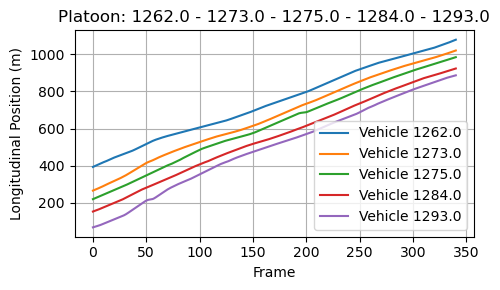

  Saved platoon to platoon_size=5/I-80/i-80_1020.csv
  Saved platoon to platoon_size=5/I-80/i-80_1021.csv
  Saved platoon to platoon_size=5/I-80/i-80_1022.csv
  Saved platoon to platoon_size=5/I-80/i-80_1023.csv
  Saved platoon to platoon_size=5/I-80/i-80_1024.csv
  Saved platoon to platoon_size=5/I-80/i-80_1025.csv
  Saved platoon to platoon_size=5/I-80/i-80_1026.csv
  Saved platoon to platoon_size=5/I-80/i-80_1027.csv
  Saved platoon to platoon_size=5/I-80/i-80_1028.csv
  Saved platoon to platoon_size=5/I-80/i-80_1029.csv
  Saved platoon to platoon_size=5/I-80/i-80_1030.csv
  Saved platoon to platoon_size=5/I-80/i-80_1031.csv
  Saved platoon to platoon_size=5/I-80/i-80_1032.csv
  Saved platoon to platoon_size=5/I-80/i-80_1033.csv
  Saved platoon to platoon_size=5/I-80/i-80_1034.csv
  Saved platoon to platoon_size=5/I-80/i-80_1035.csv
  Saved platoon to platoon_size=5/I-80/i-80_1036.csv
  Saved platoon to platoon_size=5/I-80/i-80_1037.csv
  Saved platoon to platoon_size=5/I-80/i-80_10

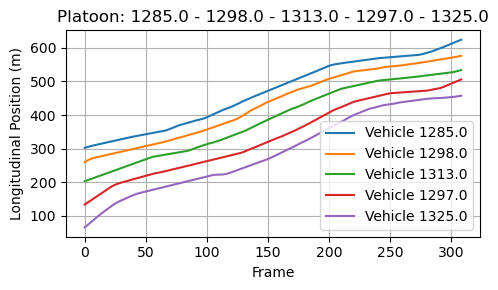

  Saved platoon to platoon_size=5/I-80/i-80_1040.csv
  Saved platoon to platoon_size=5/I-80/i-80_1041.csv
  Saved platoon to platoon_size=5/I-80/i-80_1042.csv
  Saved platoon to platoon_size=5/I-80/i-80_1043.csv
  Saved platoon to platoon_size=5/I-80/i-80_1044.csv
  Saved platoon to platoon_size=5/I-80/i-80_1045.csv
  Saved platoon to platoon_size=5/I-80/i-80_1046.csv
  Saved platoon to platoon_size=5/I-80/i-80_1047.csv
  Saved platoon to platoon_size=5/I-80/i-80_1048.csv
  Saved platoon to platoon_size=5/I-80/i-80_1049.csv
  Saved platoon to platoon_size=5/I-80/i-80_1050.csv
  Saved platoon to platoon_size=5/I-80/i-80_1051.csv
  Saved platoon to platoon_size=5/I-80/i-80_1052.csv
  Saved platoon to platoon_size=5/I-80/i-80_1053.csv
  Saved platoon to platoon_size=5/I-80/i-80_1054.csv
  Saved platoon to platoon_size=5/I-80/i-80_1055.csv
  Saved platoon to platoon_size=5/I-80/i-80_1056.csv
  Saved platoon to platoon_size=5/I-80/i-80_1057.csv
  Saved platoon to platoon_size=5/I-80/i-80_10

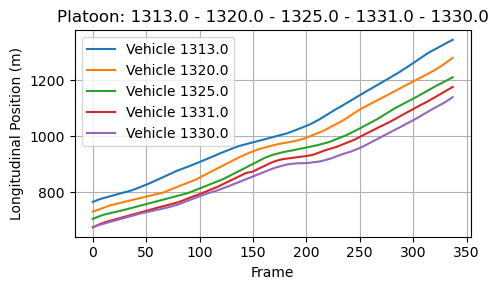

  Saved platoon to platoon_size=5/I-80/i-80_1060.csv
  Saved platoon to platoon_size=5/I-80/i-80_1061.csv
  Saved platoon to platoon_size=5/I-80/i-80_1062.csv
  Saved platoon to platoon_size=5/I-80/i-80_1063.csv
  Saved platoon to platoon_size=5/I-80/i-80_1064.csv
  Saved platoon to platoon_size=5/I-80/i-80_1065.csv
  Saved platoon to platoon_size=5/I-80/i-80_1066.csv
  Saved platoon to platoon_size=5/I-80/i-80_1067.csv
  Saved platoon to platoon_size=5/I-80/i-80_1068.csv
  Saved platoon to platoon_size=5/I-80/i-80_1069.csv
  Saved platoon to platoon_size=5/I-80/i-80_1070.csv
  Saved platoon to platoon_size=5/I-80/i-80_1071.csv
  Saved platoon to platoon_size=5/I-80/i-80_1072.csv
  Saved platoon to platoon_size=5/I-80/i-80_1073.csv
  Saved platoon to platoon_size=5/I-80/i-80_1074.csv
  Saved platoon to platoon_size=5/I-80/i-80_1075.csv
  Saved platoon to platoon_size=5/I-80/i-80_1076.csv
  Saved platoon to platoon_size=5/I-80/i-80_1077.csv
  Saved platoon to platoon_size=5/I-80/i-80_10

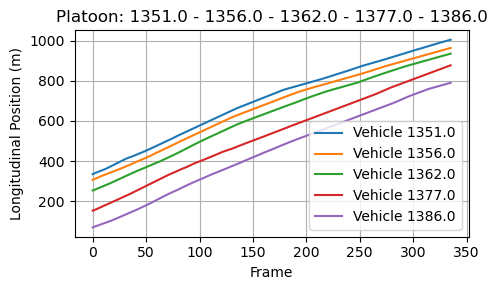

  Saved platoon to platoon_size=5/I-80/i-80_1080.csv
  Saved platoon to platoon_size=5/I-80/i-80_1081.csv
  Saved platoon to platoon_size=5/I-80/i-80_1082.csv
  Saved platoon to platoon_size=5/I-80/i-80_1083.csv
  Saved platoon to platoon_size=5/I-80/i-80_1084.csv
  Saved platoon to platoon_size=5/I-80/i-80_1085.csv
  Saved platoon to platoon_size=5/I-80/i-80_1086.csv
  Saved platoon to platoon_size=5/I-80/i-80_1087.csv
  Saved platoon to platoon_size=5/I-80/i-80_1088.csv
  Saved platoon to platoon_size=5/I-80/i-80_1089.csv
  Saved platoon to platoon_size=5/I-80/i-80_1090.csv
  Saved platoon to platoon_size=5/I-80/i-80_1091.csv
  Saved platoon to platoon_size=5/I-80/i-80_1092.csv
  Saved platoon to platoon_size=5/I-80/i-80_1093.csv
  Saved platoon to platoon_size=5/I-80/i-80_1094.csv
  Saved platoon to platoon_size=5/I-80/i-80_1095.csv
  Saved platoon to platoon_size=5/I-80/i-80_1096.csv
  Saved platoon to platoon_size=5/I-80/i-80_1097.csv
  Saved platoon to platoon_size=5/I-80/i-80_10

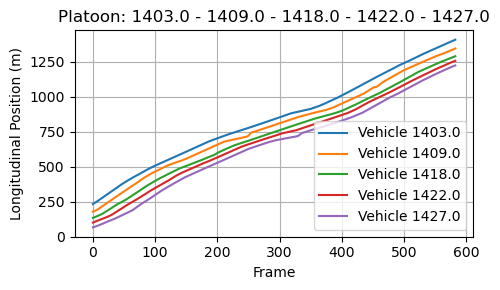

  Saved platoon to platoon_size=5/I-80/i-80_1100.csv
  Saved platoon to platoon_size=5/I-80/i-80_1101.csv
  Saved platoon to platoon_size=5/I-80/i-80_1102.csv
  Saved platoon to platoon_size=5/I-80/i-80_1103.csv
  Saved platoon to platoon_size=5/I-80/i-80_1104.csv
  Saved platoon to platoon_size=5/I-80/i-80_1105.csv
  Saved platoon to platoon_size=5/I-80/i-80_1106.csv
  Saved platoon to platoon_size=5/I-80/i-80_1107.csv
  Saved platoon to platoon_size=5/I-80/i-80_1108.csv
  Saved platoon to platoon_size=5/I-80/i-80_1109.csv
  Saved platoon to platoon_size=5/I-80/i-80_1110.csv
  Saved platoon to platoon_size=5/I-80/i-80_1111.csv
  Saved platoon to platoon_size=5/I-80/i-80_1112.csv
  Saved platoon to platoon_size=5/I-80/i-80_1113.csv
  Saved platoon to platoon_size=5/I-80/i-80_1114.csv
  Saved platoon to platoon_size=5/I-80/i-80_1115.csv
  Saved platoon to platoon_size=5/I-80/i-80_1116.csv
  Saved platoon to platoon_size=5/I-80/i-80_1117.csv
  Saved platoon to platoon_size=5/I-80/i-80_11

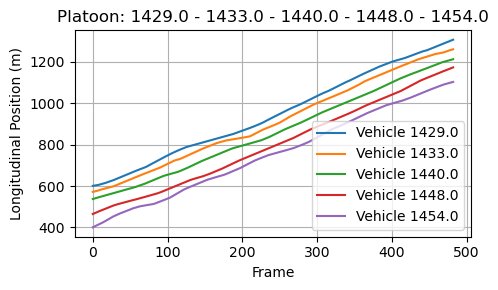

  Saved platoon to platoon_size=5/I-80/i-80_1120.csv
  Saved platoon to platoon_size=5/I-80/i-80_1121.csv
  Saved platoon to platoon_size=5/I-80/i-80_1122.csv
  Saved platoon to platoon_size=5/I-80/i-80_1123.csv
  Saved platoon to platoon_size=5/I-80/i-80_1124.csv
  Saved platoon to platoon_size=5/I-80/i-80_1125.csv
  Saved platoon to platoon_size=5/I-80/i-80_1126.csv
  Saved platoon to platoon_size=5/I-80/i-80_1127.csv
  Saved platoon to platoon_size=5/I-80/i-80_1128.csv
  Saved platoon to platoon_size=5/I-80/i-80_1129.csv
  Saved platoon to platoon_size=5/I-80/i-80_1130.csv
  Saved platoon to platoon_size=5/I-80/i-80_1131.csv
  Saved platoon to platoon_size=5/I-80/i-80_1132.csv
  Saved platoon to platoon_size=5/I-80/i-80_1133.csv
  Saved platoon to platoon_size=5/I-80/i-80_1134.csv
  Saved platoon to platoon_size=5/I-80/i-80_1135.csv
  Saved platoon to platoon_size=5/I-80/i-80_1136.csv
  Saved platoon to platoon_size=5/I-80/i-80_1137.csv
  Saved platoon to platoon_size=5/I-80/i-80_11

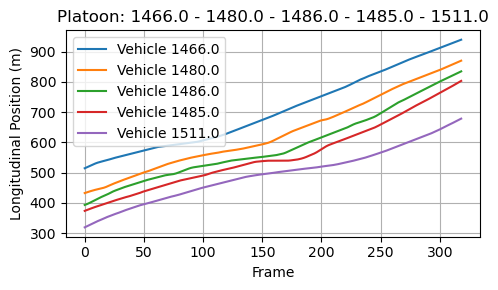

  Saved platoon to platoon_size=5/I-80/i-80_1140.csv
  Saved platoon to platoon_size=5/I-80/i-80_1141.csv
  Saved platoon to platoon_size=5/I-80/i-80_1142.csv
  Saved platoon to platoon_size=5/I-80/i-80_1143.csv
  Saved platoon to platoon_size=5/I-80/i-80_1144.csv
  Saved platoon to platoon_size=5/I-80/i-80_1145.csv
  Saved platoon to platoon_size=5/I-80/i-80_1146.csv
  Saved platoon to platoon_size=5/I-80/i-80_1147.csv
  Saved platoon to platoon_size=5/I-80/i-80_1148.csv
  Saved platoon to platoon_size=5/I-80/i-80_1149.csv
  Saved platoon to platoon_size=5/I-80/i-80_1150.csv
  Saved platoon to platoon_size=5/I-80/i-80_1151.csv
  Saved platoon to platoon_size=5/I-80/i-80_1152.csv
  Saved platoon to platoon_size=5/I-80/i-80_1153.csv
  Saved platoon to platoon_size=5/I-80/i-80_1154.csv
  Saved platoon to platoon_size=5/I-80/i-80_1155.csv
  Saved platoon to platoon_size=5/I-80/i-80_1156.csv
  Saved platoon to platoon_size=5/I-80/i-80_1157.csv
  Saved platoon to platoon_size=5/I-80/i-80_11

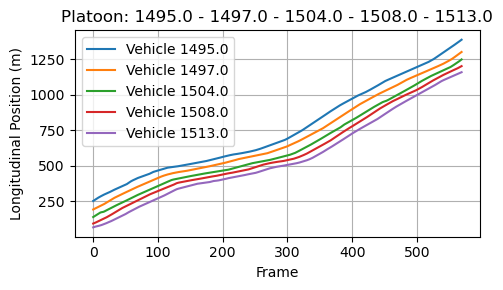

  Saved platoon to platoon_size=5/I-80/i-80_1160.csv
  Saved platoon to platoon_size=5/I-80/i-80_1161.csv
  Saved platoon to platoon_size=5/I-80/i-80_1162.csv
  Saved platoon to platoon_size=5/I-80/i-80_1163.csv
  Saved platoon to platoon_size=5/I-80/i-80_1164.csv
  Saved platoon to platoon_size=5/I-80/i-80_1165.csv
  Saved platoon to platoon_size=5/I-80/i-80_1166.csv
  Saved platoon to platoon_size=5/I-80/i-80_1167.csv
  Saved platoon to platoon_size=5/I-80/i-80_1168.csv
  Saved platoon to platoon_size=5/I-80/i-80_1169.csv
  Saved platoon to platoon_size=5/I-80/i-80_1170.csv
  Saved platoon to platoon_size=5/I-80/i-80_1171.csv
  Saved platoon to platoon_size=5/I-80/i-80_1172.csv
  Saved platoon to platoon_size=5/I-80/i-80_1173.csv
  Saved platoon to platoon_size=5/I-80/i-80_1174.csv
  Saved platoon to platoon_size=5/I-80/i-80_1175.csv
  Saved platoon to platoon_size=5/I-80/i-80_1176.csv
  Saved platoon to platoon_size=5/I-80/i-80_1177.csv
  Saved platoon to platoon_size=5/I-80/i-80_11

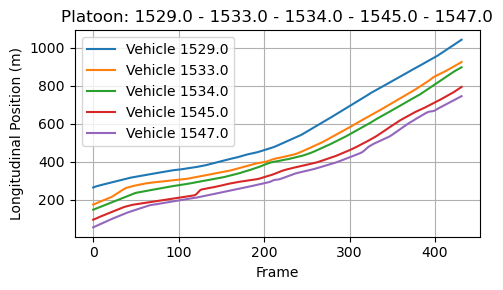

  Saved platoon to platoon_size=5/I-80/i-80_1180.csv
  Saved platoon to platoon_size=5/I-80/i-80_1181.csv
  Saved platoon to platoon_size=5/I-80/i-80_1182.csv
  Saved platoon to platoon_size=5/I-80/i-80_1183.csv
  Saved platoon to platoon_size=5/I-80/i-80_1184.csv
  Saved platoon to platoon_size=5/I-80/i-80_1185.csv
  Saved platoon to platoon_size=5/I-80/i-80_1186.csv
  Saved platoon to platoon_size=5/I-80/i-80_1187.csv
  Saved platoon to platoon_size=5/I-80/i-80_1188.csv
  Saved platoon to platoon_size=5/I-80/i-80_1189.csv
  Saved platoon to platoon_size=5/I-80/i-80_1190.csv
  Saved platoon to platoon_size=5/I-80/i-80_1191.csv
  Saved platoon to platoon_size=5/I-80/i-80_1192.csv
  Saved platoon to platoon_size=5/I-80/i-80_1193.csv
  Saved platoon to platoon_size=5/I-80/i-80_1194.csv
  Saved platoon to platoon_size=5/I-80/i-80_1195.csv
  Saved platoon to platoon_size=5/I-80/i-80_1196.csv
  Saved platoon to platoon_size=5/I-80/i-80_1197.csv
  Saved platoon to platoon_size=5/I-80/i-80_11

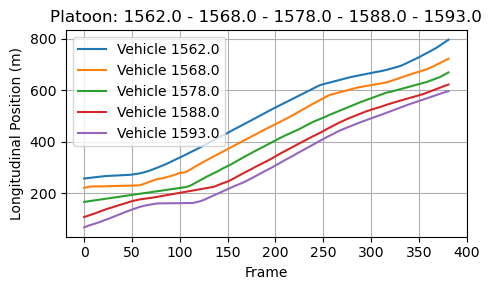

  Saved platoon to platoon_size=5/I-80/i-80_1200.csv
  Saved platoon to platoon_size=5/I-80/i-80_1201.csv
  Saved platoon to platoon_size=5/I-80/i-80_1202.csv
  Saved platoon to platoon_size=5/I-80/i-80_1203.csv
  Saved platoon to platoon_size=5/I-80/i-80_1204.csv
  Saved platoon to platoon_size=5/I-80/i-80_1205.csv
  Saved platoon to platoon_size=5/I-80/i-80_1206.csv
  Saved platoon to platoon_size=5/I-80/i-80_1207.csv
  Saved platoon to platoon_size=5/I-80/i-80_1208.csv
  Saved platoon to platoon_size=5/I-80/i-80_1209.csv
  Saved platoon to platoon_size=5/I-80/i-80_1210.csv
  Saved platoon to platoon_size=5/I-80/i-80_1211.csv
  Saved platoon to platoon_size=5/I-80/i-80_1212.csv
  Saved platoon to platoon_size=5/I-80/i-80_1213.csv
  Saved platoon to platoon_size=5/I-80/i-80_1214.csv
  Saved platoon to platoon_size=5/I-80/i-80_1215.csv
  Saved platoon to platoon_size=5/I-80/i-80_1216.csv
  Saved platoon to platoon_size=5/I-80/i-80_1217.csv
  Saved platoon to platoon_size=5/I-80/i-80_12

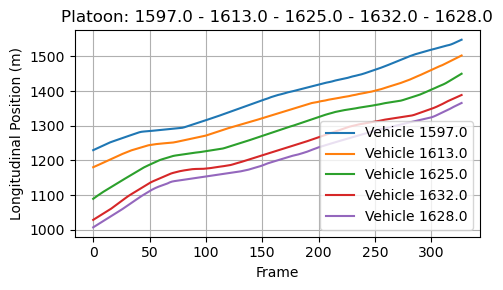

  Saved platoon to platoon_size=5/I-80/i-80_1220.csv
  Saved platoon to platoon_size=5/I-80/i-80_1221.csv
  Saved platoon to platoon_size=5/I-80/i-80_1222.csv
  Saved platoon to platoon_size=5/I-80/i-80_1223.csv
  Saved platoon to platoon_size=5/I-80/i-80_1224.csv
  Saved platoon to platoon_size=5/I-80/i-80_1225.csv
  Saved platoon to platoon_size=5/I-80/i-80_1226.csv
  Saved platoon to platoon_size=5/I-80/i-80_1227.csv
  Saved platoon to platoon_size=5/I-80/i-80_1228.csv
  Saved platoon to platoon_size=5/I-80/i-80_1229.csv
  Saved platoon to platoon_size=5/I-80/i-80_1230.csv
  Saved platoon to platoon_size=5/I-80/i-80_1231.csv
  Saved platoon to platoon_size=5/I-80/i-80_1232.csv
  Saved platoon to platoon_size=5/I-80/i-80_1233.csv
  Saved platoon to platoon_size=5/I-80/i-80_1234.csv
  Saved platoon to platoon_size=5/I-80/i-80_1235.csv
  Saved platoon to platoon_size=5/I-80/i-80_1236.csv
  Saved platoon to platoon_size=5/I-80/i-80_1237.csv
  Saved platoon to platoon_size=5/I-80/i-80_12

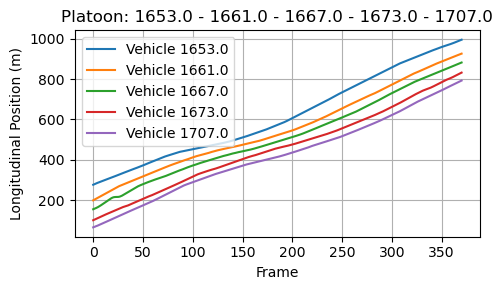

  Saved platoon to platoon_size=5/I-80/i-80_1240.csv
  Saved platoon to platoon_size=5/I-80/i-80_1241.csv
  Saved platoon to platoon_size=5/I-80/i-80_1242.csv
  Saved platoon to platoon_size=5/I-80/i-80_1243.csv
  Saved platoon to platoon_size=5/I-80/i-80_1244.csv
  Saved platoon to platoon_size=5/I-80/i-80_1245.csv
  Saved platoon to platoon_size=5/I-80/i-80_1246.csv
  Saved platoon to platoon_size=5/I-80/i-80_1247.csv
  Saved platoon to platoon_size=5/I-80/i-80_1248.csv
  Saved platoon to platoon_size=5/I-80/i-80_1249.csv
  Saved platoon to platoon_size=5/I-80/i-80_1250.csv
  Saved platoon to platoon_size=5/I-80/i-80_1251.csv
  Saved platoon to platoon_size=5/I-80/i-80_1252.csv
  Saved platoon to platoon_size=5/I-80/i-80_1253.csv
  Saved platoon to platoon_size=5/I-80/i-80_1254.csv
  Saved platoon to platoon_size=5/I-80/i-80_1255.csv
  Saved platoon to platoon_size=5/I-80/i-80_1256.csv
  Saved platoon to platoon_size=5/I-80/i-80_1257.csv
  Saved platoon to platoon_size=5/I-80/i-80_12

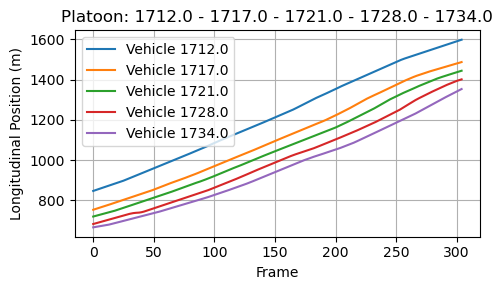

  Saved platoon to platoon_size=5/I-80/i-80_1260.csv
  Saved platoon to platoon_size=5/I-80/i-80_1261.csv
  Saved platoon to platoon_size=5/I-80/i-80_1262.csv
  Saved platoon to platoon_size=5/I-80/i-80_1263.csv
  Saved platoon to platoon_size=5/I-80/i-80_1264.csv
  Saved platoon to platoon_size=5/I-80/i-80_1265.csv
  Saved platoon to platoon_size=5/I-80/i-80_1266.csv
  Saved platoon to platoon_size=5/I-80/i-80_1267.csv
  Saved platoon to platoon_size=5/I-80/i-80_1268.csv
  Saved platoon to platoon_size=5/I-80/i-80_1269.csv
  Saved platoon to platoon_size=5/I-80/i-80_1270.csv
  Saved platoon to platoon_size=5/I-80/i-80_1271.csv
  Saved platoon to platoon_size=5/I-80/i-80_1272.csv
  Saved platoon to platoon_size=5/I-80/i-80_1273.csv
  Saved platoon to platoon_size=5/I-80/i-80_1274.csv
  Saved platoon to platoon_size=5/I-80/i-80_1275.csv
  Saved platoon to platoon_size=5/I-80/i-80_1276.csv
  Saved platoon to platoon_size=5/I-80/i-80_1277.csv
  Saved platoon to platoon_size=5/I-80/i-80_12

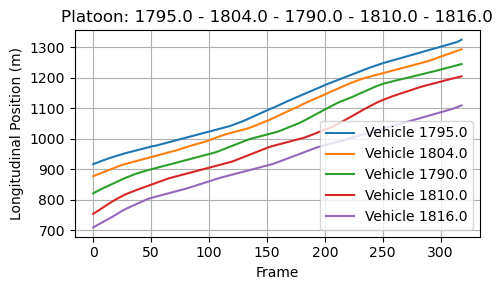

  Saved platoon to platoon_size=5/I-80/i-80_1280.csv
  Saved platoon to platoon_size=5/I-80/i-80_1281.csv
  Saved platoon to platoon_size=5/I-80/i-80_1282.csv
  Saved platoon to platoon_size=5/I-80/i-80_1283.csv
  Saved platoon to platoon_size=5/I-80/i-80_1284.csv
  Saved platoon to platoon_size=5/I-80/i-80_1285.csv
  Saved platoon to platoon_size=5/I-80/i-80_1286.csv
  Saved platoon to platoon_size=5/I-80/i-80_1287.csv
  Saved platoon to platoon_size=5/I-80/i-80_1288.csv
  Saved platoon to platoon_size=5/I-80/i-80_1289.csv
  Saved platoon to platoon_size=5/I-80/i-80_1290.csv
  Saved platoon to platoon_size=5/I-80/i-80_1291.csv
  Saved platoon to platoon_size=5/I-80/i-80_1292.csv
  Saved platoon to platoon_size=5/I-80/i-80_1293.csv
  Saved platoon to platoon_size=5/I-80/i-80_1294.csv
  Saved platoon to platoon_size=5/I-80/i-80_1295.csv
  Saved platoon to platoon_size=5/I-80/i-80_1296.csv
  Saved platoon to platoon_size=5/I-80/i-80_1297.csv
  Saved platoon to platoon_size=5/I-80/i-80_12

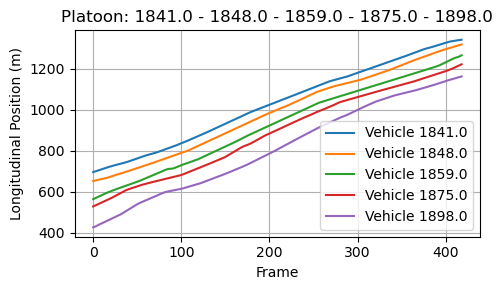

  Saved platoon to platoon_size=5/I-80/i-80_1300.csv
  Saved platoon to platoon_size=5/I-80/i-80_1301.csv
  Saved platoon to platoon_size=5/I-80/i-80_1302.csv
  Saved platoon to platoon_size=5/I-80/i-80_1303.csv
  Saved platoon to platoon_size=5/I-80/i-80_1304.csv
  Saved platoon to platoon_size=5/I-80/i-80_1305.csv
  Saved platoon to platoon_size=5/I-80/i-80_1306.csv
  Saved platoon to platoon_size=5/I-80/i-80_1307.csv
  Saved platoon to platoon_size=5/I-80/i-80_1308.csv
  Saved platoon to platoon_size=5/I-80/i-80_1309.csv
  Saved platoon to platoon_size=5/I-80/i-80_1310.csv
  Saved platoon to platoon_size=5/I-80/i-80_1311.csv
  Saved platoon to platoon_size=5/I-80/i-80_1312.csv
  Saved platoon to platoon_size=5/I-80/i-80_1313.csv
  Saved platoon to platoon_size=5/I-80/i-80_1314.csv
  Saved platoon to platoon_size=5/I-80/i-80_1315.csv
  Saved platoon to platoon_size=5/I-80/i-80_1316.csv
  Saved platoon to platoon_size=5/I-80/i-80_1317.csv
  Saved platoon to platoon_size=5/I-80/i-80_13

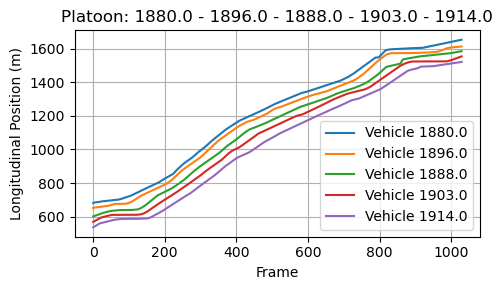

  Saved platoon to platoon_size=5/I-80/i-80_1320.csv
  Saved platoon to platoon_size=5/I-80/i-80_1321.csv
  Saved platoon to platoon_size=5/I-80/i-80_1322.csv
  Saved platoon to platoon_size=5/I-80/i-80_1323.csv
  Saved platoon to platoon_size=5/I-80/i-80_1324.csv
  Saved platoon to platoon_size=5/I-80/i-80_1325.csv
  Saved platoon to platoon_size=5/I-80/i-80_1326.csv
  Saved platoon to platoon_size=5/I-80/i-80_1327.csv
  Saved platoon to platoon_size=5/I-80/i-80_1328.csv
  Saved platoon to platoon_size=5/I-80/i-80_1329.csv
  Saved platoon to platoon_size=5/I-80/i-80_1330.csv
  Saved platoon to platoon_size=5/I-80/i-80_1331.csv
  Saved platoon to platoon_size=5/I-80/i-80_1332.csv
  Saved platoon to platoon_size=5/I-80/i-80_1333.csv
  Saved platoon to platoon_size=5/I-80/i-80_1334.csv
  Saved platoon to platoon_size=5/I-80/i-80_1335.csv
  Saved platoon to platoon_size=5/I-80/i-80_1336.csv
  Saved platoon to platoon_size=5/I-80/i-80_1337.csv
  Saved platoon to platoon_size=5/I-80/i-80_13

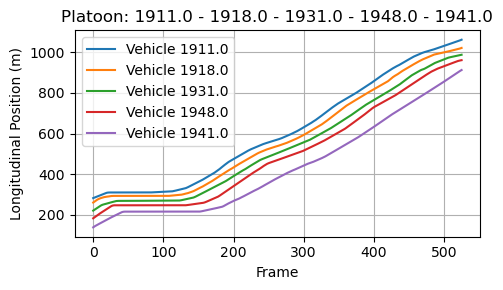

  Saved platoon to platoon_size=5/I-80/i-80_1340.csv
  Saved platoon to platoon_size=5/I-80/i-80_1341.csv
  Saved platoon to platoon_size=5/I-80/i-80_1342.csv
  Saved platoon to platoon_size=5/I-80/i-80_1343.csv
  Saved platoon to platoon_size=5/I-80/i-80_1344.csv
  Saved platoon to platoon_size=5/I-80/i-80_1345.csv
  Saved platoon to platoon_size=5/I-80/i-80_1346.csv
  Saved platoon to platoon_size=5/I-80/i-80_1347.csv
  Saved platoon to platoon_size=5/I-80/i-80_1348.csv
  Saved platoon to platoon_size=5/I-80/i-80_1349.csv
  Saved platoon to platoon_size=5/I-80/i-80_1350.csv
  Saved platoon to platoon_size=5/I-80/i-80_1351.csv
  Saved platoon to platoon_size=5/I-80/i-80_1352.csv
  Saved platoon to platoon_size=5/I-80/i-80_1353.csv
  Saved platoon to platoon_size=5/I-80/i-80_1354.csv
  Saved platoon to platoon_size=5/I-80/i-80_1355.csv
  Saved platoon to platoon_size=5/I-80/i-80_1356.csv
  Saved platoon to platoon_size=5/I-80/i-80_1357.csv
  Saved platoon to platoon_size=5/I-80/i-80_13

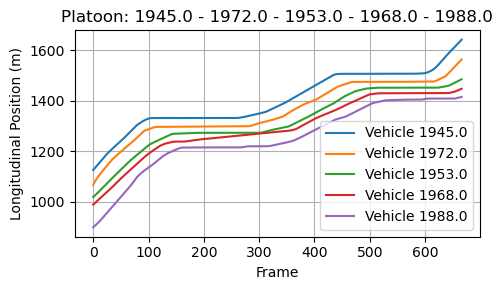

  Saved platoon to platoon_size=5/I-80/i-80_1360.csv
  Saved platoon to platoon_size=5/I-80/i-80_1361.csv
  Saved platoon to platoon_size=5/I-80/i-80_1362.csv
  Saved platoon to platoon_size=5/I-80/i-80_1363.csv
  Saved platoon to platoon_size=5/I-80/i-80_1364.csv
  Saved platoon to platoon_size=5/I-80/i-80_1365.csv
  Saved platoon to platoon_size=5/I-80/i-80_1366.csv
  Saved platoon to platoon_size=5/I-80/i-80_1367.csv
  Saved platoon to platoon_size=5/I-80/i-80_1368.csv
  Saved platoon to platoon_size=5/I-80/i-80_1369.csv
  Saved platoon to platoon_size=5/I-80/i-80_1370.csv
  Saved platoon to platoon_size=5/I-80/i-80_1371.csv
  Saved platoon to platoon_size=5/I-80/i-80_1372.csv
  Saved platoon to platoon_size=5/I-80/i-80_1373.csv
  Saved platoon to platoon_size=5/I-80/i-80_1374.csv
  Saved platoon to platoon_size=5/I-80/i-80_1375.csv
  Saved platoon to platoon_size=5/I-80/i-80_1376.csv
  Saved platoon to platoon_size=5/I-80/i-80_1377.csv
  Saved platoon to platoon_size=5/I-80/i-80_13

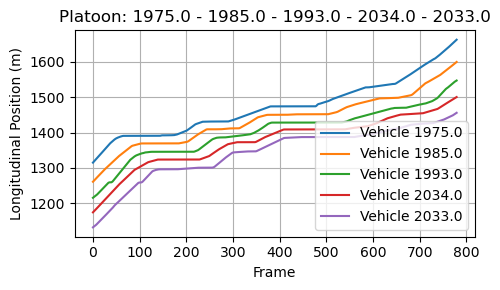

  Saved platoon to platoon_size=5/I-80/i-80_1380.csv
  Saved platoon to platoon_size=5/I-80/i-80_1381.csv
  Saved platoon to platoon_size=5/I-80/i-80_1382.csv
  Saved platoon to platoon_size=5/I-80/i-80_1383.csv
  Saved platoon to platoon_size=5/I-80/i-80_1384.csv
  Saved platoon to platoon_size=5/I-80/i-80_1385.csv
  Saved platoon to platoon_size=5/I-80/i-80_1386.csv
  Saved platoon to platoon_size=5/I-80/i-80_1387.csv
  Saved platoon to platoon_size=5/I-80/i-80_1388.csv
  Saved platoon to platoon_size=5/I-80/i-80_1389.csv
  Saved platoon to platoon_size=5/I-80/i-80_1390.csv
  Saved platoon to platoon_size=5/I-80/i-80_1391.csv
  Saved platoon to platoon_size=5/I-80/i-80_1392.csv
  Saved platoon to platoon_size=5/I-80/i-80_1393.csv
  Saved platoon to platoon_size=5/I-80/i-80_1394.csv
  Saved platoon to platoon_size=5/I-80/i-80_1395.csv
  Saved platoon to platoon_size=5/I-80/i-80_1396.csv
  Saved platoon to platoon_size=5/I-80/i-80_1397.csv
  Saved platoon to platoon_size=5/I-80/i-80_13

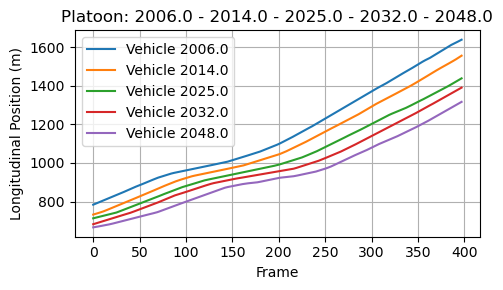

  Saved platoon to platoon_size=5/I-80/i-80_1400.csv
  Saved platoon to platoon_size=5/I-80/i-80_1401.csv
  Saved platoon to platoon_size=5/I-80/i-80_1402.csv
  Saved platoon to platoon_size=5/I-80/i-80_1403.csv
  Saved platoon to platoon_size=5/I-80/i-80_1404.csv
  Saved platoon to platoon_size=5/I-80/i-80_1405.csv
  Saved platoon to platoon_size=5/I-80/i-80_1406.csv
  Saved platoon to platoon_size=5/I-80/i-80_1407.csv
  Saved platoon to platoon_size=5/I-80/i-80_1408.csv
  Saved platoon to platoon_size=5/I-80/i-80_1409.csv
  Saved platoon to platoon_size=5/I-80/i-80_1410.csv
Processing file: data/I-80/trajectories-0515-0530.csv
  Found 803 platoon trajectories.
  Saved platoon to platoon_size=5/I-80/i-80_1411.csv
  Saved platoon to platoon_size=5/I-80/i-80_1412.csv
  Saved platoon to platoon_size=5/I-80/i-80_1413.csv
  Saved platoon to platoon_size=5/I-80/i-80_1414.csv
  Saved platoon to platoon_size=5/I-80/i-80_1415.csv
  Saved platoon to platoon_size=5/I-80/i-80_1416.csv
  Saved pla

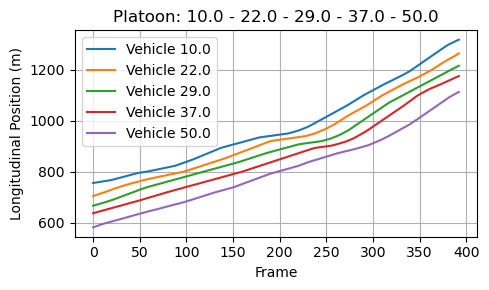

  Saved platoon to platoon_size=5/I-80/i-80_1420.csv
  Saved platoon to platoon_size=5/I-80/i-80_1421.csv
  Saved platoon to platoon_size=5/I-80/i-80_1422.csv
  Saved platoon to platoon_size=5/I-80/i-80_1423.csv
  Saved platoon to platoon_size=5/I-80/i-80_1424.csv
  Saved platoon to platoon_size=5/I-80/i-80_1425.csv
  Saved platoon to platoon_size=5/I-80/i-80_1426.csv
  Saved platoon to platoon_size=5/I-80/i-80_1427.csv
  Saved platoon to platoon_size=5/I-80/i-80_1428.csv
  Saved platoon to platoon_size=5/I-80/i-80_1429.csv
  Saved platoon to platoon_size=5/I-80/i-80_1430.csv
  Saved platoon to platoon_size=5/I-80/i-80_1431.csv
  Saved platoon to platoon_size=5/I-80/i-80_1432.csv
  Saved platoon to platoon_size=5/I-80/i-80_1433.csv
  Saved platoon to platoon_size=5/I-80/i-80_1434.csv
  Saved platoon to platoon_size=5/I-80/i-80_1435.csv
  Saved platoon to platoon_size=5/I-80/i-80_1436.csv
  Saved platoon to platoon_size=5/I-80/i-80_1437.csv
  Saved platoon to platoon_size=5/I-80/i-80_14

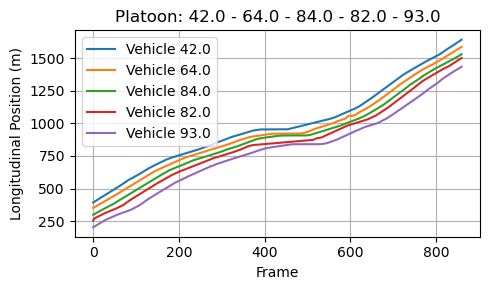

  Saved platoon to platoon_size=5/I-80/i-80_1440.csv
  Saved platoon to platoon_size=5/I-80/i-80_1441.csv
  Saved platoon to platoon_size=5/I-80/i-80_1442.csv
  Saved platoon to platoon_size=5/I-80/i-80_1443.csv
  Saved platoon to platoon_size=5/I-80/i-80_1444.csv
  Saved platoon to platoon_size=5/I-80/i-80_1445.csv
  Saved platoon to platoon_size=5/I-80/i-80_1446.csv
  Saved platoon to platoon_size=5/I-80/i-80_1447.csv
  Saved platoon to platoon_size=5/I-80/i-80_1448.csv
  Saved platoon to platoon_size=5/I-80/i-80_1449.csv
  Saved platoon to platoon_size=5/I-80/i-80_1450.csv
  Saved platoon to platoon_size=5/I-80/i-80_1451.csv
  Saved platoon to platoon_size=5/I-80/i-80_1452.csv
  Saved platoon to platoon_size=5/I-80/i-80_1453.csv
  Saved platoon to platoon_size=5/I-80/i-80_1454.csv
  Saved platoon to platoon_size=5/I-80/i-80_1455.csv
  Saved platoon to platoon_size=5/I-80/i-80_1456.csv
  Saved platoon to platoon_size=5/I-80/i-80_1457.csv
  Saved platoon to platoon_size=5/I-80/i-80_14

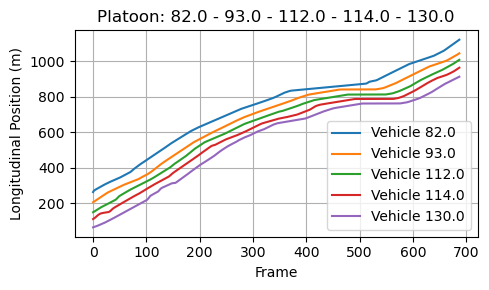

  Saved platoon to platoon_size=5/I-80/i-80_1460.csv
  Saved platoon to platoon_size=5/I-80/i-80_1461.csv
  Saved platoon to platoon_size=5/I-80/i-80_1462.csv
  Saved platoon to platoon_size=5/I-80/i-80_1463.csv
  Saved platoon to platoon_size=5/I-80/i-80_1464.csv
  Saved platoon to platoon_size=5/I-80/i-80_1465.csv
  Saved platoon to platoon_size=5/I-80/i-80_1466.csv
  Saved platoon to platoon_size=5/I-80/i-80_1467.csv
  Saved platoon to platoon_size=5/I-80/i-80_1468.csv
  Saved platoon to platoon_size=5/I-80/i-80_1469.csv
  Saved platoon to platoon_size=5/I-80/i-80_1470.csv
  Saved platoon to platoon_size=5/I-80/i-80_1471.csv
  Saved platoon to platoon_size=5/I-80/i-80_1472.csv
  Saved platoon to platoon_size=5/I-80/i-80_1473.csv
  Saved platoon to platoon_size=5/I-80/i-80_1474.csv
  Saved platoon to platoon_size=5/I-80/i-80_1475.csv
  Saved platoon to platoon_size=5/I-80/i-80_1476.csv
  Saved platoon to platoon_size=5/I-80/i-80_1477.csv
  Saved platoon to platoon_size=5/I-80/i-80_14

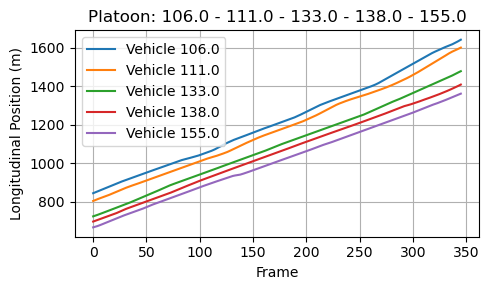

  Saved platoon to platoon_size=5/I-80/i-80_1480.csv
  Saved platoon to platoon_size=5/I-80/i-80_1481.csv
  Saved platoon to platoon_size=5/I-80/i-80_1482.csv
  Saved platoon to platoon_size=5/I-80/i-80_1483.csv
  Saved platoon to platoon_size=5/I-80/i-80_1484.csv
  Saved platoon to platoon_size=5/I-80/i-80_1485.csv
  Saved platoon to platoon_size=5/I-80/i-80_1486.csv
  Saved platoon to platoon_size=5/I-80/i-80_1487.csv
  Saved platoon to platoon_size=5/I-80/i-80_1488.csv
  Saved platoon to platoon_size=5/I-80/i-80_1489.csv
  Saved platoon to platoon_size=5/I-80/i-80_1490.csv
  Saved platoon to platoon_size=5/I-80/i-80_1491.csv
  Saved platoon to platoon_size=5/I-80/i-80_1492.csv
  Saved platoon to platoon_size=5/I-80/i-80_1493.csv
  Saved platoon to platoon_size=5/I-80/i-80_1494.csv
  Saved platoon to platoon_size=5/I-80/i-80_1495.csv
  Saved platoon to platoon_size=5/I-80/i-80_1496.csv
  Saved platoon to platoon_size=5/I-80/i-80_1497.csv
  Saved platoon to platoon_size=5/I-80/i-80_14

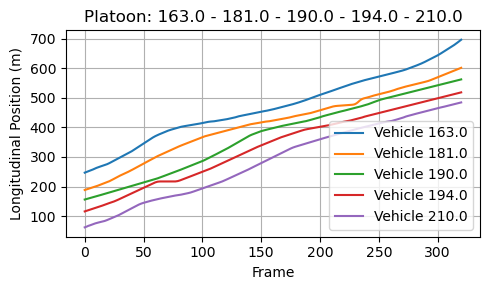

  Saved platoon to platoon_size=5/I-80/i-80_1500.csv
  Saved platoon to platoon_size=5/I-80/i-80_1501.csv
  Saved platoon to platoon_size=5/I-80/i-80_1502.csv
  Saved platoon to platoon_size=5/I-80/i-80_1503.csv
  Saved platoon to platoon_size=5/I-80/i-80_1504.csv
  Saved platoon to platoon_size=5/I-80/i-80_1505.csv
  Saved platoon to platoon_size=5/I-80/i-80_1506.csv
  Saved platoon to platoon_size=5/I-80/i-80_1507.csv
  Saved platoon to platoon_size=5/I-80/i-80_1508.csv
  Saved platoon to platoon_size=5/I-80/i-80_1509.csv
  Saved platoon to platoon_size=5/I-80/i-80_1510.csv
  Saved platoon to platoon_size=5/I-80/i-80_1511.csv
  Saved platoon to platoon_size=5/I-80/i-80_1512.csv
  Saved platoon to platoon_size=5/I-80/i-80_1513.csv
  Saved platoon to platoon_size=5/I-80/i-80_1514.csv
  Saved platoon to platoon_size=5/I-80/i-80_1515.csv
  Saved platoon to platoon_size=5/I-80/i-80_1516.csv
  Saved platoon to platoon_size=5/I-80/i-80_1517.csv
  Saved platoon to platoon_size=5/I-80/i-80_15

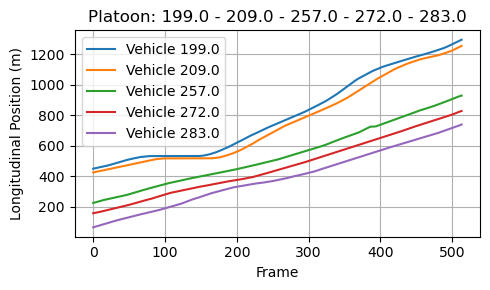

  Saved platoon to platoon_size=5/I-80/i-80_1520.csv
  Saved platoon to platoon_size=5/I-80/i-80_1521.csv
  Saved platoon to platoon_size=5/I-80/i-80_1522.csv
  Saved platoon to platoon_size=5/I-80/i-80_1523.csv
  Saved platoon to platoon_size=5/I-80/i-80_1524.csv
  Saved platoon to platoon_size=5/I-80/i-80_1525.csv
  Saved platoon to platoon_size=5/I-80/i-80_1526.csv
  Saved platoon to platoon_size=5/I-80/i-80_1527.csv
  Saved platoon to platoon_size=5/I-80/i-80_1528.csv
  Saved platoon to platoon_size=5/I-80/i-80_1529.csv
  Saved platoon to platoon_size=5/I-80/i-80_1530.csv
  Saved platoon to platoon_size=5/I-80/i-80_1531.csv
  Saved platoon to platoon_size=5/I-80/i-80_1532.csv
  Saved platoon to platoon_size=5/I-80/i-80_1533.csv
  Saved platoon to platoon_size=5/I-80/i-80_1534.csv
  Saved platoon to platoon_size=5/I-80/i-80_1535.csv
  Saved platoon to platoon_size=5/I-80/i-80_1536.csv
  Saved platoon to platoon_size=5/I-80/i-80_1537.csv
  Saved platoon to platoon_size=5/I-80/i-80_15

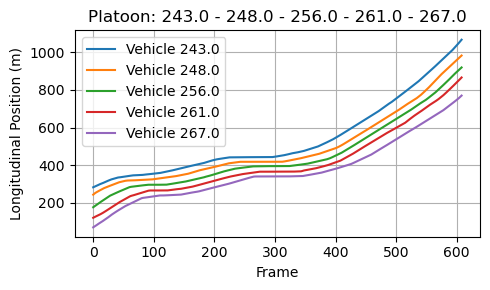

  Saved platoon to platoon_size=5/I-80/i-80_1540.csv
  Saved platoon to platoon_size=5/I-80/i-80_1541.csv
  Saved platoon to platoon_size=5/I-80/i-80_1542.csv
  Saved platoon to platoon_size=5/I-80/i-80_1543.csv
  Saved platoon to platoon_size=5/I-80/i-80_1544.csv
  Saved platoon to platoon_size=5/I-80/i-80_1545.csv
  Saved platoon to platoon_size=5/I-80/i-80_1546.csv
  Saved platoon to platoon_size=5/I-80/i-80_1547.csv
  Saved platoon to platoon_size=5/I-80/i-80_1548.csv
  Saved platoon to platoon_size=5/I-80/i-80_1549.csv
  Saved platoon to platoon_size=5/I-80/i-80_1550.csv
  Saved platoon to platoon_size=5/I-80/i-80_1551.csv
  Saved platoon to platoon_size=5/I-80/i-80_1552.csv
  Saved platoon to platoon_size=5/I-80/i-80_1553.csv
  Saved platoon to platoon_size=5/I-80/i-80_1554.csv
  Saved platoon to platoon_size=5/I-80/i-80_1555.csv
  Saved platoon to platoon_size=5/I-80/i-80_1556.csv
  Saved platoon to platoon_size=5/I-80/i-80_1557.csv
  Saved platoon to platoon_size=5/I-80/i-80_15

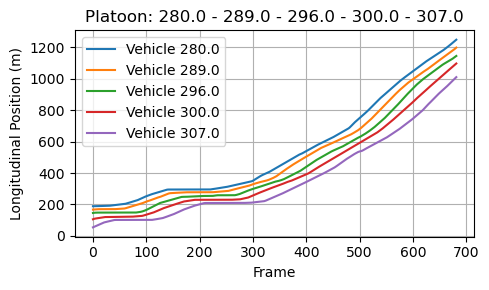

  Saved platoon to platoon_size=5/I-80/i-80_1560.csv
  Saved platoon to platoon_size=5/I-80/i-80_1561.csv
  Saved platoon to platoon_size=5/I-80/i-80_1562.csv
  Saved platoon to platoon_size=5/I-80/i-80_1563.csv
  Saved platoon to platoon_size=5/I-80/i-80_1564.csv
  Saved platoon to platoon_size=5/I-80/i-80_1565.csv
  Saved platoon to platoon_size=5/I-80/i-80_1566.csv
  Saved platoon to platoon_size=5/I-80/i-80_1567.csv
  Saved platoon to platoon_size=5/I-80/i-80_1568.csv
  Saved platoon to platoon_size=5/I-80/i-80_1569.csv
  Saved platoon to platoon_size=5/I-80/i-80_1570.csv
  Saved platoon to platoon_size=5/I-80/i-80_1571.csv
  Saved platoon to platoon_size=5/I-80/i-80_1572.csv
  Saved platoon to platoon_size=5/I-80/i-80_1573.csv
  Saved platoon to platoon_size=5/I-80/i-80_1574.csv
  Saved platoon to platoon_size=5/I-80/i-80_1575.csv
  Saved platoon to platoon_size=5/I-80/i-80_1576.csv
  Saved platoon to platoon_size=5/I-80/i-80_1577.csv
  Saved platoon to platoon_size=5/I-80/i-80_15

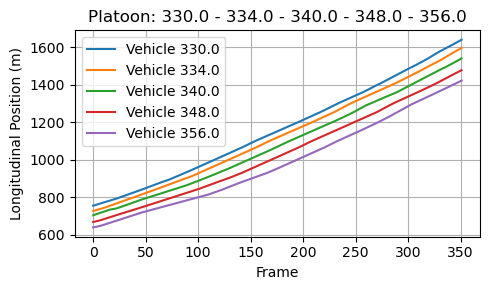

  Saved platoon to platoon_size=5/I-80/i-80_1580.csv
  Saved platoon to platoon_size=5/I-80/i-80_1581.csv
  Saved platoon to platoon_size=5/I-80/i-80_1582.csv
  Saved platoon to platoon_size=5/I-80/i-80_1583.csv
  Saved platoon to platoon_size=5/I-80/i-80_1584.csv
  Saved platoon to platoon_size=5/I-80/i-80_1585.csv
  Saved platoon to platoon_size=5/I-80/i-80_1586.csv
  Saved platoon to platoon_size=5/I-80/i-80_1587.csv
  Saved platoon to platoon_size=5/I-80/i-80_1588.csv
  Saved platoon to platoon_size=5/I-80/i-80_1589.csv
  Saved platoon to platoon_size=5/I-80/i-80_1590.csv
  Saved platoon to platoon_size=5/I-80/i-80_1591.csv
  Saved platoon to platoon_size=5/I-80/i-80_1592.csv
  Saved platoon to platoon_size=5/I-80/i-80_1593.csv
  Saved platoon to platoon_size=5/I-80/i-80_1594.csv
  Saved platoon to platoon_size=5/I-80/i-80_1595.csv
  Saved platoon to platoon_size=5/I-80/i-80_1596.csv
  Saved platoon to platoon_size=5/I-80/i-80_1597.csv
  Saved platoon to platoon_size=5/I-80/i-80_15

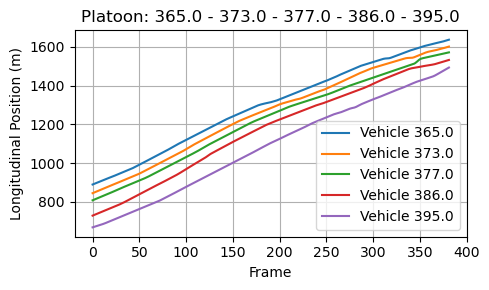

  Saved platoon to platoon_size=5/I-80/i-80_1600.csv
  Saved platoon to platoon_size=5/I-80/i-80_1601.csv
  Saved platoon to platoon_size=5/I-80/i-80_1602.csv
  Saved platoon to platoon_size=5/I-80/i-80_1603.csv
  Saved platoon to platoon_size=5/I-80/i-80_1604.csv
  Saved platoon to platoon_size=5/I-80/i-80_1605.csv
  Saved platoon to platoon_size=5/I-80/i-80_1606.csv
  Saved platoon to platoon_size=5/I-80/i-80_1607.csv
  Saved platoon to platoon_size=5/I-80/i-80_1608.csv
  Saved platoon to platoon_size=5/I-80/i-80_1609.csv
  Saved platoon to platoon_size=5/I-80/i-80_1610.csv
  Saved platoon to platoon_size=5/I-80/i-80_1611.csv
  Saved platoon to platoon_size=5/I-80/i-80_1612.csv
  Saved platoon to platoon_size=5/I-80/i-80_1613.csv
  Saved platoon to platoon_size=5/I-80/i-80_1614.csv
  Saved platoon to platoon_size=5/I-80/i-80_1615.csv
  Saved platoon to platoon_size=5/I-80/i-80_1616.csv
  Saved platoon to platoon_size=5/I-80/i-80_1617.csv
  Saved platoon to platoon_size=5/I-80/i-80_16

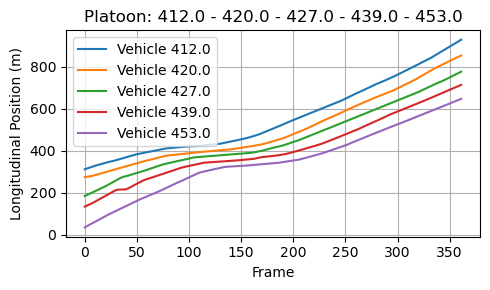

  Saved platoon to platoon_size=5/I-80/i-80_1620.csv
  Saved platoon to platoon_size=5/I-80/i-80_1621.csv
  Saved platoon to platoon_size=5/I-80/i-80_1622.csv
  Saved platoon to platoon_size=5/I-80/i-80_1623.csv
  Saved platoon to platoon_size=5/I-80/i-80_1624.csv
  Saved platoon to platoon_size=5/I-80/i-80_1625.csv
  Saved platoon to platoon_size=5/I-80/i-80_1626.csv
  Saved platoon to platoon_size=5/I-80/i-80_1627.csv
  Saved platoon to platoon_size=5/I-80/i-80_1628.csv
  Saved platoon to platoon_size=5/I-80/i-80_1629.csv
  Saved platoon to platoon_size=5/I-80/i-80_1630.csv
  Saved platoon to platoon_size=5/I-80/i-80_1631.csv
  Saved platoon to platoon_size=5/I-80/i-80_1632.csv
  Saved platoon to platoon_size=5/I-80/i-80_1633.csv
  Saved platoon to platoon_size=5/I-80/i-80_1634.csv
  Saved platoon to platoon_size=5/I-80/i-80_1635.csv
  Saved platoon to platoon_size=5/I-80/i-80_1636.csv
  Saved platoon to platoon_size=5/I-80/i-80_1637.csv
  Saved platoon to platoon_size=5/I-80/i-80_16

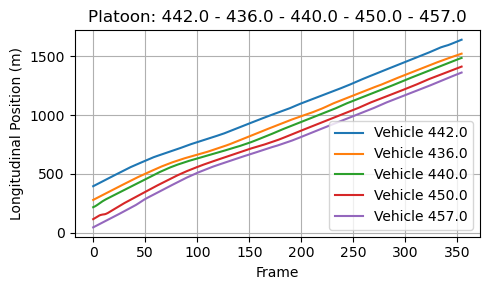

  Saved platoon to platoon_size=5/I-80/i-80_1640.csv
  Saved platoon to platoon_size=5/I-80/i-80_1641.csv
  Saved platoon to platoon_size=5/I-80/i-80_1642.csv
  Saved platoon to platoon_size=5/I-80/i-80_1643.csv
  Saved platoon to platoon_size=5/I-80/i-80_1644.csv
  Saved platoon to platoon_size=5/I-80/i-80_1645.csv
  Saved platoon to platoon_size=5/I-80/i-80_1646.csv
  Saved platoon to platoon_size=5/I-80/i-80_1647.csv
  Saved platoon to platoon_size=5/I-80/i-80_1648.csv
  Saved platoon to platoon_size=5/I-80/i-80_1649.csv
  Saved platoon to platoon_size=5/I-80/i-80_1650.csv
  Saved platoon to platoon_size=5/I-80/i-80_1651.csv
  Saved platoon to platoon_size=5/I-80/i-80_1652.csv
  Saved platoon to platoon_size=5/I-80/i-80_1653.csv
  Saved platoon to platoon_size=5/I-80/i-80_1654.csv
  Saved platoon to platoon_size=5/I-80/i-80_1655.csv
  Saved platoon to platoon_size=5/I-80/i-80_1656.csv
  Saved platoon to platoon_size=5/I-80/i-80_1657.csv
  Saved platoon to platoon_size=5/I-80/i-80_16

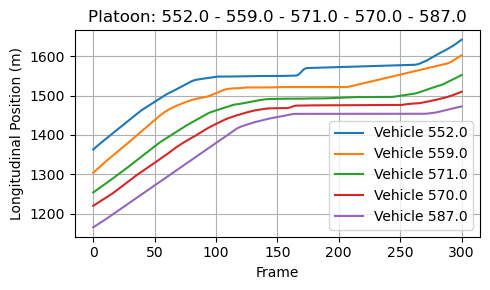

  Saved platoon to platoon_size=5/I-80/i-80_1660.csv
  Saved platoon to platoon_size=5/I-80/i-80_1661.csv
  Saved platoon to platoon_size=5/I-80/i-80_1662.csv
  Saved platoon to platoon_size=5/I-80/i-80_1663.csv
  Saved platoon to platoon_size=5/I-80/i-80_1664.csv
  Saved platoon to platoon_size=5/I-80/i-80_1665.csv
  Saved platoon to platoon_size=5/I-80/i-80_1666.csv
  Saved platoon to platoon_size=5/I-80/i-80_1667.csv
  Saved platoon to platoon_size=5/I-80/i-80_1668.csv
  Saved platoon to platoon_size=5/I-80/i-80_1669.csv
  Saved platoon to platoon_size=5/I-80/i-80_1670.csv
  Saved platoon to platoon_size=5/I-80/i-80_1671.csv
  Saved platoon to platoon_size=5/I-80/i-80_1672.csv
  Saved platoon to platoon_size=5/I-80/i-80_1673.csv
  Saved platoon to platoon_size=5/I-80/i-80_1674.csv
  Saved platoon to platoon_size=5/I-80/i-80_1675.csv
  Saved platoon to platoon_size=5/I-80/i-80_1676.csv
  Saved platoon to platoon_size=5/I-80/i-80_1677.csv
  Saved platoon to platoon_size=5/I-80/i-80_16

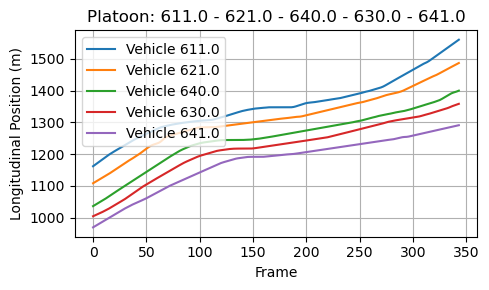

  Saved platoon to platoon_size=5/I-80/i-80_1680.csv
  Saved platoon to platoon_size=5/I-80/i-80_1681.csv
  Saved platoon to platoon_size=5/I-80/i-80_1682.csv
  Saved platoon to platoon_size=5/I-80/i-80_1683.csv
  Saved platoon to platoon_size=5/I-80/i-80_1684.csv
  Saved platoon to platoon_size=5/I-80/i-80_1685.csv
  Saved platoon to platoon_size=5/I-80/i-80_1686.csv
  Saved platoon to platoon_size=5/I-80/i-80_1687.csv
  Saved platoon to platoon_size=5/I-80/i-80_1688.csv
  Saved platoon to platoon_size=5/I-80/i-80_1689.csv
  Saved platoon to platoon_size=5/I-80/i-80_1690.csv
  Saved platoon to platoon_size=5/I-80/i-80_1691.csv
  Saved platoon to platoon_size=5/I-80/i-80_1692.csv
  Saved platoon to platoon_size=5/I-80/i-80_1693.csv
  Saved platoon to platoon_size=5/I-80/i-80_1694.csv
  Saved platoon to platoon_size=5/I-80/i-80_1695.csv
  Saved platoon to platoon_size=5/I-80/i-80_1696.csv
  Saved platoon to platoon_size=5/I-80/i-80_1697.csv
  Saved platoon to platoon_size=5/I-80/i-80_16

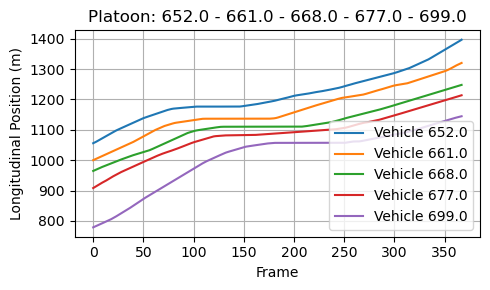

  Saved platoon to platoon_size=5/I-80/i-80_1700.csv
  Saved platoon to platoon_size=5/I-80/i-80_1701.csv
  Saved platoon to platoon_size=5/I-80/i-80_1702.csv
  Saved platoon to platoon_size=5/I-80/i-80_1703.csv
  Saved platoon to platoon_size=5/I-80/i-80_1704.csv
  Saved platoon to platoon_size=5/I-80/i-80_1705.csv
  Saved platoon to platoon_size=5/I-80/i-80_1706.csv
  Saved platoon to platoon_size=5/I-80/i-80_1707.csv
  Saved platoon to platoon_size=5/I-80/i-80_1708.csv
  Saved platoon to platoon_size=5/I-80/i-80_1709.csv
  Saved platoon to platoon_size=5/I-80/i-80_1710.csv
  Saved platoon to platoon_size=5/I-80/i-80_1711.csv
  Saved platoon to platoon_size=5/I-80/i-80_1712.csv
  Saved platoon to platoon_size=5/I-80/i-80_1713.csv
  Saved platoon to platoon_size=5/I-80/i-80_1714.csv
  Saved platoon to platoon_size=5/I-80/i-80_1715.csv
  Saved platoon to platoon_size=5/I-80/i-80_1716.csv
  Saved platoon to platoon_size=5/I-80/i-80_1717.csv
  Saved platoon to platoon_size=5/I-80/i-80_17

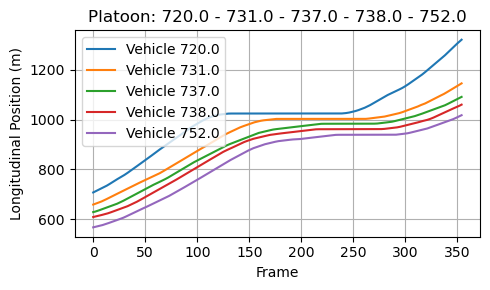

  Saved platoon to platoon_size=5/I-80/i-80_1720.csv
  Saved platoon to platoon_size=5/I-80/i-80_1721.csv
  Saved platoon to platoon_size=5/I-80/i-80_1722.csv
  Saved platoon to platoon_size=5/I-80/i-80_1723.csv
  Saved platoon to platoon_size=5/I-80/i-80_1724.csv
  Saved platoon to platoon_size=5/I-80/i-80_1725.csv
  Saved platoon to platoon_size=5/I-80/i-80_1726.csv
  Saved platoon to platoon_size=5/I-80/i-80_1727.csv
  Saved platoon to platoon_size=5/I-80/i-80_1728.csv
  Saved platoon to platoon_size=5/I-80/i-80_1729.csv
  Saved platoon to platoon_size=5/I-80/i-80_1730.csv
  Saved platoon to platoon_size=5/I-80/i-80_1731.csv
  Saved platoon to platoon_size=5/I-80/i-80_1732.csv
  Saved platoon to platoon_size=5/I-80/i-80_1733.csv
  Saved platoon to platoon_size=5/I-80/i-80_1734.csv
  Saved platoon to platoon_size=5/I-80/i-80_1735.csv
  Saved platoon to platoon_size=5/I-80/i-80_1736.csv
  Saved platoon to platoon_size=5/I-80/i-80_1737.csv
  Saved platoon to platoon_size=5/I-80/i-80_17

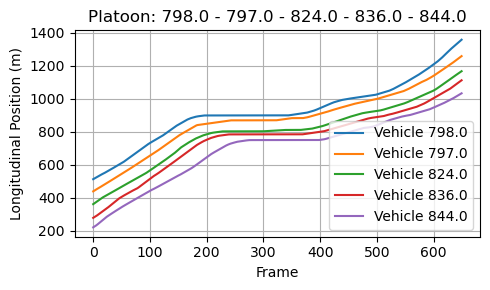

  Saved platoon to platoon_size=5/I-80/i-80_1740.csv
  Saved platoon to platoon_size=5/I-80/i-80_1741.csv
  Saved platoon to platoon_size=5/I-80/i-80_1742.csv
  Saved platoon to platoon_size=5/I-80/i-80_1743.csv
  Saved platoon to platoon_size=5/I-80/i-80_1744.csv
  Saved platoon to platoon_size=5/I-80/i-80_1745.csv
  Saved platoon to platoon_size=5/I-80/i-80_1746.csv
  Saved platoon to platoon_size=5/I-80/i-80_1747.csv
  Saved platoon to platoon_size=5/I-80/i-80_1748.csv
  Saved platoon to platoon_size=5/I-80/i-80_1749.csv
  Saved platoon to platoon_size=5/I-80/i-80_1750.csv
  Saved platoon to platoon_size=5/I-80/i-80_1751.csv
  Saved platoon to platoon_size=5/I-80/i-80_1752.csv
  Saved platoon to platoon_size=5/I-80/i-80_1753.csv
  Saved platoon to platoon_size=5/I-80/i-80_1754.csv
  Saved platoon to platoon_size=5/I-80/i-80_1755.csv
  Saved platoon to platoon_size=5/I-80/i-80_1756.csv
  Saved platoon to platoon_size=5/I-80/i-80_1757.csv
  Saved platoon to platoon_size=5/I-80/i-80_17

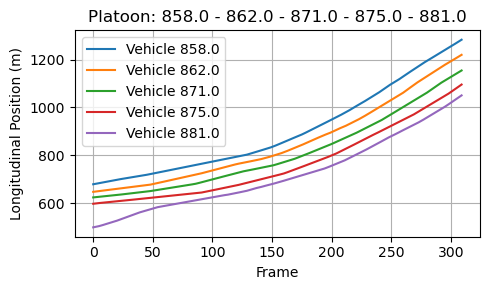

  Saved platoon to platoon_size=5/I-80/i-80_1760.csv
  Saved platoon to platoon_size=5/I-80/i-80_1761.csv
  Saved platoon to platoon_size=5/I-80/i-80_1762.csv
  Saved platoon to platoon_size=5/I-80/i-80_1763.csv
  Saved platoon to platoon_size=5/I-80/i-80_1764.csv
  Saved platoon to platoon_size=5/I-80/i-80_1765.csv
  Saved platoon to platoon_size=5/I-80/i-80_1766.csv
  Saved platoon to platoon_size=5/I-80/i-80_1767.csv
  Saved platoon to platoon_size=5/I-80/i-80_1768.csv
  Saved platoon to platoon_size=5/I-80/i-80_1769.csv
  Saved platoon to platoon_size=5/I-80/i-80_1770.csv
  Saved platoon to platoon_size=5/I-80/i-80_1771.csv
  Saved platoon to platoon_size=5/I-80/i-80_1772.csv
  Saved platoon to platoon_size=5/I-80/i-80_1773.csv
  Saved platoon to platoon_size=5/I-80/i-80_1774.csv
  Saved platoon to platoon_size=5/I-80/i-80_1775.csv
  Saved platoon to platoon_size=5/I-80/i-80_1776.csv
  Saved platoon to platoon_size=5/I-80/i-80_1777.csv
  Saved platoon to platoon_size=5/I-80/i-80_17

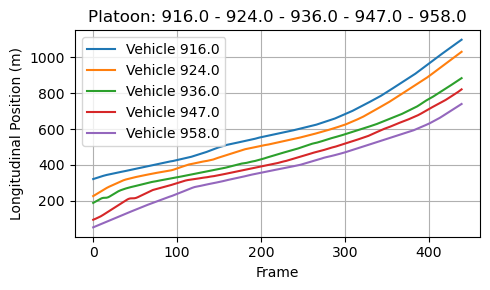

  Saved platoon to platoon_size=5/I-80/i-80_1780.csv
  Saved platoon to platoon_size=5/I-80/i-80_1781.csv
  Saved platoon to platoon_size=5/I-80/i-80_1782.csv
  Saved platoon to platoon_size=5/I-80/i-80_1783.csv
  Saved platoon to platoon_size=5/I-80/i-80_1784.csv
  Saved platoon to platoon_size=5/I-80/i-80_1785.csv
  Saved platoon to platoon_size=5/I-80/i-80_1786.csv
  Saved platoon to platoon_size=5/I-80/i-80_1787.csv
  Saved platoon to platoon_size=5/I-80/i-80_1788.csv
  Saved platoon to platoon_size=5/I-80/i-80_1789.csv
  Saved platoon to platoon_size=5/I-80/i-80_1790.csv
  Saved platoon to platoon_size=5/I-80/i-80_1791.csv
  Saved platoon to platoon_size=5/I-80/i-80_1792.csv
  Saved platoon to platoon_size=5/I-80/i-80_1793.csv
  Saved platoon to platoon_size=5/I-80/i-80_1794.csv
  Saved platoon to platoon_size=5/I-80/i-80_1795.csv
  Saved platoon to platoon_size=5/I-80/i-80_1796.csv
  Saved platoon to platoon_size=5/I-80/i-80_1797.csv
  Saved platoon to platoon_size=5/I-80/i-80_17

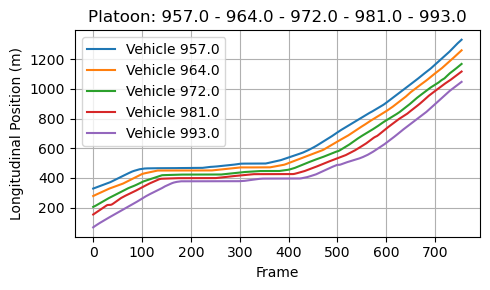

  Saved platoon to platoon_size=5/I-80/i-80_1800.csv
  Saved platoon to platoon_size=5/I-80/i-80_1801.csv
  Saved platoon to platoon_size=5/I-80/i-80_1802.csv
  Saved platoon to platoon_size=5/I-80/i-80_1803.csv
  Saved platoon to platoon_size=5/I-80/i-80_1804.csv
  Saved platoon to platoon_size=5/I-80/i-80_1805.csv
  Saved platoon to platoon_size=5/I-80/i-80_1806.csv
  Saved platoon to platoon_size=5/I-80/i-80_1807.csv
  Saved platoon to platoon_size=5/I-80/i-80_1808.csv
  Saved platoon to platoon_size=5/I-80/i-80_1809.csv
  Saved platoon to platoon_size=5/I-80/i-80_1810.csv
  Saved platoon to platoon_size=5/I-80/i-80_1811.csv
  Saved platoon to platoon_size=5/I-80/i-80_1812.csv
  Saved platoon to platoon_size=5/I-80/i-80_1813.csv
  Saved platoon to platoon_size=5/I-80/i-80_1814.csv
  Saved platoon to platoon_size=5/I-80/i-80_1815.csv
  Saved platoon to platoon_size=5/I-80/i-80_1816.csv
  Saved platoon to platoon_size=5/I-80/i-80_1817.csv
  Saved platoon to platoon_size=5/I-80/i-80_18

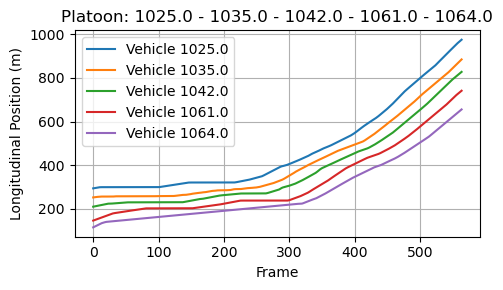

  Saved platoon to platoon_size=5/I-80/i-80_1820.csv
  Saved platoon to platoon_size=5/I-80/i-80_1821.csv
  Saved platoon to platoon_size=5/I-80/i-80_1822.csv
  Saved platoon to platoon_size=5/I-80/i-80_1823.csv
  Saved platoon to platoon_size=5/I-80/i-80_1824.csv
  Saved platoon to platoon_size=5/I-80/i-80_1825.csv
  Saved platoon to platoon_size=5/I-80/i-80_1826.csv
  Saved platoon to platoon_size=5/I-80/i-80_1827.csv
  Saved platoon to platoon_size=5/I-80/i-80_1828.csv
  Saved platoon to platoon_size=5/I-80/i-80_1829.csv
  Saved platoon to platoon_size=5/I-80/i-80_1830.csv
  Saved platoon to platoon_size=5/I-80/i-80_1831.csv
  Saved platoon to platoon_size=5/I-80/i-80_1832.csv
  Saved platoon to platoon_size=5/I-80/i-80_1833.csv
  Saved platoon to platoon_size=5/I-80/i-80_1834.csv
  Saved platoon to platoon_size=5/I-80/i-80_1835.csv
  Saved platoon to platoon_size=5/I-80/i-80_1836.csv
  Saved platoon to platoon_size=5/I-80/i-80_1837.csv
  Saved platoon to platoon_size=5/I-80/i-80_18

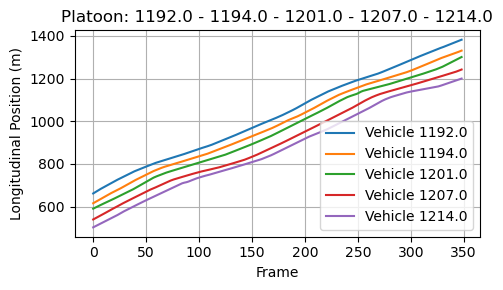

  Saved platoon to platoon_size=5/I-80/i-80_1840.csv
  Saved platoon to platoon_size=5/I-80/i-80_1841.csv
  Saved platoon to platoon_size=5/I-80/i-80_1842.csv
  Saved platoon to platoon_size=5/I-80/i-80_1843.csv
  Saved platoon to platoon_size=5/I-80/i-80_1844.csv
  Saved platoon to platoon_size=5/I-80/i-80_1845.csv
  Saved platoon to platoon_size=5/I-80/i-80_1846.csv
  Saved platoon to platoon_size=5/I-80/i-80_1847.csv
  Saved platoon to platoon_size=5/I-80/i-80_1848.csv
  Saved platoon to platoon_size=5/I-80/i-80_1849.csv
  Saved platoon to platoon_size=5/I-80/i-80_1850.csv
  Saved platoon to platoon_size=5/I-80/i-80_1851.csv
  Saved platoon to platoon_size=5/I-80/i-80_1852.csv
  Saved platoon to platoon_size=5/I-80/i-80_1853.csv
  Saved platoon to platoon_size=5/I-80/i-80_1854.csv
  Saved platoon to platoon_size=5/I-80/i-80_1855.csv
  Saved platoon to platoon_size=5/I-80/i-80_1856.csv
  Saved platoon to platoon_size=5/I-80/i-80_1857.csv
  Saved platoon to platoon_size=5/I-80/i-80_18

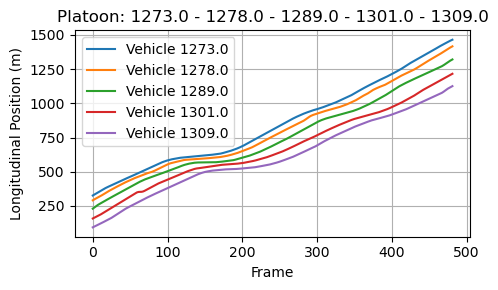

  Saved platoon to platoon_size=5/I-80/i-80_1860.csv
  Saved platoon to platoon_size=5/I-80/i-80_1861.csv
  Saved platoon to platoon_size=5/I-80/i-80_1862.csv
  Saved platoon to platoon_size=5/I-80/i-80_1863.csv
  Saved platoon to platoon_size=5/I-80/i-80_1864.csv
  Saved platoon to platoon_size=5/I-80/i-80_1865.csv
  Saved platoon to platoon_size=5/I-80/i-80_1866.csv
  Saved platoon to platoon_size=5/I-80/i-80_1867.csv
  Saved platoon to platoon_size=5/I-80/i-80_1868.csv
  Saved platoon to platoon_size=5/I-80/i-80_1869.csv
  Saved platoon to platoon_size=5/I-80/i-80_1870.csv
  Saved platoon to platoon_size=5/I-80/i-80_1871.csv
  Saved platoon to platoon_size=5/I-80/i-80_1872.csv
  Saved platoon to platoon_size=5/I-80/i-80_1873.csv
  Saved platoon to platoon_size=5/I-80/i-80_1874.csv
  Saved platoon to platoon_size=5/I-80/i-80_1875.csv
  Saved platoon to platoon_size=5/I-80/i-80_1876.csv
  Saved platoon to platoon_size=5/I-80/i-80_1877.csv
  Saved platoon to platoon_size=5/I-80/i-80_18

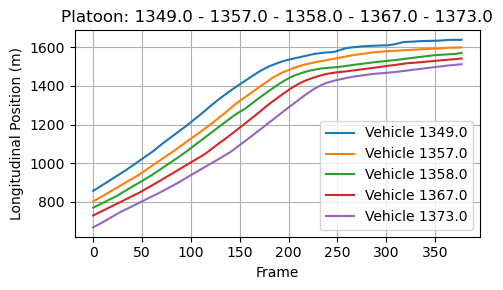

  Saved platoon to platoon_size=5/I-80/i-80_1880.csv
  Saved platoon to platoon_size=5/I-80/i-80_1881.csv
  Saved platoon to platoon_size=5/I-80/i-80_1882.csv
  Saved platoon to platoon_size=5/I-80/i-80_1883.csv
  Saved platoon to platoon_size=5/I-80/i-80_1884.csv
  Saved platoon to platoon_size=5/I-80/i-80_1885.csv
  Saved platoon to platoon_size=5/I-80/i-80_1886.csv
  Saved platoon to platoon_size=5/I-80/i-80_1887.csv
  Saved platoon to platoon_size=5/I-80/i-80_1888.csv
  Saved platoon to platoon_size=5/I-80/i-80_1889.csv
  Saved platoon to platoon_size=5/I-80/i-80_1890.csv
  Saved platoon to platoon_size=5/I-80/i-80_1891.csv
  Saved platoon to platoon_size=5/I-80/i-80_1892.csv
  Saved platoon to platoon_size=5/I-80/i-80_1893.csv
  Saved platoon to platoon_size=5/I-80/i-80_1894.csv
  Saved platoon to platoon_size=5/I-80/i-80_1895.csv
  Saved platoon to platoon_size=5/I-80/i-80_1896.csv
  Saved platoon to platoon_size=5/I-80/i-80_1897.csv
  Saved platoon to platoon_size=5/I-80/i-80_18

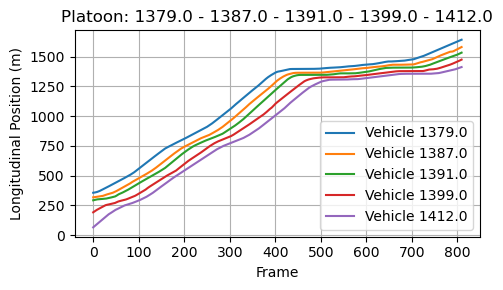

  Saved platoon to platoon_size=5/I-80/i-80_1900.csv
  Saved platoon to platoon_size=5/I-80/i-80_1901.csv
  Saved platoon to platoon_size=5/I-80/i-80_1902.csv
  Saved platoon to platoon_size=5/I-80/i-80_1903.csv
  Saved platoon to platoon_size=5/I-80/i-80_1904.csv
  Saved platoon to platoon_size=5/I-80/i-80_1905.csv
  Saved platoon to platoon_size=5/I-80/i-80_1906.csv
  Saved platoon to platoon_size=5/I-80/i-80_1907.csv
  Saved platoon to platoon_size=5/I-80/i-80_1908.csv
  Saved platoon to platoon_size=5/I-80/i-80_1909.csv
  Saved platoon to platoon_size=5/I-80/i-80_1910.csv
  Saved platoon to platoon_size=5/I-80/i-80_1911.csv
  Saved platoon to platoon_size=5/I-80/i-80_1912.csv
  Saved platoon to platoon_size=5/I-80/i-80_1913.csv
  Saved platoon to platoon_size=5/I-80/i-80_1914.csv
  Saved platoon to platoon_size=5/I-80/i-80_1915.csv
  Saved platoon to platoon_size=5/I-80/i-80_1916.csv
  Saved platoon to platoon_size=5/I-80/i-80_1917.csv
  Saved platoon to platoon_size=5/I-80/i-80_19

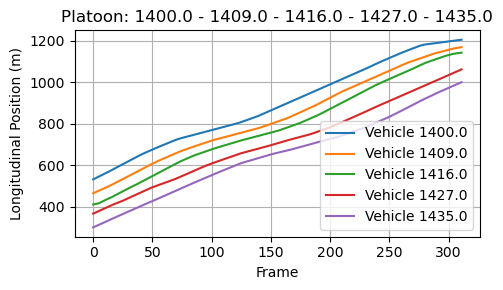

  Saved platoon to platoon_size=5/I-80/i-80_1920.csv
  Saved platoon to platoon_size=5/I-80/i-80_1921.csv
  Saved platoon to platoon_size=5/I-80/i-80_1922.csv
  Saved platoon to platoon_size=5/I-80/i-80_1923.csv
  Saved platoon to platoon_size=5/I-80/i-80_1924.csv
  Saved platoon to platoon_size=5/I-80/i-80_1925.csv
  Saved platoon to platoon_size=5/I-80/i-80_1926.csv
  Saved platoon to platoon_size=5/I-80/i-80_1927.csv
  Saved platoon to platoon_size=5/I-80/i-80_1928.csv
  Saved platoon to platoon_size=5/I-80/i-80_1929.csv
  Saved platoon to platoon_size=5/I-80/i-80_1930.csv
  Saved platoon to platoon_size=5/I-80/i-80_1931.csv
  Saved platoon to platoon_size=5/I-80/i-80_1932.csv
  Saved platoon to platoon_size=5/I-80/i-80_1933.csv
  Saved platoon to platoon_size=5/I-80/i-80_1934.csv
  Saved platoon to platoon_size=5/I-80/i-80_1935.csv
  Saved platoon to platoon_size=5/I-80/i-80_1936.csv
  Saved platoon to platoon_size=5/I-80/i-80_1937.csv
  Saved platoon to platoon_size=5/I-80/i-80_19

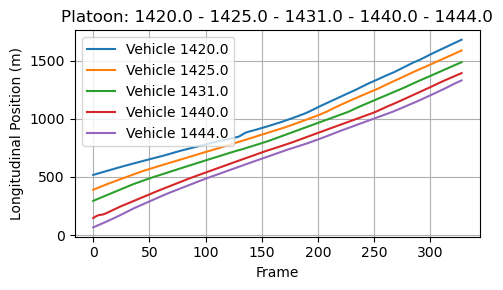

  Saved platoon to platoon_size=5/I-80/i-80_1940.csv
  Saved platoon to platoon_size=5/I-80/i-80_1941.csv
  Saved platoon to platoon_size=5/I-80/i-80_1942.csv
  Saved platoon to platoon_size=5/I-80/i-80_1943.csv
  Saved platoon to platoon_size=5/I-80/i-80_1944.csv
  Saved platoon to platoon_size=5/I-80/i-80_1945.csv
  Saved platoon to platoon_size=5/I-80/i-80_1946.csv
  Saved platoon to platoon_size=5/I-80/i-80_1947.csv
  Saved platoon to platoon_size=5/I-80/i-80_1948.csv
  Saved platoon to platoon_size=5/I-80/i-80_1949.csv
  Saved platoon to platoon_size=5/I-80/i-80_1950.csv
  Saved platoon to platoon_size=5/I-80/i-80_1951.csv
  Saved platoon to platoon_size=5/I-80/i-80_1952.csv
  Saved platoon to platoon_size=5/I-80/i-80_1953.csv
  Saved platoon to platoon_size=5/I-80/i-80_1954.csv
  Saved platoon to platoon_size=5/I-80/i-80_1955.csv
  Saved platoon to platoon_size=5/I-80/i-80_1956.csv
  Saved platoon to platoon_size=5/I-80/i-80_1957.csv
  Saved platoon to platoon_size=5/I-80/i-80_19

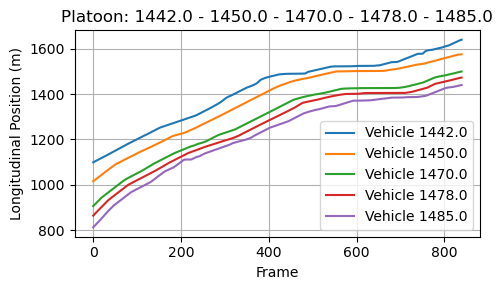

  Saved platoon to platoon_size=5/I-80/i-80_1960.csv
  Saved platoon to platoon_size=5/I-80/i-80_1961.csv
  Saved platoon to platoon_size=5/I-80/i-80_1962.csv
  Saved platoon to platoon_size=5/I-80/i-80_1963.csv
  Saved platoon to platoon_size=5/I-80/i-80_1964.csv
  Saved platoon to platoon_size=5/I-80/i-80_1965.csv
  Saved platoon to platoon_size=5/I-80/i-80_1966.csv
  Saved platoon to platoon_size=5/I-80/i-80_1967.csv
  Saved platoon to platoon_size=5/I-80/i-80_1968.csv
  Saved platoon to platoon_size=5/I-80/i-80_1969.csv
  Saved platoon to platoon_size=5/I-80/i-80_1970.csv
  Saved platoon to platoon_size=5/I-80/i-80_1971.csv
  Saved platoon to platoon_size=5/I-80/i-80_1972.csv
  Saved platoon to platoon_size=5/I-80/i-80_1973.csv
  Saved platoon to platoon_size=5/I-80/i-80_1974.csv
  Saved platoon to platoon_size=5/I-80/i-80_1975.csv
  Saved platoon to platoon_size=5/I-80/i-80_1976.csv
  Saved platoon to platoon_size=5/I-80/i-80_1977.csv
  Saved platoon to platoon_size=5/I-80/i-80_19

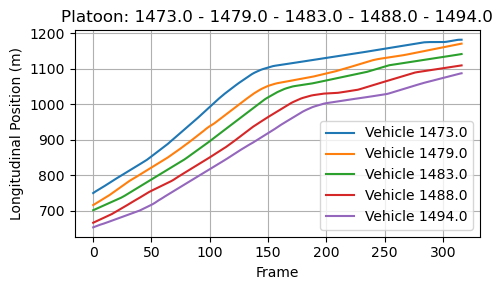

  Saved platoon to platoon_size=5/I-80/i-80_1980.csv
  Saved platoon to platoon_size=5/I-80/i-80_1981.csv
  Saved platoon to platoon_size=5/I-80/i-80_1982.csv
  Saved platoon to platoon_size=5/I-80/i-80_1983.csv
  Saved platoon to platoon_size=5/I-80/i-80_1984.csv
  Saved platoon to platoon_size=5/I-80/i-80_1985.csv
  Saved platoon to platoon_size=5/I-80/i-80_1986.csv
  Saved platoon to platoon_size=5/I-80/i-80_1987.csv
  Saved platoon to platoon_size=5/I-80/i-80_1988.csv
  Saved platoon to platoon_size=5/I-80/i-80_1989.csv
  Saved platoon to platoon_size=5/I-80/i-80_1990.csv
  Saved platoon to platoon_size=5/I-80/i-80_1991.csv
  Saved platoon to platoon_size=5/I-80/i-80_1992.csv
  Saved platoon to platoon_size=5/I-80/i-80_1993.csv
  Saved platoon to platoon_size=5/I-80/i-80_1994.csv
  Saved platoon to platoon_size=5/I-80/i-80_1995.csv
  Saved platoon to platoon_size=5/I-80/i-80_1996.csv
  Saved platoon to platoon_size=5/I-80/i-80_1997.csv
  Saved platoon to platoon_size=5/I-80/i-80_19

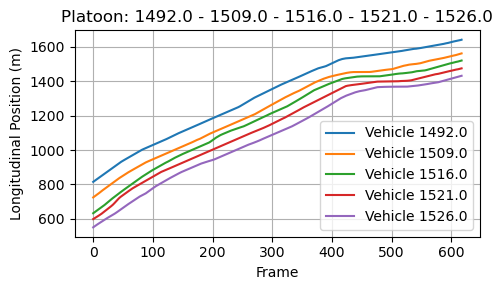

  Saved platoon to platoon_size=5/I-80/i-80_2000.csv
  Saved platoon to platoon_size=5/I-80/i-80_2001.csv
  Saved platoon to platoon_size=5/I-80/i-80_2002.csv
  Saved platoon to platoon_size=5/I-80/i-80_2003.csv
  Saved platoon to platoon_size=5/I-80/i-80_2004.csv
  Saved platoon to platoon_size=5/I-80/i-80_2005.csv
  Saved platoon to platoon_size=5/I-80/i-80_2006.csv
  Saved platoon to platoon_size=5/I-80/i-80_2007.csv
  Saved platoon to platoon_size=5/I-80/i-80_2008.csv
  Saved platoon to platoon_size=5/I-80/i-80_2009.csv
  Saved platoon to platoon_size=5/I-80/i-80_2010.csv
  Saved platoon to platoon_size=5/I-80/i-80_2011.csv
  Saved platoon to platoon_size=5/I-80/i-80_2012.csv
  Saved platoon to platoon_size=5/I-80/i-80_2013.csv
  Saved platoon to platoon_size=5/I-80/i-80_2014.csv
  Saved platoon to platoon_size=5/I-80/i-80_2015.csv
  Saved platoon to platoon_size=5/I-80/i-80_2016.csv
  Saved platoon to platoon_size=5/I-80/i-80_2017.csv
  Saved platoon to platoon_size=5/I-80/i-80_20

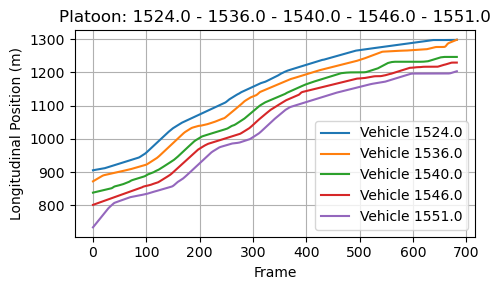

  Saved platoon to platoon_size=5/I-80/i-80_2020.csv
  Saved platoon to platoon_size=5/I-80/i-80_2021.csv
  Saved platoon to platoon_size=5/I-80/i-80_2022.csv
  Saved platoon to platoon_size=5/I-80/i-80_2023.csv
  Saved platoon to platoon_size=5/I-80/i-80_2024.csv
  Saved platoon to platoon_size=5/I-80/i-80_2025.csv
  Saved platoon to platoon_size=5/I-80/i-80_2026.csv
  Saved platoon to platoon_size=5/I-80/i-80_2027.csv
  Saved platoon to platoon_size=5/I-80/i-80_2028.csv
  Saved platoon to platoon_size=5/I-80/i-80_2029.csv
  Saved platoon to platoon_size=5/I-80/i-80_2030.csv
  Saved platoon to platoon_size=5/I-80/i-80_2031.csv
  Saved platoon to platoon_size=5/I-80/i-80_2032.csv
  Saved platoon to platoon_size=5/I-80/i-80_2033.csv
  Saved platoon to platoon_size=5/I-80/i-80_2034.csv
  Saved platoon to platoon_size=5/I-80/i-80_2035.csv
  Saved platoon to platoon_size=5/I-80/i-80_2036.csv
  Saved platoon to platoon_size=5/I-80/i-80_2037.csv
  Saved platoon to platoon_size=5/I-80/i-80_20

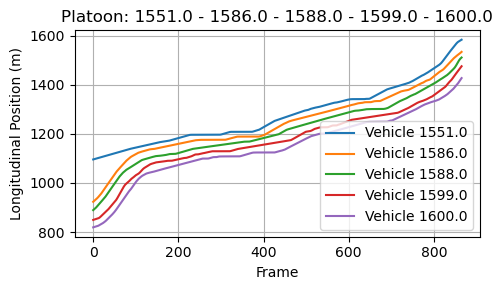

  Saved platoon to platoon_size=5/I-80/i-80_2040.csv
  Saved platoon to platoon_size=5/I-80/i-80_2041.csv
  Saved platoon to platoon_size=5/I-80/i-80_2042.csv
  Saved platoon to platoon_size=5/I-80/i-80_2043.csv
  Saved platoon to platoon_size=5/I-80/i-80_2044.csv
  Saved platoon to platoon_size=5/I-80/i-80_2045.csv
  Saved platoon to platoon_size=5/I-80/i-80_2046.csv
  Saved platoon to platoon_size=5/I-80/i-80_2047.csv
  Saved platoon to platoon_size=5/I-80/i-80_2048.csv
  Saved platoon to platoon_size=5/I-80/i-80_2049.csv
  Saved platoon to platoon_size=5/I-80/i-80_2050.csv
  Saved platoon to platoon_size=5/I-80/i-80_2051.csv
  Saved platoon to platoon_size=5/I-80/i-80_2052.csv
  Saved platoon to platoon_size=5/I-80/i-80_2053.csv
  Saved platoon to platoon_size=5/I-80/i-80_2054.csv
  Saved platoon to platoon_size=5/I-80/i-80_2055.csv
  Saved platoon to platoon_size=5/I-80/i-80_2056.csv
  Saved platoon to platoon_size=5/I-80/i-80_2057.csv
  Saved platoon to platoon_size=5/I-80/i-80_20

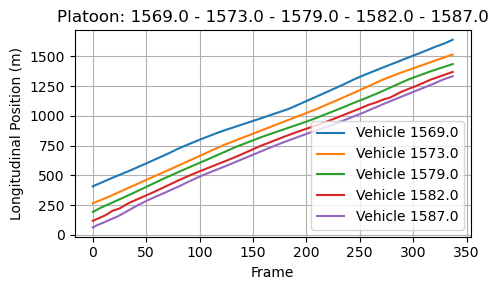

  Saved platoon to platoon_size=5/I-80/i-80_2060.csv
  Saved platoon to platoon_size=5/I-80/i-80_2061.csv
  Saved platoon to platoon_size=5/I-80/i-80_2062.csv
  Saved platoon to platoon_size=5/I-80/i-80_2063.csv
  Saved platoon to platoon_size=5/I-80/i-80_2064.csv
  Saved platoon to platoon_size=5/I-80/i-80_2065.csv
  Saved platoon to platoon_size=5/I-80/i-80_2066.csv
  Saved platoon to platoon_size=5/I-80/i-80_2067.csv
  Saved platoon to platoon_size=5/I-80/i-80_2068.csv
  Saved platoon to platoon_size=5/I-80/i-80_2069.csv
  Saved platoon to platoon_size=5/I-80/i-80_2070.csv
  Saved platoon to platoon_size=5/I-80/i-80_2071.csv
  Saved platoon to platoon_size=5/I-80/i-80_2072.csv
  Saved platoon to platoon_size=5/I-80/i-80_2073.csv
  Saved platoon to platoon_size=5/I-80/i-80_2074.csv
  Saved platoon to platoon_size=5/I-80/i-80_2075.csv
  Saved platoon to platoon_size=5/I-80/i-80_2076.csv
  Saved platoon to platoon_size=5/I-80/i-80_2077.csv
  Saved platoon to platoon_size=5/I-80/i-80_20

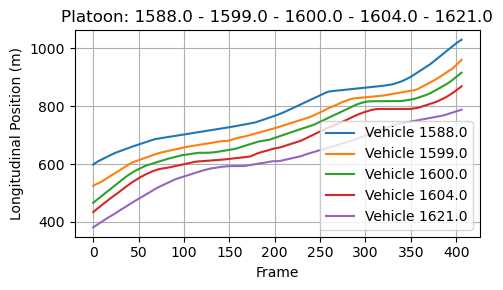

  Saved platoon to platoon_size=5/I-80/i-80_2080.csv
  Saved platoon to platoon_size=5/I-80/i-80_2081.csv
  Saved platoon to platoon_size=5/I-80/i-80_2082.csv
  Saved platoon to platoon_size=5/I-80/i-80_2083.csv
  Saved platoon to platoon_size=5/I-80/i-80_2084.csv
  Saved platoon to platoon_size=5/I-80/i-80_2085.csv
  Saved platoon to platoon_size=5/I-80/i-80_2086.csv
  Saved platoon to platoon_size=5/I-80/i-80_2087.csv
  Saved platoon to platoon_size=5/I-80/i-80_2088.csv
  Saved platoon to platoon_size=5/I-80/i-80_2089.csv
  Saved platoon to platoon_size=5/I-80/i-80_2090.csv
  Saved platoon to platoon_size=5/I-80/i-80_2091.csv
  Saved platoon to platoon_size=5/I-80/i-80_2092.csv
  Saved platoon to platoon_size=5/I-80/i-80_2093.csv
  Saved platoon to platoon_size=5/I-80/i-80_2094.csv
  Saved platoon to platoon_size=5/I-80/i-80_2095.csv
  Saved platoon to platoon_size=5/I-80/i-80_2096.csv
  Saved platoon to platoon_size=5/I-80/i-80_2097.csv
  Saved platoon to platoon_size=5/I-80/i-80_20

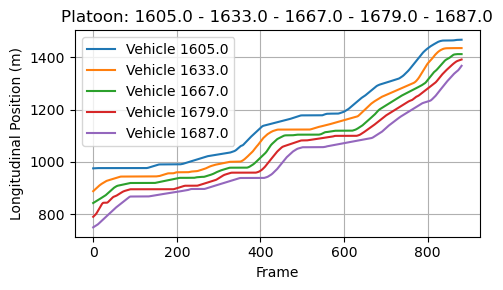

  Saved platoon to platoon_size=5/I-80/i-80_2100.csv
  Saved platoon to platoon_size=5/I-80/i-80_2101.csv
  Saved platoon to platoon_size=5/I-80/i-80_2102.csv
  Saved platoon to platoon_size=5/I-80/i-80_2103.csv
  Saved platoon to platoon_size=5/I-80/i-80_2104.csv
  Saved platoon to platoon_size=5/I-80/i-80_2105.csv
  Saved platoon to platoon_size=5/I-80/i-80_2106.csv
  Saved platoon to platoon_size=5/I-80/i-80_2107.csv
  Saved platoon to platoon_size=5/I-80/i-80_2108.csv
  Saved platoon to platoon_size=5/I-80/i-80_2109.csv
  Saved platoon to platoon_size=5/I-80/i-80_2110.csv
  Saved platoon to platoon_size=5/I-80/i-80_2111.csv
  Saved platoon to platoon_size=5/I-80/i-80_2112.csv
  Saved platoon to platoon_size=5/I-80/i-80_2113.csv
  Saved platoon to platoon_size=5/I-80/i-80_2114.csv
  Saved platoon to platoon_size=5/I-80/i-80_2115.csv
  Saved platoon to platoon_size=5/I-80/i-80_2116.csv
  Saved platoon to platoon_size=5/I-80/i-80_2117.csv
  Saved platoon to platoon_size=5/I-80/i-80_21

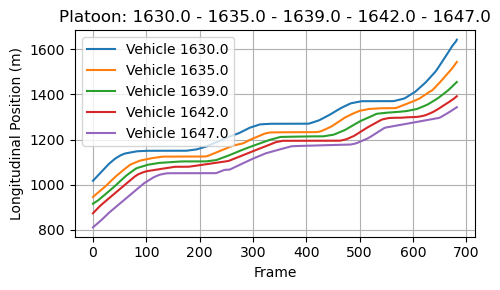

  Saved platoon to platoon_size=5/I-80/i-80_2120.csv
  Saved platoon to platoon_size=5/I-80/i-80_2121.csv
  Saved platoon to platoon_size=5/I-80/i-80_2122.csv
  Saved platoon to platoon_size=5/I-80/i-80_2123.csv
  Saved platoon to platoon_size=5/I-80/i-80_2124.csv
  Saved platoon to platoon_size=5/I-80/i-80_2125.csv
  Saved platoon to platoon_size=5/I-80/i-80_2126.csv
  Saved platoon to platoon_size=5/I-80/i-80_2127.csv
  Saved platoon to platoon_size=5/I-80/i-80_2128.csv
  Saved platoon to platoon_size=5/I-80/i-80_2129.csv
  Saved platoon to platoon_size=5/I-80/i-80_2130.csv
  Saved platoon to platoon_size=5/I-80/i-80_2131.csv
  Saved platoon to platoon_size=5/I-80/i-80_2132.csv
  Saved platoon to platoon_size=5/I-80/i-80_2133.csv
  Saved platoon to platoon_size=5/I-80/i-80_2134.csv
  Saved platoon to platoon_size=5/I-80/i-80_2135.csv
  Saved platoon to platoon_size=5/I-80/i-80_2136.csv
  Saved platoon to platoon_size=5/I-80/i-80_2137.csv
  Saved platoon to platoon_size=5/I-80/i-80_21

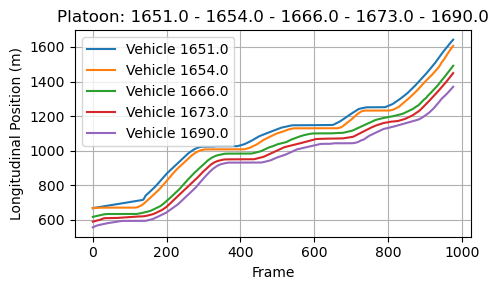

  Saved platoon to platoon_size=5/I-80/i-80_2140.csv
  Saved platoon to platoon_size=5/I-80/i-80_2141.csv
  Saved platoon to platoon_size=5/I-80/i-80_2142.csv
  Saved platoon to platoon_size=5/I-80/i-80_2143.csv
  Saved platoon to platoon_size=5/I-80/i-80_2144.csv
  Saved platoon to platoon_size=5/I-80/i-80_2145.csv
  Saved platoon to platoon_size=5/I-80/i-80_2146.csv
  Saved platoon to platoon_size=5/I-80/i-80_2147.csv
  Saved platoon to platoon_size=5/I-80/i-80_2148.csv
  Saved platoon to platoon_size=5/I-80/i-80_2149.csv
  Saved platoon to platoon_size=5/I-80/i-80_2150.csv
  Saved platoon to platoon_size=5/I-80/i-80_2151.csv
  Saved platoon to platoon_size=5/I-80/i-80_2152.csv
  Saved platoon to platoon_size=5/I-80/i-80_2153.csv
  Saved platoon to platoon_size=5/I-80/i-80_2154.csv
  Saved platoon to platoon_size=5/I-80/i-80_2155.csv
  Saved platoon to platoon_size=5/I-80/i-80_2156.csv
  Saved platoon to platoon_size=5/I-80/i-80_2157.csv
  Saved platoon to platoon_size=5/I-80/i-80_21

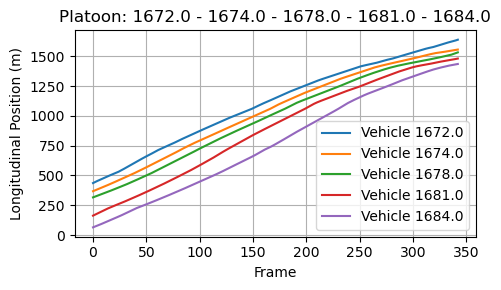

  Saved platoon to platoon_size=5/I-80/i-80_2160.csv
  Saved platoon to platoon_size=5/I-80/i-80_2161.csv
  Saved platoon to platoon_size=5/I-80/i-80_2162.csv
  Saved platoon to platoon_size=5/I-80/i-80_2163.csv
  Saved platoon to platoon_size=5/I-80/i-80_2164.csv
  Saved platoon to platoon_size=5/I-80/i-80_2165.csv
  Saved platoon to platoon_size=5/I-80/i-80_2166.csv
  Saved platoon to platoon_size=5/I-80/i-80_2167.csv
  Saved platoon to platoon_size=5/I-80/i-80_2168.csv
  Saved platoon to platoon_size=5/I-80/i-80_2169.csv
  Saved platoon to platoon_size=5/I-80/i-80_2170.csv
  Saved platoon to platoon_size=5/I-80/i-80_2171.csv
  Saved platoon to platoon_size=5/I-80/i-80_2172.csv
  Saved platoon to platoon_size=5/I-80/i-80_2173.csv
  Saved platoon to platoon_size=5/I-80/i-80_2174.csv
  Saved platoon to platoon_size=5/I-80/i-80_2175.csv
  Saved platoon to platoon_size=5/I-80/i-80_2176.csv
  Saved platoon to platoon_size=5/I-80/i-80_2177.csv
  Saved platoon to platoon_size=5/I-80/i-80_21

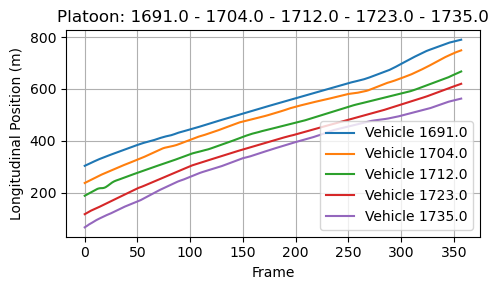

  Saved platoon to platoon_size=5/I-80/i-80_2180.csv
  Saved platoon to platoon_size=5/I-80/i-80_2181.csv
  Saved platoon to platoon_size=5/I-80/i-80_2182.csv
  Saved platoon to platoon_size=5/I-80/i-80_2183.csv
  Saved platoon to platoon_size=5/I-80/i-80_2184.csv
  Saved platoon to platoon_size=5/I-80/i-80_2185.csv
  Saved platoon to platoon_size=5/I-80/i-80_2186.csv
  Saved platoon to platoon_size=5/I-80/i-80_2187.csv
  Saved platoon to platoon_size=5/I-80/i-80_2188.csv
  Saved platoon to platoon_size=5/I-80/i-80_2189.csv
  Saved platoon to platoon_size=5/I-80/i-80_2190.csv
  Saved platoon to platoon_size=5/I-80/i-80_2191.csv
  Saved platoon to platoon_size=5/I-80/i-80_2192.csv
  Saved platoon to platoon_size=5/I-80/i-80_2193.csv
  Saved platoon to platoon_size=5/I-80/i-80_2194.csv
  Saved platoon to platoon_size=5/I-80/i-80_2195.csv
  Saved platoon to platoon_size=5/I-80/i-80_2196.csv
  Saved platoon to platoon_size=5/I-80/i-80_2197.csv
  Saved platoon to platoon_size=5/I-80/i-80_21

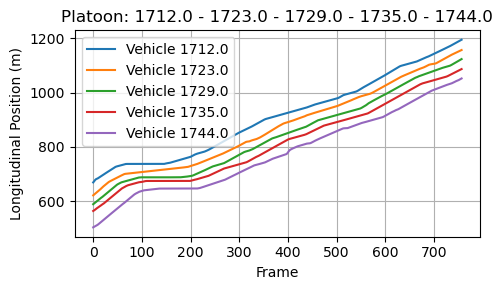

  Saved platoon to platoon_size=5/I-80/i-80_2200.csv
  Saved platoon to platoon_size=5/I-80/i-80_2201.csv
  Saved platoon to platoon_size=5/I-80/i-80_2202.csv
  Saved platoon to platoon_size=5/I-80/i-80_2203.csv
  Saved platoon to platoon_size=5/I-80/i-80_2204.csv
  Saved platoon to platoon_size=5/I-80/i-80_2205.csv
  Saved platoon to platoon_size=5/I-80/i-80_2206.csv
  Saved platoon to platoon_size=5/I-80/i-80_2207.csv
  Saved platoon to platoon_size=5/I-80/i-80_2208.csv
  Saved platoon to platoon_size=5/I-80/i-80_2209.csv
  Saved platoon to platoon_size=5/I-80/i-80_2210.csv
  Saved platoon to platoon_size=5/I-80/i-80_2211.csv
  Saved platoon to platoon_size=5/I-80/i-80_2212.csv
  Saved platoon to platoon_size=5/I-80/i-80_2213.csv


In [4]:
# Main processing

dataset = 'I-80'
# dataset = 'US-101'

# List of input files
if dataset == 'I-80':
    input_files = [
        "raw_data/"+dataset+"/trajectories-0400-0415.csv",
        "raw_data/"+dataset+"/trajectories-0500-0515.csv",
        "raw_data/"+dataset+"/trajectories-0515-0530.csv"
    ]
    file_name = 'i-80'
else:
    input_files = [
        "raw_data/"+dataset+"/trajectories-0750am-0805am.csv",
        "raw_data/"+dataset+"/trajectories-0805am-0820am.csv",
        "raw_data/"+dataset+"/trajectories-0820am-0835am.csv"
    ]
    file_name = 'us-101'

# Define the desired platoon size (e.g., 4 vehicles per platoon)
platoon_size = 5

# Output folder
output_folder = "platoon_size="+str(platoon_size)+"/"+dataset+"/"
os.makedirs(output_folder, exist_ok=True)


# Counter for naming the output CSV files
output_counter = 0

# Process each file
for file_path in input_files:
    print(f"Processing file: {file_path}")
    data = pd.read_csv(file_path)
    platoon_trajectories = extract_vehicle_platoons(data, platoon_size=platoon_size, window_length=300)
    
    print(f"  Found {len(platoon_trajectories)} platoon trajectories.")
    # Save each platoon trajectory as a separate CSV file
    for platoon in platoon_trajectories:
        positions = platoon["Longitudinal_Positions"]  # Shape: (platoon_size, T)
        vehicle_ids = platoon["Vehicle_IDs"]            # Tuple of vehicle IDs
        
        # Build a DataFrame:
        # Rows: one per vehicle (platoon_size rows)
        # Columns: step0, step1, ..., step{T-1} plus an "id" column.
        T = positions.shape[1]
        step_columns = [f"step{i}" for i in range(T)]
        df_platoon = pd.DataFrame(positions, columns=step_columns)
        df_platoon.insert(0, "id", list(vehicle_ids))
        
        # Build output filename with zero-padded counter
        output_filename = os.path.join(output_folder, f"{file_name}_{output_counter:04d}.csv")
        df_platoon.to_csv(output_filename, index=False)
        print(f"  Saved platoon to {output_filename}")
        
        output_counter += 1
        
        # Every 20 files saved, plot the trajectory
        if output_counter % 20 == 0:
            print(f"  Plotting platoon {vehicle_ids} (file {output_counter})")
            plot_platoon(platoon)
